In [1]:
import sys ; sys.path.insert(0, '../')
from notebook_tools import *
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
%matplotlib inline
from scipy.interpolate import interp1d

In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/'

In [3]:
def plot_needed_for_A_depdendence_sigma_t(ax=None,figsize=(16,15),s=30,
                                          xlim=(2.5,250), ylim=(0,200), #79
                                          labels=dict({'$^4$He':(3.5,122),
                                                '$^{12}$C':(9,165),
                                                '$^{27}$Al':(21,182),
                                                '$^{56}$Fe':(45,185),
                                                '$^{208}$Pb':(140,184),                                               
                                                      }),
                                          fontsize=55,
                                          do_Ciofi=True):
    from scipy.interpolate import interp1d

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    # for all plots
    plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' , vary='allpairs',color='black' ,label='Colle et al., All pairs')
    plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' ,linestyle='-',color='black', vary='nl00',label='Colle et al., $^1S_0$ pairs')
    if do_Ciofi: ax.errorbar(CiofiCalc.A, CiofiCalc.s_t,markeredgecolor='black',marker='*',ms=30,mfc='none',linewidth=0, markeredgewidth=2,label='Ciofi and Simula')
    plot_data( data=BNL_Data, ax=ax, Ashift=1 , color='blue', marker='s', label=None )
    plot_data( data=HallA_Data, ax=ax, Ashift=-1 , color='blue' , marker='s' , label='Hall-A/BNL' )
    plot_data( data=Korover_Data , ax=ax, marker='s' , color='blue', label=None )
    
    ax.set_xscale('log')
    set_axes(ax , 'A' , '$\sigma_{c.m.}$ [GeV/c]' , fontsize=fontsize 
             ,xticks=[4,12,27,56,208]
             ,yticks=[100,125,150,175,200])
    ax.grid(b=True, which='major', color='b', linestyle='--',alpha=0.25)    
    if xlim is not None:    ax.set_xlim(xlim);
    if ylim is not None:    ax.set_ylim(ylim);
    # target name labels
    for label in list(labels.keys()):
        ax.text(labels[label][0],labels[label][1],label,fontsize=35)
    return ax

def plot_A_depdendence_sigma_t(data=None,
                               figsize=(16,15),s=30,fontsize=55,
                               xlim=(2.5,250), ylim=(79,200),  #79
                               do_save_fig=True, filename='corrected_sigma_t_with_calculations',
                               labels=dict({'$^4$He':(3.5,122), '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,185), '$^{208}$Pb':(140,184), }),
                               do_Ciofi=True,do_measured=True,
                               do_stat_uncertainties=False,do_sys_uncertainties=False,do_tot_uncertainties=True):
    
    fig,ax = plt.subplots(figsize=figsize)
    ax=plot_needed_for_A_depdendence_sigma_t(ax=ax,figsize=figsize,fontsize=fontsize,s=s,xlim=xlim, ylim=ylim,labels=labels,do_Ciofi=do_Ciofi)
    # measured
    if do_measured: ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
    # corrected
    if do_tot_uncertainties:
        plot_data_assymetric( data=data, ax=ax, label='This work', markersize=20 ,color='red' , marker='o')
        
    # seperated statistical uncertainty
    if do_stat_uncertainties: 
        A,st,sterr = cm_pars['A'], 1000*data['sigma_t_final'], 1000*data['sigma_t_final_Err_stat']
        if do_tot_uncertainties:
            ax.errorbar(A,st,sterr ,ecolor='purple',elinewidth=2 , capsize=15, capthick=3 , linestyle='none'
                        ,linewidth=3, label='stat. uncertainties')
        else: 
            ax.errorbar(A,st,sterr ,ecolor='red',color='red', marker='o', markersize=20 ,elinewidth=2 , capsize=15, capthick=3 , linestyle='none'
                        ,linewidth=3, label='stat. uncertainties')

#     ax.legend(fontsize=25,loc='lower right')
    # add a band of systematical uncertaintes
    if do_sys_uncertainties:
        ax.fill_between(cm_pars['A']
                        , np.min(ax.get_ylim())
                        , np.min(ax.get_ylim()) + 1000*data['sigma_t_final_up_err_sys'] 
                        , color='purple' , alpha=0.5 ,  label='sys. uncertainties')
    ax.legend(fontsize=25,loc='upper left')

# generated vs. reconstructed in bins of generated

In [4]:
columns = ['Pmiss3Mag','pcmX','pcmY','pcmZ','rooWeight'] # ,'Mott','DipoleFF2'
data_allPmiss_PrecFid , data300Pmiss600_PrecFid = dict() , dict()
for target in ['C12','Al27','Fe56','Pb208']:
    data_allPmiss_PrecFid[target] = read_root( path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_300Pmiss600_%s_PrecFiducials.root"%target, columns=columns )
    data300Pmiss600_PrecFid[target] = data_allPmiss_PrecFid[target][data_allPmiss_PrecFid[target]['Pmiss3Mag']<0.6]

In [5]:
cm_parameters = dict()
cm_parameters_with_correction = dict()
for Fiducials in ["NoPrecFiducials","PrecFiducials"]:
    cm_pars = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/300Pmiss600/alltargets_'+Fiducials+'_dataCMparameters.csv')
    cm_pars['sigma_x_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_x_unweighted']) - np.square(0.02))
    cm_pars['sigma_x_before_acc_corr_err'] = cm_pars['sigma_xErr_unweighted']
    cm_pars['sigma_y_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_y_unweighted']) - np.square(0.02))
    cm_pars['sigma_y_before_acc_corr_err'] = cm_pars['sigma_yErr_unweighted']
    
    
    # weighted average
    sigma_x, Dsigma_x = cm_pars['sigma_x_before_acc_corr'], cm_pars['sigma_x_before_acc_corr_err']
    sigma_y, Dsigma_y = cm_pars['sigma_y_before_acc_corr'], cm_pars['sigma_y_before_acc_corr_err']
    sigma_t = (sigma_x/np.square(Dsigma_x)+sigma_y/np.square(Dsigma_y))/( 1./np.square(Dsigma_x) + 1./np.square(Dsigma_y))
    cm_pars['sigma_t_before_acc_corr'] = sigma_t    
    Dsigma_t = np.sqrt(1./( 1./np.square(Dsigma_x) + 1./np.square(Dsigma_y) ))
    cm_pars['sigma_t_before_acc_corr_err'] = Dsigma_t
    cm_parameters[Fiducials] = cm_pars
    cm_parameters_with_correction[Fiducials] = cm_pars
cm_parameters[Fiducials]

Nevts  chi2red_x_unweighted  chi2red_y_unweighted  chi2red_z_unweighted  \
0    266              0.602767              0.407306              2.139232   
1     88              1.058674              0.542381              0.460758   
2    227              0.471936              0.458693              1.598486   
3     45              0.847317              0.596230              0.395723   

   mean_xErr_unweighted  mean_x_unweighted  mean_yErr_unweighted  \
0              0.009711          -0.026697              0.009910   
1              0.019329          -0.035170              0.017791   
2              0.011862          -0.027254              0.012322   
3              0.029217          -0.024147              0.024489   

   mean_y_unweighted  mean_zErr_unweighted  mean_z_unweighted  \
0          -0.005837              0.009028           0.106593   
1           0.017157              0.015036           0.118663   
2          -0.009223              0.009999           0.149765   
3           0.016012              0.025269           0.177513   

              ...              sigma_zErr_unweighted  sigma_z_unweighted  \
0             ...                           0.006384            0.147251   
1             ...                           0.010629            0.141058   
2             ...                           0.007069            0.150658   
3             ...                           0.017832            0.169545   

       target    A  sigma_x_before_acc_corr  sigma_x_before_acc_corr_err  \
0    $^{12}$C   12                 0.157110                     0.006865   
1   $^{27}$Al   27                 0.180235                     0.013666   
2   $^{56}$Fe   56                 0.177601                     0.008388   
3  $^{208}$Pb  208                 0.195017                     0.020634   

   sigma_y_before_acc_corr  sigma_y_before_acc_corr_err  \
0                 0.160396                     0.007007   
1                 0.165708                     0.012570   
2                 0.184577                     0.008706   
3                 0.163082                     0.017300   

   sigma_t_before_acc_corr sigma_t_before_acc_corr_err  
0                 0.158720                    0.004904  
1                 0.172366                    0.009252  
2                 0.180959                    0.006040  
3                 0.176265                    0.013257  

[4 rows x 27 columns]

In [10]:
cm_parameters[Fiducials][['sigma_x_before_acc_corr','sigma_x_before_acc_corr_err','sigma_y_before_acc_corr','sigma_y_before_acc_corr_err','sigma_t_before_acc_corr','sigma_t_before_acc_corr_err']]

sigma_x_before_acc_corr  sigma_x_before_acc_corr_err  \
0                 0.157110                     0.006865   
1                 0.180235                     0.013666   
2                 0.177601                     0.008388   
3                 0.195017                     0.020634   

   sigma_y_before_acc_corr  sigma_y_before_acc_corr_err  \
0                 0.160396                     0.007007   
1                 0.165708                     0.012570   
2                 0.184577                     0.008706   
3                 0.163082                     0.017300   

   sigma_t_before_acc_corr  sigma_t_before_acc_corr_err  
0                 0.158720                     0.004904  
1                 0.172366                     0.009252  
2                 0.180959                     0.006040  
3                 0.176265                     0.013257

## cm_parameters['PrecFiducials']

In [11]:
targets = ['C','Al','Fe','Pb']
target_names = [r'$^{12}$C',r'$^{27}$Al',r'$^{56}$Fe',r'$^{208}$Pb']
colors = ['red','blue','forestgreen','purple']
As = [12,27,56,208]
Neep = [7598,2573,8558,2635]
Neepp = [266,88,227,45]
simulation_results = dict()

In [12]:
for Fiducials in ["PrecFiducials"]:
    for A,target in zip(As,targets):
        test_name = "simulations_"+Fiducials+"_"+target
        simulation_results[test_name] = pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/final_simualtions_300Pmiss600/"+test_name+".csv")
        simulation_results[test_name].fillna(-1,inplace=True)
        print len(simulation_results[test_name]),'events in ',test_name

76800 events in  simulations_PrecFiducials_C
76557 events in  simulations_PrecFiducials_Al
75700 events in  simulations_PrecFiducials_Fe
55836 events in  simulations_PrecFiducials_Pb


In [18]:
def plot_cm_direction_binned(sims=None
                             ,Fiducials='PrecFiducials',extraname=""                              
                             ,ax=None,A=12,poly_degree=3
                             ,direction='x',colors=['blue','royalblue'],s=1
                             ,Nbins_st_rec=10 # GeV/c
                             ,do_add_1Ddist_in_slices=True
                             ,debug=0
                             ,do_zoom_in=False
                             ,do_add_legend=True):

        
    # measured \sigma_t (DATA)
    cm_pars = cm_parameters[Fiducials]        
    cm_tgt = cm_pars[cm_pars['A']==A]
    index = cm_pars[cm_pars['A']==A].index
    if debug>1: print cm_tgt
    sigma_meas = float(cm_tgt['sigma_'+direction+'_before_acc_corr'])
    sigma_meas_err = float(cm_tgt['sigma_'+direction+'_before_acc_corr_err'])
    
    title = cm_tgt['target'].to_string(index=False) + ', $'+direction+'-direction$'
    if debug: print title

    # region of interest: 2$\sigma$ around measured value
    roi_min = sigma_meas - 2*sigma_meas_err
    roi_max = sigma_meas + 2*sigma_meas_err
    roi_width = roi_max - roi_min
    if debug: print '\sigma_t roi: %.3f->%.3f GeV/c'%(roi_min,roi_max)
    # create bins in region of interest
    roi_sims = sims[(sims['rec_sigma_'+direction]>roi_min)&(sims['rec_sigma_'+direction]<roi_max)]
    
    
    gen,rec = sims['gen_Sigma_t'],sims['rec_sigma_'+direction]
#     plt.scatter(gen,rec,color=colors[1],label='generated vs. reconstructed',s=s)
    if do_zoom_in:
        bins = np.linspace( 0.1 , 0.26 , 50)
    else:
        bins=np.linspace( 0.02 , 0.3 , 50 )
    ax.hist2d(gen,rec,cmap=colors[2],label='generated vs. reconstructed',bins=bins)#,norm=LogNorm())


    # bin in rec. sigma_t
    rec_bins,rec_bins_err,gen_bins,gen_bins_err=[],[],[],[]    
    bin_st_rec_width = roi_width/Nbins_st_rec
    if debug:  print 'bin_st_rec_width:',bin_st_rec_width 
    if do_add_1Ddist_in_slices:
        fig_1Ddist_in_slices = plt.figure(figsize=(16,8))

    
    for i_bin in range(Nbins_st_rec):
        bin_st_rec_center = roi_min + bin_st_rec_width*(i_bin+0.5)
        bin_st_rec_dw = bin_st_rec_center - 0.5*bin_st_rec_width
        bin_st_rec_up = bin_st_rec_center + 0.5*bin_st_rec_width

        # Olympic method to remove extremists
        sims_bin = roi_sims[(roi_sims['rec_sigma_'+direction]>bin_st_rec_dw)
                            &(roi_sims['rec_sigma_'+direction]<bin_st_rec_up)]
        bin_st_gen_mean = np.mean(sims_bin['gen_Sigma_t'])
        bin_st_gen_std = np.std(sims_bin['gen_Sigma_t'])
        trim_up = bin_st_gen_mean+2*bin_st_gen_std
        trim_dw = bin_st_gen_mean-2*bin_st_gen_std
        # -->
        sims_bin_trimmed = sims_bin[(sims_bin['gen_Sigma_t']>trim_dw)&(sims_bin['gen_Sigma_t']<trim_up)]
        bin_st_gen_mean = np.mean(sims_bin_trimmed['gen_Sigma_t'])
        bin_st_gen_std = np.std(sims_bin_trimmed['gen_Sigma_t'])
        
        if debug>1: print 'bin in \sigma_t: (%.3f-%.3f)'%(bin_st_rec_dw,bin_st_rec_up)
        if debug>1: print 'gen \sigma_t: (%.3f-%.3f)'%(bin_st_gen_mean-bin_st_gen_std,bin_st_gen_mean+bin_st_gen_std)
            
        if do_add_1Ddist_in_slices:
            ax_1Ddist_in_slices = fig_1Ddist_in_slices.add_subplot(Nbins_st_rec/4+1,4,i_bin+1)
            ax_1Ddist_in_slices.hist( sims_bin['gen_Sigma_t'] , bins=30 , color=colors[1])
            set_axes(ax_1Ddist_in_slices,r'gen. $\sigma$ [GeV/c]' if i_bin>(Nbins_st_rec-5) else ''
                     ,title=r'$%.3f'%bin_st_rec_dw+'<\sigma_{'+direction+'}^{rec}<%.3f$'%bin_st_rec_up
                     ,xticks=np.linspace(np.min(sims_bin['gen_Sigma_t']),np.max(sims_bin['gen_Sigma_t']),3)
                     ,fontsize=20)
            ax_1Ddist_in_slices.plot( [bin_st_gen_mean,bin_st_gen_mean] , ax_1Ddist_in_slices.get_ylim() , '-' , color='black')
            ax_1Ddist_in_slices.plot( [bin_st_gen_mean-bin_st_gen_std,bin_st_gen_mean-bin_st_gen_std] , ax_1Ddist_in_slices.get_ylim() , '--' , color='black')
            ax_1Ddist_in_slices.plot( [bin_st_gen_mean+bin_st_gen_std,bin_st_gen_mean+bin_st_gen_std] , ax_1Ddist_in_slices.get_ylim() , '--' , color='black')
            ax_1Ddist_in_slices.yaxis.set_major_formatter(NullFormatter())
            # trimming lines
            ax_1Ddist_in_slices.plot( [trim_up,trim_up] , ax_1Ddist_in_slices.get_ylim() , '-' , color='red')
            ax_1Ddist_in_slices.plot( [trim_dw,trim_dw] , ax_1Ddist_in_slices.get_ylim() , '-' , color='red')



                                
        if bin_st_gen_mean is not np.nan:
            rec_bins.append(bin_st_rec_center)
            rec_bins_err.append(bin_st_rec_width)
            gen_bins.append(bin_st_gen_mean)
            gen_bins_err.append(bin_st_gen_std)
            
    if debug: print 'rec_bins_err:',rec_bins_err
    if debug: print 'gen_bins_err:',gen_bins_err

    rec_bins,rec_bins_err,gen_bins,gen_bins_err = np.array(rec_bins),np.array(rec_bins_err),np.array(gen_bins),np.array(gen_bins_err)
    ax.errorbar(x=gen_bins,xerr=gen_bins_err,y=rec_bins,yerr=0.5*rec_bins_err,fmt='o',color='black')
    if do_add_1Ddist_in_slices: 
        plt.tight_layout()
        plt.savefig(figures_path+'1Ddist_in_slices/'+'A_%d'%A+'_direction_'+direction+'_'+extraname+'.png')

    # fit a polynomial of order poly_degree
    if debug: print "gen_bins:",gen_bins,"\nrec_bins:",rec_bins

    popt,cov = np.polyfit( gen_bins , rec_bins , poly_degree , cov=True)
    perr = np.sqrt(np.diag(cov))
    if debug: print "popt:",popt,"\nperr:",perr
    
    x = np.linspace( np.min(gen_bins) , np.max(gen_bins) , 500)
    poly = np.poly1d(popt)
    ax.plot( x , poly(x),'-',color='black',linewidth=2,label='best fit')    

    y =  np.ones(len(x)) * sigma_meas
    yErr =  np.ones(len(x)) * sigma_meas_err

    # corrected value
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_value =  find_x_poly(poly , sigma_meas)
    if debug: print 'sigma_meas:',sigma_meas
    if debug: print 'corr_value:',corr_value

    label_corr = '$%.3f$'%(corr_value)
    ax.plot( np.linspace(np.min(ax.get_xlim()),corr_value,len(x)) , y , color=colors[1],label='measured: $%.3f\\pm%.3f$'%(sigma_meas, sigma_meas_err))
    ax.plot( [corr_value,corr_value] , [np.min(ax.get_ylim()),sigma_meas] , color=colors[1])
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected'+extraname,corr_value) 
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 

    # only statistical uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    x_poly_up_stat = find_x_poly(poly,sigma_meas+sigma_meas_err)
    x_poly_dw_stat = find_x_poly(poly,sigma_meas-sigma_meas_err)
    corr_val_up_err_stat = x_poly_up_stat - corr_value
    corr_val_dw_err_stat = corr_value - x_poly_dw_stat
    label_unc_stat = '$(^{+%.0f}_{-%.0f})_{stat.}$'%(1000*corr_val_up_err_stat,1000*corr_val_dw_err_stat)    
    # projection of the measured uncertainties
    ax.plot( np.linspace(np.min(ax.get_xlim()),x_poly_up_stat,len(x)) , y+yErr , color=colors[0],linestyle='-',alpha=0.35)
    ax.plot( np.linspace(np.min(ax.get_xlim()),x_poly_dw_stat,len(x)) , y-yErr , color=colors[0],linestyle='-',alpha=0.35)

    ax.plot( [x_poly_up_stat,x_poly_up_stat] , [np.min(ax.get_ylim()),sigma_meas+sigma_meas_err] , color='black' ,linestyle='--')
    ax.plot( [x_poly_dw_stat,x_poly_dw_stat] , [np.min(ax.get_ylim()),sigma_meas-sigma_meas_err] , color='black' ,linestyle='--' )
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_stat'+extraname,corr_val_up_err_stat)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_stat'+extraname,corr_val_dw_err_stat)
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    set_axes(ax,'gen. $\\sigma$ [GeV/c]','rec. $\\sigma_'+direction+'$ [GeV/c]'    
             , xticks=[0.05,0.1,0.15,0.2,0.25] , yticks=[0.05,0.1,0.15,0.2,0.25] , do_add_grid=True , xlim=(0.02,0.3), ylim=(0.02,0.3)
             ,title=title)
    plt.tight_layout() 
    if do_zoom_in:
        ax.set_xlim(find_x_poly(poly,sigma_meas - 3*sigma_meas_err),find_x_poly(poly,sigma_meas + 3*sigma_meas_err) ); 
        ax.xaxis.set_major_locator(LinearLocator(4)); ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        ax.set_ylim(sigma_meas - 3*sigma_meas_err,sigma_meas +3*sigma_meas_err);
        ax.yaxis.set_major_locator(LinearLocator(4)); ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # systematical uncertainty
    # by creating a bin from the rec. around the measured data,
    # and asking what is the 1\sigma width of the generated in this bin
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    #     sims_bin_meas = roi_sims[(roi_sims['rec_sigma_'+direction]>(sigma_meas - sigma_meas_err))
    #                              &(roi_sims['rec_sigma_'+direction]<(sigma_meas + sigma_meas_err))]        
    sims_bin_meas = roi_sims[(roi_sims['rec_sigma_'+direction]>(sigma_meas - 0.5*bin_st_rec_width))
                             &(roi_sims['rec_sigma_'+direction]<(sigma_meas + 0.5*bin_st_rec_width))]        
    bin_st_gen_mean = np.mean(sims_bin_meas['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas['gen_Sigma_t'])
    # -->
    sims_bin_meas_trimmed = sims_bin_meas[(sims_bin_meas['gen_Sigma_t']>bin_st_gen_mean-2*bin_st_gen_std)                                  
                                          &(sims_bin_meas['gen_Sigma_t']<bin_st_gen_mean+2*bin_st_gen_std)]
    bin_st_gen_mean = np.mean(sims_bin_meas_trimmed['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas_trimmed['gen_Sigma_t'])
    ax.errorbar(x=[corr_value],xerr=[bin_st_gen_std]
                ,y=[sigma_meas-0.015],yerr=[0.5*bin_st_rec_width],fmt='o',color='grey',linewidth=3,capthick=3)


    corr_val_err_sys = bin_st_gen_std 
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_err_sys'+extraname,corr_val_err_sys)
    label_unc_sys = '$(\\pm %.0f)_{sys.}$'%(1000*corr_val_err_sys)

    # projection of the systematical uncertainties
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    ax.plot( [corr_value+corr_val_err_sys,corr_value+corr_val_err_sys] , [np.min(ax.get_ylim()),sigma_meas] , color='grey' ,linestyle='-')
    ax.plot( [corr_value-corr_val_err_sys,corr_value-corr_val_err_sys] , [np.min(ax.get_ylim()),sigma_meas] , color='grey' ,linestyle='-' )
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    
    # total uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_val_up_err_tot = np.sqrt(np.square(corr_val_up_err_stat) + np.square(corr_val_err_sys))
    corr_val_dw_err_tot = np.sqrt(np.square(corr_val_dw_err_stat) + np.square(corr_val_err_sys))
    # --- - - -- -- - -- - -- -- - -- -- -- - -- ---         

    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_tot'+extraname,corr_val_up_err_tot)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_tot'+extraname,corr_val_dw_err_tot)             
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_err_tot'+extraname,0.5*(corr_val_dw_err_tot+corr_val_up_err_tot))

    
    ax.plot( [0,0] , [0,0] , color=colors[0], linewidth=3,label='corrected:'+label_corr+label_unc_stat+label_unc_sys)
    if do_add_legend: ax.legend(loc='upper left',fontsize=20,scatterpoints=3,markerscale=2)
    return corr_value, corr_val_up_err_tot , corr_val_dw_err_tot

In [19]:
def interval_68_from_start_point( a=None, start_x = -np.inf, dx=0.001 , debug=0):
    '''
    return the end point of the 68% interval starting at start_x
    '''
    end_x = start_x
    frac = 0
    N_tot = len(a[a<np.inf])
    step = 0
    while( frac < 0.68 ):#{
        end_x = end_x + dx
        N_start_end = len(a[(a>start_x)&(a<end_x)])
        frac = float(N_start_end)/N_tot
        step += 1
        if step>1000: break
    #}
    if debug: print 'frac:',frac
    return end_x

def find_smallest_interval( a=None, dx=0.001 ):
    l_interval = 10000
    for start_x in np.arange(np.min(a),np.mean(a)+np.std(a),dx):
        # print 'start_x:',start_x
        end_x = interval_68_from_start_point(start_x=start_x,a=a,dx=dx)
        if ((end_x-start_x) < l_interval):
            l_interval = end_x-start_x
            interval = [start_x,end_x]
    return interval

In [20]:
def plot_cm_direction_binned_confidence68(sims=None
                             ,Fiducials='PrecFiducials',extraname=""                              
                             ,ax=None,A=12,poly_degree=3
                             ,direction='x',colors=['blue','royalblue'],s=1
                             ,Nbins_st_rec=10 # GeV/c
                             ,do_add_1Ddist_in_slices=True
                             ,debug=0
                             ,do_zoom_in=False
                             ,do_add_legend=True):

        
    # measured \sigma_t (DATA)
    cm_pars = cm_parameters[Fiducials]        
    cm_tgt = cm_pars[cm_pars['A']==A]
    index = cm_pars[cm_pars['A']==A].index
    if debug>1: print cm_tgt
    sigma_meas = float(cm_tgt['sigma_'+direction+'_before_acc_corr'])
    sigma_meas_err = float(cm_tgt['sigma_'+direction+'_before_acc_corr_err'])
    
    title = cm_tgt['target'].to_string(index=False) + ', $'+direction+'-direction$'
    if debug: print title

    # region of interest: 2$\sigma$ around measured value
    roi_min = sigma_meas - 2*sigma_meas_err
    roi_max = sigma_meas + 2*sigma_meas_err
    roi_width = roi_max - roi_min
    if debug: print '\sigma_t roi: %.3f->%.3f GeV/c'%(roi_min,roi_max)
    # create bins in region of interest
    roi_sims = sims[(sims['rec_sigma_'+direction]>roi_min)&(sims['rec_sigma_'+direction]<roi_max)]
    
    
    gen,rec = sims['gen_Sigma_t'],sims['rec_sigma_'+direction]
#     plt.scatter(gen,rec,color=colors[1],label='generated vs. reconstructed',s=s)
    if do_zoom_in:
        bins = np.linspace( 0.1 , 0.26 , 50)
    else:
        bins=np.linspace( 0.02 , 0.3 , 50 )
    ax.hist2d(gen,rec,cmap=colors[2],label='generated vs. reconstructed',bins=bins)#,norm=LogNorm())


    # bin in rec. sigma_t
    rec_bins,rec_bins_err,gen_bins,gen_bins_err_dw,gen_bins_err_up=[],[],[],[],[]
    bin_st_rec_width = roi_width/Nbins_st_rec
    if debug:  print 'bin_st_rec_width:',bin_st_rec_width 
    if do_add_1Ddist_in_slices:
        fig_1Ddist_in_slices = plt.figure(figsize=(16,8))

    
    for i_bin in range(Nbins_st_rec):
        if debug: print 'i_bin in reconstructed sigma(t):',i_bin
        bin_st_rec_center = roi_min + bin_st_rec_width*(i_bin+0.5)
        bin_st_rec_dw = bin_st_rec_center - 0.5*bin_st_rec_width
        bin_st_rec_up = bin_st_rec_center + 0.5*bin_st_rec_width

        sims_bin = roi_sims[(roi_sims['rec_sigma_'+direction]>bin_st_rec_dw)
                            &(roi_sims['rec_sigma_'+direction]<bin_st_rec_up)]
        # find the narrowest window with 68% interval
        interval = find_smallest_interval(a=sims_bin['gen_Sigma_t'],dx=0.001)
        sims_in_interval = sims_bin['gen_Sigma_t'][(sims_bin['gen_Sigma_t']>interval[0])&(sims_bin['gen_Sigma_t']<interval[1])]
        bin_st_gen_mean = np.mean(sims_in_interval)
        bin_st_gen_err_up = interval[1] - bin_st_gen_mean
        bin_st_gen_err_dw = bin_st_gen_mean - interval[0]
        
        if debug>1: print 'bin in \sigma_t: (%.3f-%.3f)'%(bin_st_rec_dw,bin_st_rec_up)
        if debug>1: print 'gen \sigma_t: (%.3f-%.3f)'%(bin_st_gen_err_dw,bin_st_gen_err_up)
            
        if do_add_1Ddist_in_slices:
            ax_1Ddist_in_slices = fig_1Ddist_in_slices.add_subplot(Nbins_st_rec/4+1,4,i_bin+1)
            ax_1Ddist_in_slices.hist( sims_bin['gen_Sigma_t'] , bins=30 , color=colors[1])
            set_axes(ax_1Ddist_in_slices,r'gen. $\sigma$ [GeV/c]' if i_bin>(Nbins_st_rec-5) else ''
                     ,title=r'$%.3f'%bin_st_rec_dw+'<\sigma_{'+direction+'}^{rec}<%.3f$'%bin_st_rec_up
                     ,xticks=np.linspace(np.min(sims_bin['gen_Sigma_t']),np.max(sims_bin['gen_Sigma_t']),3)
                     ,fontsize=20)
            ax_1Ddist_in_slices.plot( [bin_st_gen_mean,bin_st_gen_mean] , ax_1Ddist_in_slices.get_ylim() , '-' , color='black')
            ax_1Ddist_in_slices.plot( [interval[0],interval[0]] , ax_1Ddist_in_slices.get_ylim() , '--' , color='black')
            ax_1Ddist_in_slices.plot( [interval[1],interval[1]] , ax_1Ddist_in_slices.get_ylim() , '--' , color='black')
            ax_1Ddist_in_slices.yaxis.set_major_formatter(NullFormatter())
                                
        if bin_st_gen_mean is not np.nan:
            rec_bins.append(bin_st_rec_center)
            rec_bins_err.append(bin_st_rec_width)
            gen_bins.append(bin_st_gen_mean)
            gen_bins_err_dw.append(bin_st_gen_err_dw)
            gen_bins_err_up.append(bin_st_gen_err_up)
            
    if debug: print 'rec_bins_err:',rec_bins_err
    if debug: print 'gen_bins_err_dw:',gen_bins_err_dw,'gen_bins_err_up:',gen_bins_err_up

    rec_bins,rec_bins_err,gen_bins,gen_bins_err_dw,gen_bins_err_up = np.array(rec_bins),np.array(rec_bins_err),np.array(gen_bins),np.array(gen_bins_err_dw),np.array(gen_bins_err_up)
    ax.errorbar(x=gen_bins,xerr=[gen_bins_err_dw,gen_bins_err_up],y=rec_bins,yerr=0.5*rec_bins_err,fmt='o',color='black')
    if do_add_1Ddist_in_slices: 
        plt.tight_layout()
        plt.savefig(figures_path+'1Ddist_in_slices/'+'A_%d'%A+'_direction_'+direction+'_'+extraname+'.png')

    # fit a polynomial of order poly_degree
    if debug: print "gen_bins:",gen_bins,"\nrec_bins:",rec_bins

    popt,cov = np.polyfit( gen_bins , rec_bins , poly_degree , cov=True)
    perr = np.sqrt(np.diag(cov))
    if debug: print "popt:",popt,"\nperr:",perr
    
    x = np.linspace( np.min(gen_bins) , np.max(gen_bins) , 500)
    poly = np.poly1d(popt)
    ax.plot( x , poly(x),'-',color='black',linewidth=2,label='best fit')    

    y =  np.ones(len(x)) * sigma_meas
    yErr =  np.ones(len(x)) * sigma_meas_err

    # corrected value
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_value =  find_x_poly(poly , sigma_meas)
    if debug: print 'sigma_meas:',sigma_meas
    if debug: print 'corr_value:',corr_value

    label_corr = '$%.3f$'%(corr_value)
    ax.plot( np.linspace(np.min(ax.get_xlim()),corr_value,len(x)) , y , color=colors[1],label='measured: $%.3f\\pm%.3f$'%(sigma_meas, sigma_meas_err))
    ax.plot( [corr_value,corr_value] , [np.min(ax.get_ylim()),sigma_meas] , color=colors[1])
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected'+extraname,corr_value) 
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 

    # only statistical uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    x_poly_up_stat = find_x_poly(poly,sigma_meas+sigma_meas_err)
    x_poly_dw_stat = find_x_poly(poly,sigma_meas-sigma_meas_err)
    corr_val_up_err_stat = x_poly_up_stat - corr_value
    corr_val_dw_err_stat = corr_value - x_poly_dw_stat
    label_unc_stat = '$(^{+%.0f}_{-%.0f})_{stat.}$'%(1000*corr_val_up_err_stat,1000*corr_val_dw_err_stat)    
    # projection of the measured uncertainties
    ax.plot( np.linspace(np.min(ax.get_xlim()),x_poly_up_stat,len(x)) , y+yErr , color=colors[0],linestyle='-',alpha=0.35)
    ax.plot( np.linspace(np.min(ax.get_xlim()),x_poly_dw_stat,len(x)) , y-yErr , color=colors[0],linestyle='-',alpha=0.35)

    ax.plot( [x_poly_up_stat,x_poly_up_stat] , [np.min(ax.get_ylim()),sigma_meas+sigma_meas_err] , color='black' ,linestyle='--')
    ax.plot( [x_poly_dw_stat,x_poly_dw_stat] , [np.min(ax.get_ylim()),sigma_meas-sigma_meas_err] , color='black' ,linestyle='--' )
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_stat'+extraname,corr_val_up_err_stat)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_stat'+extraname,corr_val_dw_err_stat)
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    set_axes(ax,'gen. $\\sigma$ [GeV/c]','rec. $\\sigma_'+direction+'$ [GeV/c]'    
             , xticks=[0.05,0.1,0.15,0.2,0.25] , yticks=[0.05,0.1,0.15,0.2,0.25] , do_add_grid=True , xlim=(0.02,0.3), ylim=(0.02,0.3)
             ,title=title)
    plt.tight_layout() 
    if do_zoom_in:
        ax.set_xlim(find_x_poly(poly,sigma_meas - 3*sigma_meas_err),find_x_poly(poly,sigma_meas + 3*sigma_meas_err) ); 
        ax.xaxis.set_major_locator(LinearLocator(4)); ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        ax.set_ylim(sigma_meas - 3*sigma_meas_err,sigma_meas +3*sigma_meas_err);
        ax.yaxis.set_major_locator(LinearLocator(4)); ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # systematical uncertainty
    # by creating a bin from the rec. around the measured data,
    # and asking what is the 1\sigma width of the generated in this bin
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    #     sims_bin_meas = roi_sims[(roi_sims['rec_sigma_'+direction]>(sigma_meas - sigma_meas_err))
    #                              &(roi_sims['rec_sigma_'+direction]<(sigma_meas + sigma_meas_err))]        
    sims_bin_meas = roi_sims[(roi_sims['rec_sigma_'+direction]>(sigma_meas - 0.5*bin_st_rec_width))
                             &(roi_sims['rec_sigma_'+direction]<(sigma_meas + 0.5*bin_st_rec_width))]        
    bin_st_gen_mean = np.mean(sims_bin_meas['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas['gen_Sigma_t'])
    # -->
    sims_bin_meas_trimmed = sims_bin_meas[(sims_bin_meas['gen_Sigma_t']>bin_st_gen_mean-2*bin_st_gen_std)                                  
                                          &(sims_bin_meas['gen_Sigma_t']<bin_st_gen_mean+2*bin_st_gen_std)]
    bin_st_gen_mean = np.mean(sims_bin_meas_trimmed['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas_trimmed['gen_Sigma_t'])
    ax.errorbar(x=[corr_value],xerr=[bin_st_gen_std]
                ,y=[sigma_meas-0.015],yerr=[0.5*bin_st_rec_width],fmt='o',color='grey',linewidth=3,capthick=3)


    corr_val_err_sys = bin_st_gen_std 
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_err_sys'+extraname,corr_val_err_sys)
    label_unc_sys = '$(\\pm %.0f)_{sys.}$'%(1000*corr_val_err_sys)

    # projection of the systematical uncertainties
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    ax.plot( [corr_value+corr_val_err_sys,corr_value+corr_val_err_sys] , [np.min(ax.get_ylim()),sigma_meas] , color='grey' ,linestyle='-')
    ax.plot( [corr_value-corr_val_err_sys,corr_value-corr_val_err_sys] , [np.min(ax.get_ylim()),sigma_meas] , color='grey' ,linestyle='-' )
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    
    # total uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_val_up_err_tot = np.sqrt(np.square(corr_val_up_err_stat) + np.square(corr_val_err_sys))
    corr_val_dw_err_tot = np.sqrt(np.square(corr_val_dw_err_stat) + np.square(corr_val_err_sys))
    # --- - - -- -- - -- - -- -- - -- -- -- - -- ---         

    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_tot'+extraname,corr_val_up_err_tot)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_tot'+extraname,corr_val_dw_err_tot)             
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_err_tot'+extraname,0.5*(corr_val_dw_err_tot+corr_val_up_err_tot))

    
    ax.plot( [0,0] , [0,0] , color=colors[0], linewidth=3,label='corrected:'+label_corr+label_unc_stat+label_unc_sys)
    if do_add_legend: ax.legend(loc='upper left',fontsize=20,scatterpoints=3,markerscale=2)
    return corr_value, corr_val_up_err_tot , corr_val_dw_err_tot

# the simulation assumes a Gaussian distribution around the meas. values with 5 standard deviations as width

saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/mean_sigma_z_Adependence_band_5std_around_measured.pdf


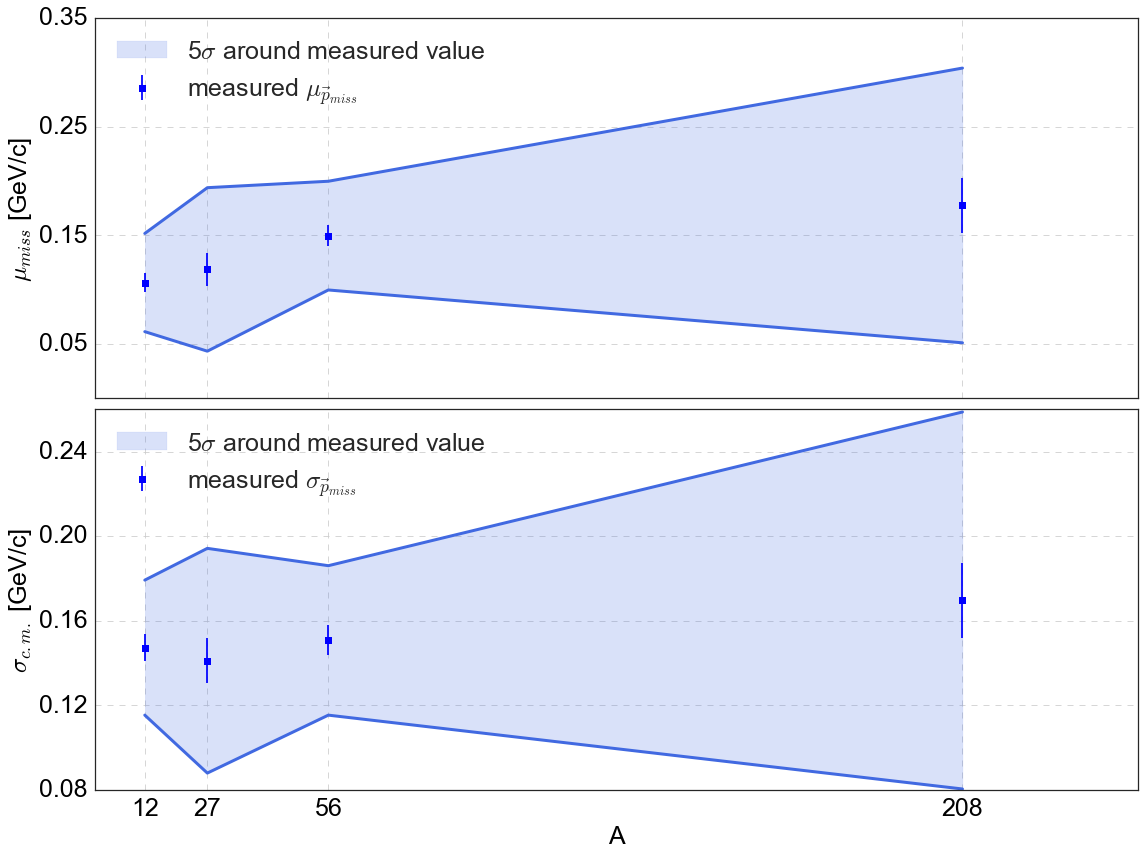

In [21]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(2,1,1)
ax.errorbar(x=cm_pars['A'],y=cm_pars['mean_z_unweighted'],yerr=cm_pars['mean_zErr_unweighted'],fmt='s'
            ,color='blue',label='measured $\\mu_{\\vec{p}_{miss}}$')
ax.fill_between(cm_pars['A']
                ,cm_pars['mean_z_unweighted']-5*cm_pars['mean_zErr_unweighted']
                ,cm_pars['mean_z_unweighted']+5*cm_pars['mean_zErr_unweighted']
                ,color='royalblue',alpha=0.2,label='5$\\sigma$ around measured value')
plt.plot(cm_pars['A'],cm_pars['mean_z_unweighted']-5*cm_pars['mean_zErr_unweighted'],'-',linewidth=3,color='royalblue')
plt.plot(cm_pars['A'],cm_pars['mean_z_unweighted']+5*cm_pars['mean_zErr_unweighted'],'-',linewidth=3,color='royalblue')

set_axes(ax,'','$\\mu_{miss}$ [GeV/c]')
ax.xaxis.set_ticks([12,27,56,208]);ax.yaxis.set_ticks([0.05,0.15,0.25,0.35]);
ax.grid(linestyle='--',alpha=0.8)
ax.legend(fontsize=25,loc='upper left')
ax.xaxis.set_major_formatter(NullFormatter())


ax = fig.add_subplot(2,1,2)
ax.errorbar(x=cm_pars['A'],y=cm_pars['sigma_z_unweighted'],yerr=cm_pars['sigma_zErr_unweighted'],fmt='s'
            ,color='blue',label='measured $\\sigma_{\\vec{p}_{miss}}$')
ax.fill_between(cm_pars['A']
                ,cm_pars['sigma_z_unweighted']-5*cm_pars['sigma_zErr_unweighted']
                ,cm_pars['sigma_z_unweighted']+5*cm_pars['sigma_zErr_unweighted']
                ,color='royalblue',alpha=0.2,label='5$\\sigma$ around measured value')
plt.plot(cm_pars['A'],cm_pars['sigma_z_unweighted']-5*cm_pars['sigma_zErr_unweighted'],'-',linewidth=3,color='royalblue')
plt.plot(cm_pars['A'],cm_pars['sigma_z_unweighted']+5*cm_pars['sigma_zErr_unweighted'],'-',linewidth=3,color='royalblue')

set_axes(ax,'A','$\\sigma_{c.m.}$ [GeV/c]')
ax.xaxis.set_ticks([12,27,56,208]);ax.yaxis.set_ticks([0.08,0.12,0.16,0.20,0.24]);
ax.grid(linestyle='--',alpha=0.8)
ax.legend(fontsize=25,loc='upper left')

plt.tight_layout()
outfilename = figures_path + 'mean_sigma_z_Adependence_band_5std_around_measured.pdf'
print 'saved',outfilename
plt.savefig(outfilename)

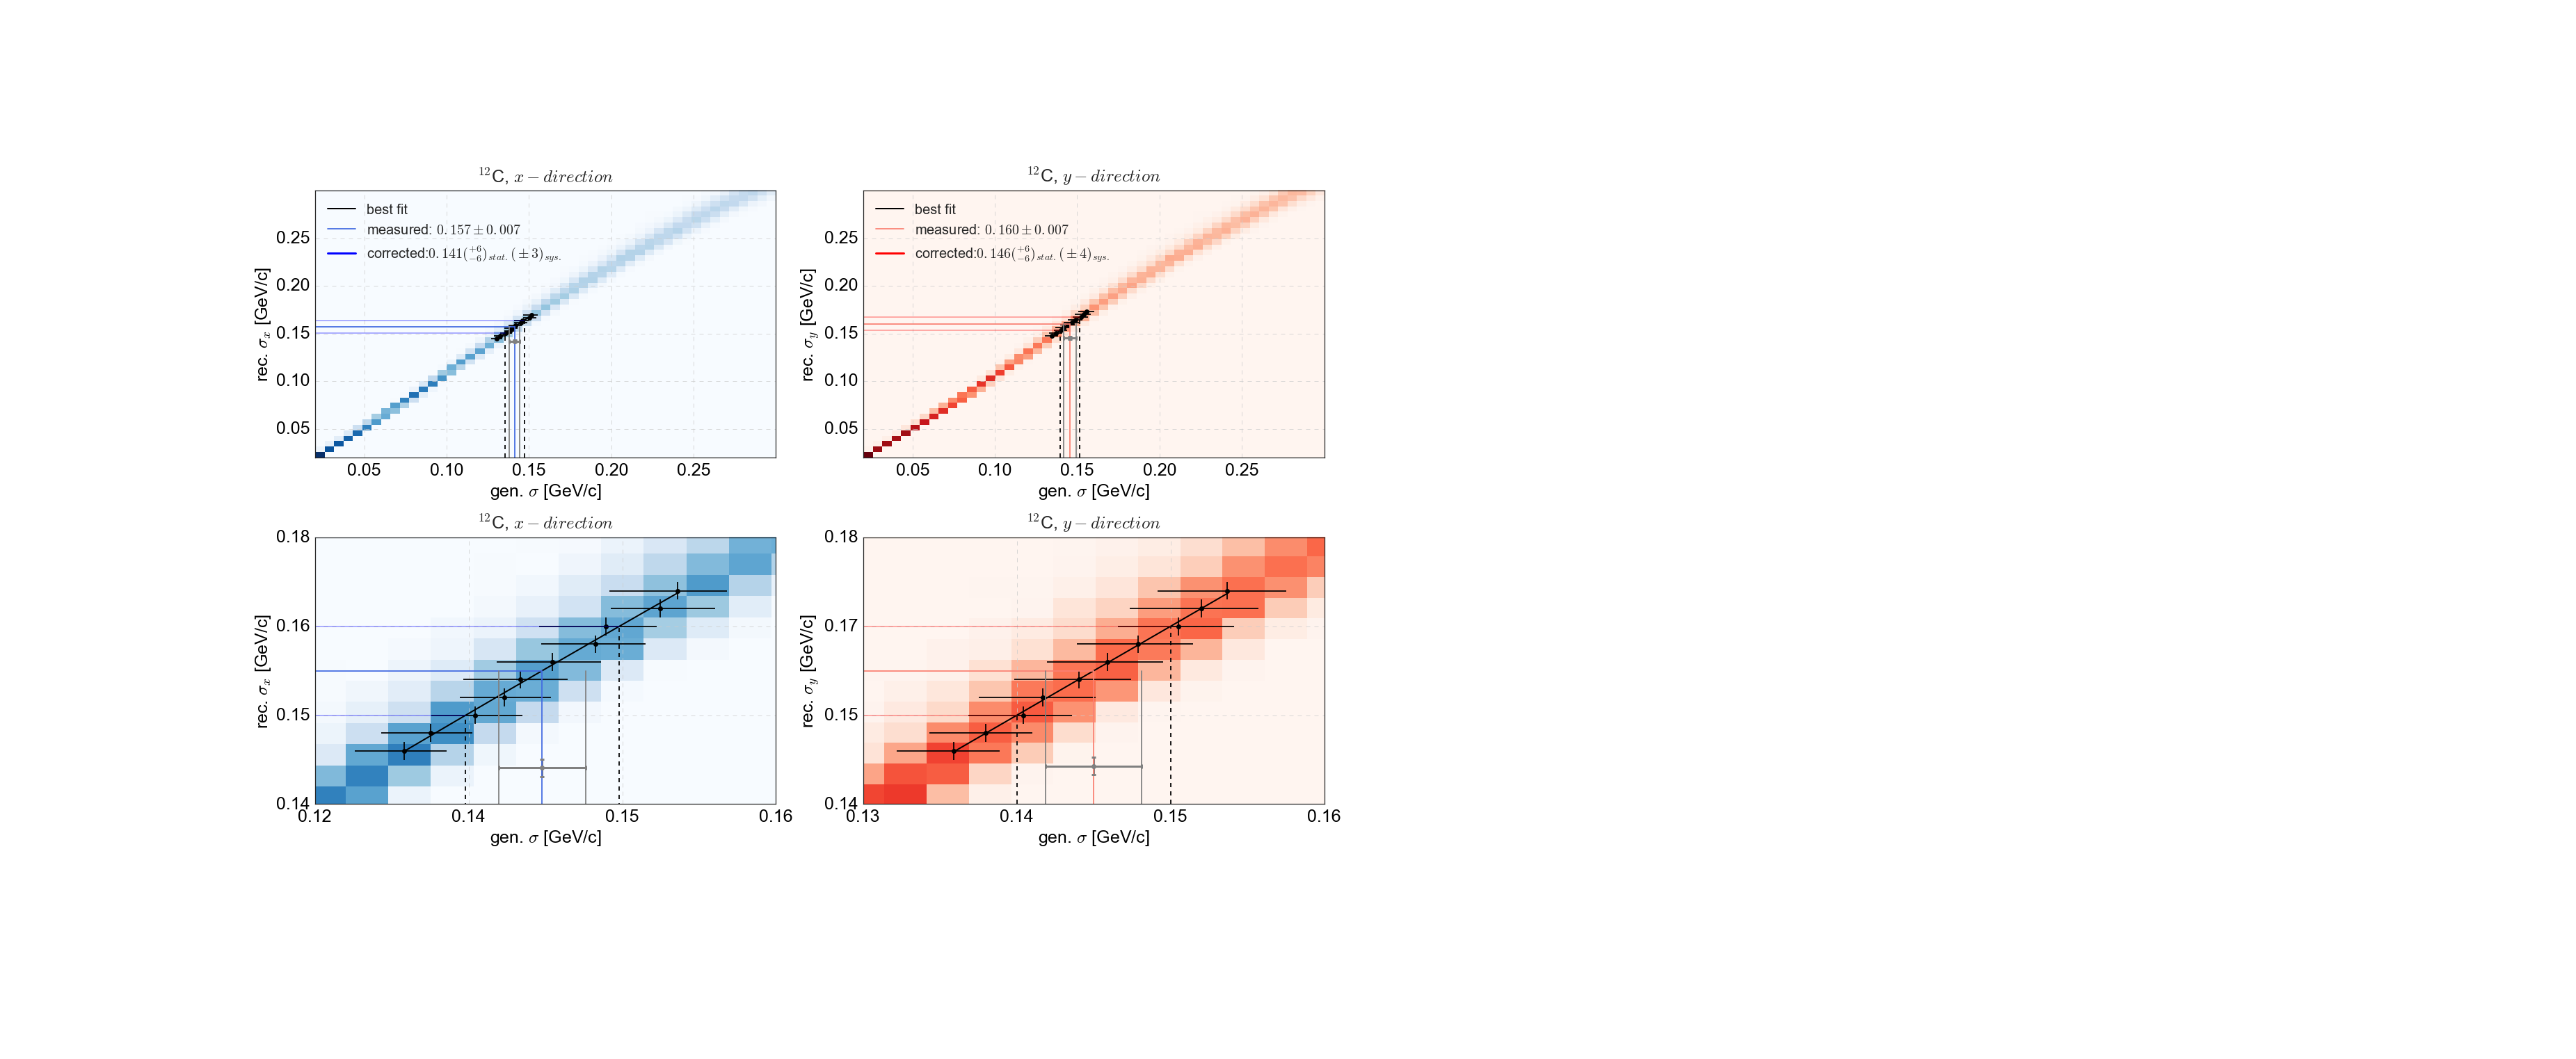

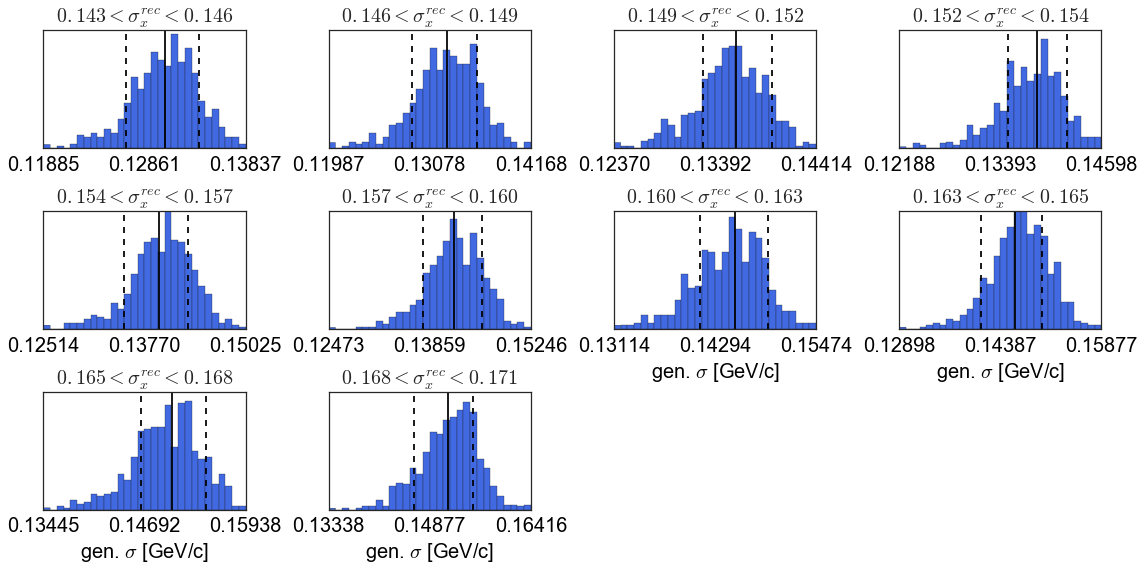

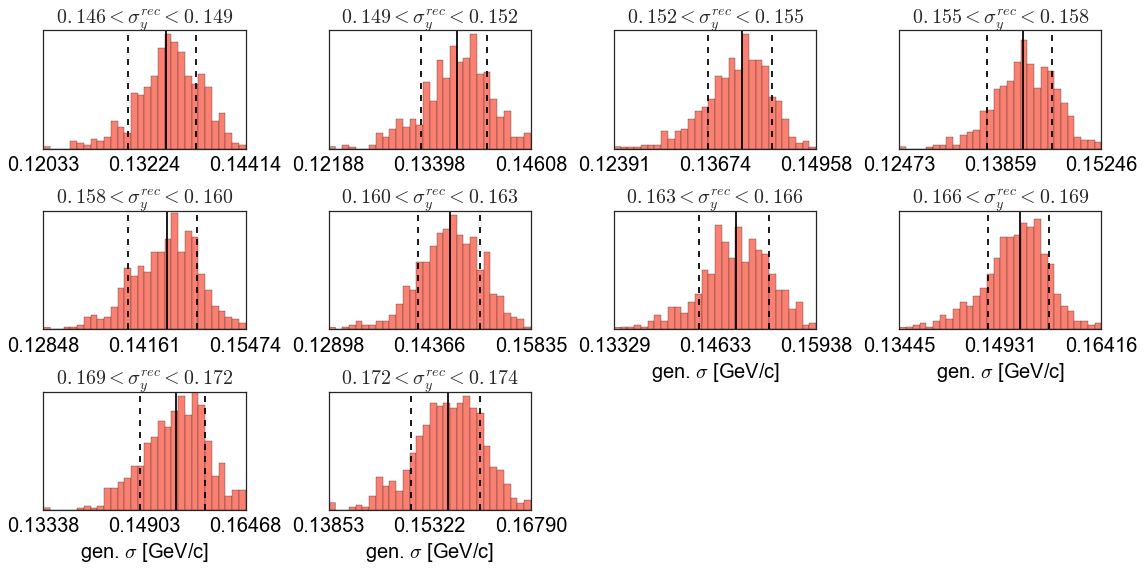

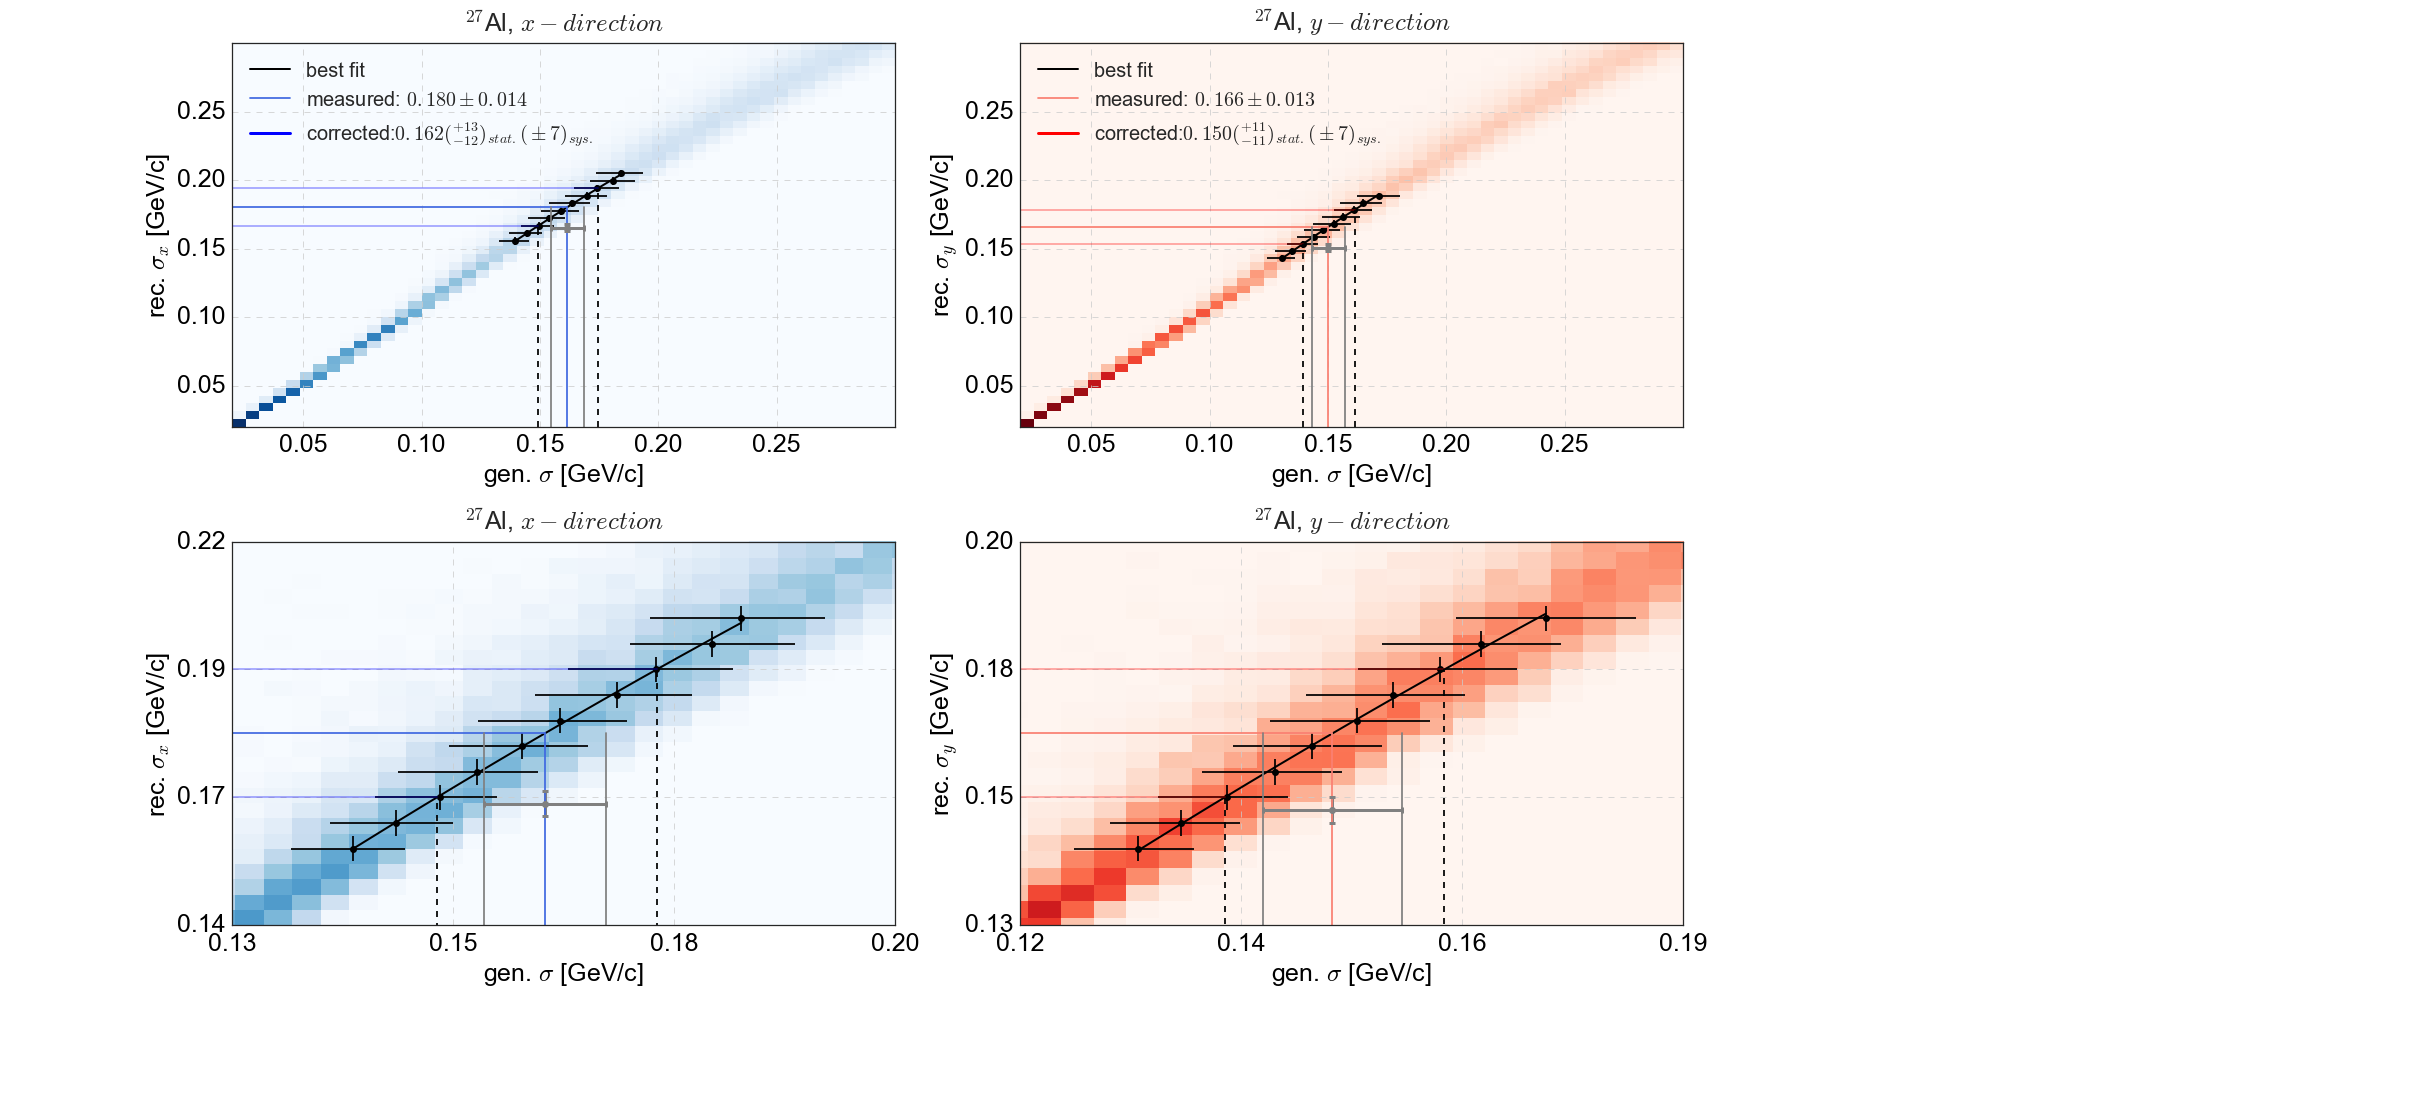

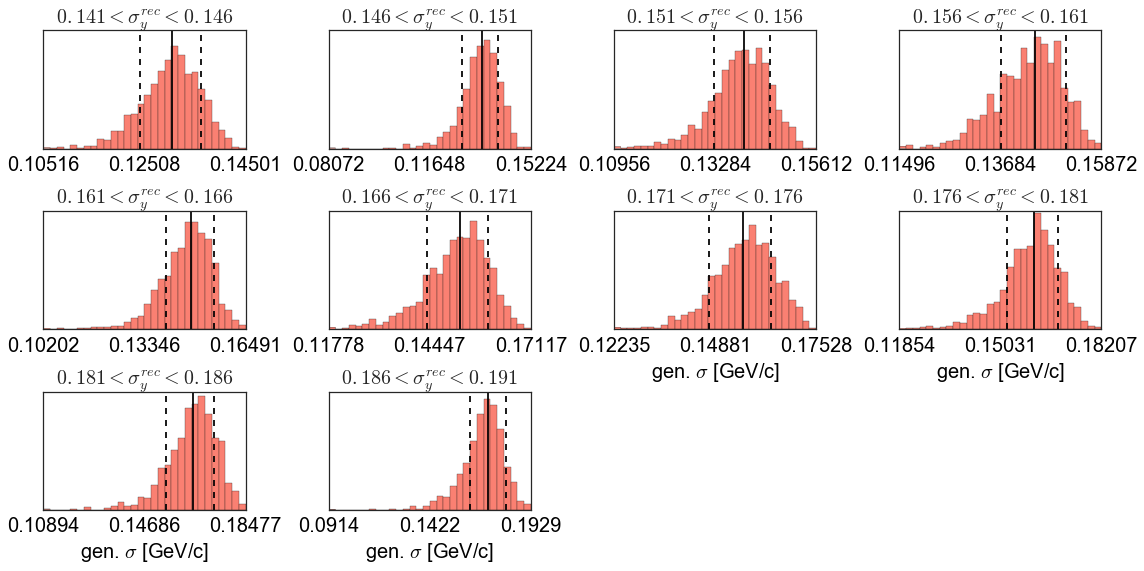

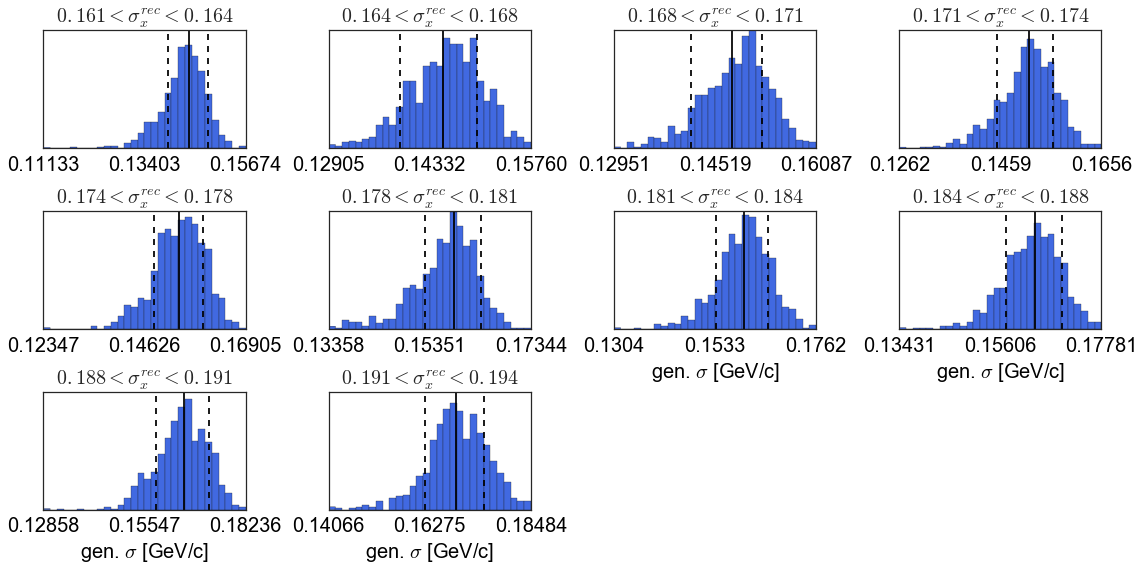

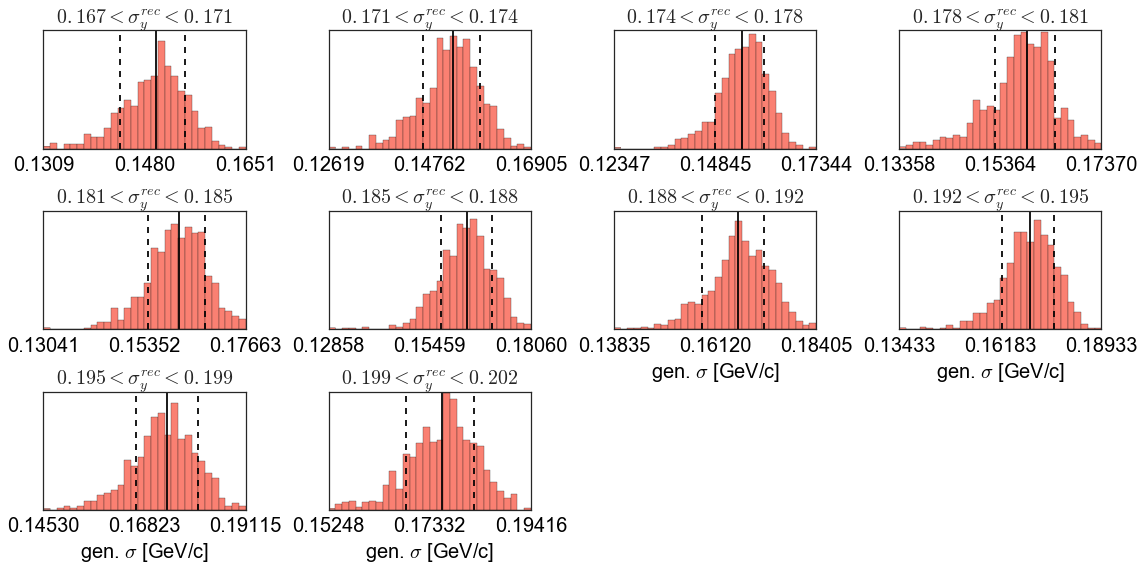

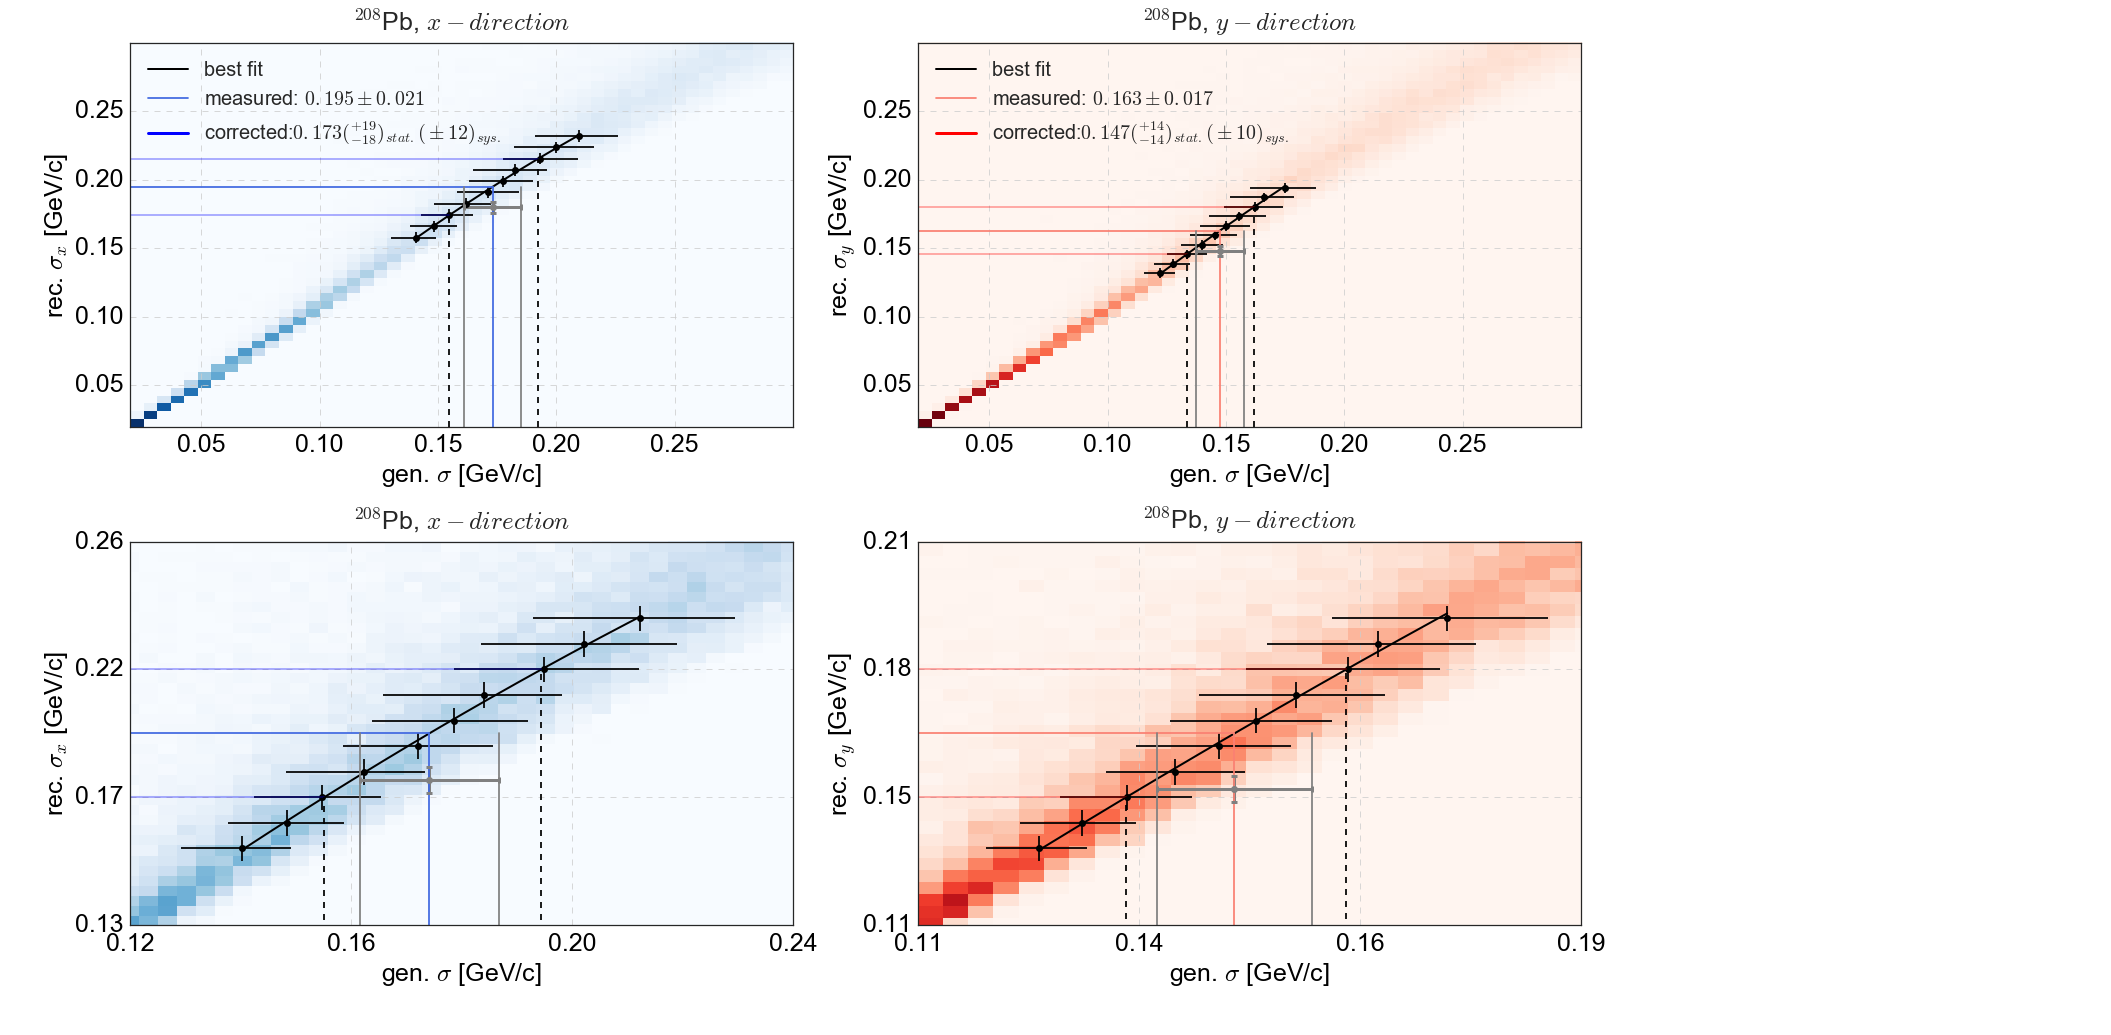

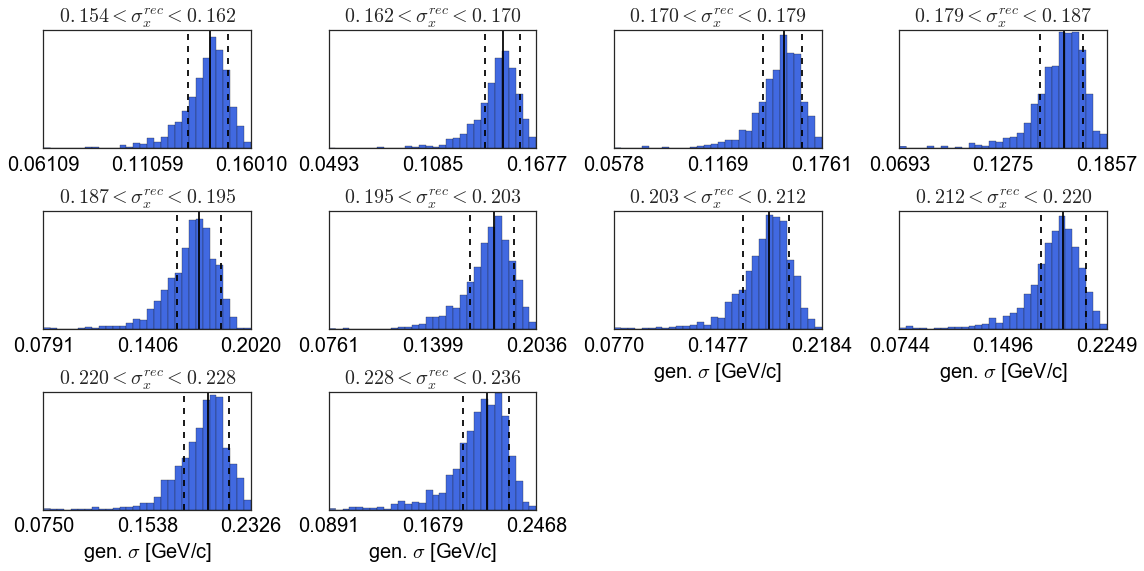

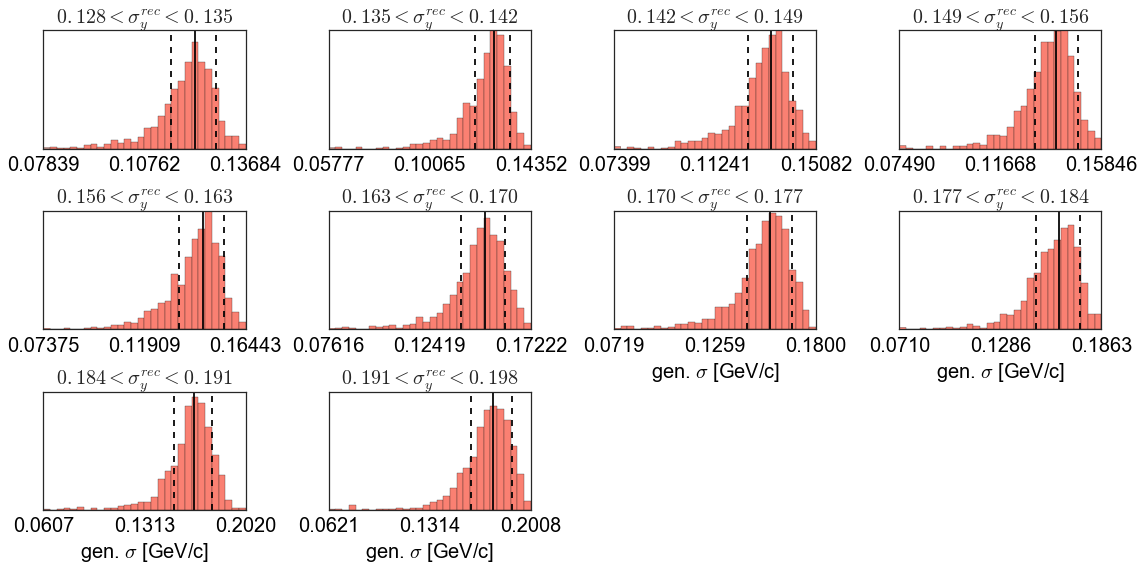

In [23]:
poly_degree = 2 # fit polynomial degree
extraname='confidence68'
for i,(A,target) in enumerate(zip(As[0:],targets[0:])):
    test_name = "simulations_"+Fiducials+"_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    fig=plt.figure(figsize=(22,14))
    ax=fig.add_subplot(2,2,1)    
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,3)    
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    ax=fig.add_subplot(2,2,2)
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,4)
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    fig.subplots_adjust(bottom=-0.5,left=-0.2)
    fig.tight_layout() 
    filename = figures_path+'St_gen_rec_'+target+'.png' if extraname=='' else figures_path+'St_gen_rec_'+target+'_'+extraname+'.png'    
    fig.savefig( filename )

In [24]:
def compute_sys_uncertainty(sims=None
                             ,Fiducials='PrecFiducials',extraname=""                              
                             ,A=12
                             ,direction='x'
                             ,Nbins_st_rec=10 # GeV/c
                             ,debug=0):
    '''
    return:
            bin width (in \sigma_rec)
            systematical uncertainty
    '''
    
    # measured \sigma_t (DATA)
    cm_pars = cm_parameters[Fiducials]        
    cm_tgt = cm_pars[cm_pars['A']==A]
    sigma_meas = float(cm_tgt['sigma_'+direction+'_before_acc_corr'])
    sigma_meas_err = float(cm_tgt['sigma_'+direction+'_before_acc_corr_err'])

    # region of interest: 2$\sigma$ around measured value
    roi_min = sigma_meas - 2*sigma_meas_err
    roi_max = sigma_meas + 2*sigma_meas_err
    roi_width = roi_max - roi_min
    # create bins in region of interest
    roi_sims = sims[(sims['rec_sigma_'+direction]>roi_min)&(sims['rec_sigma_'+direction]<roi_max)]    

    bin_st_rec_width = roi_width/Nbins_st_rec
    sims_bin_meas = roi_sims[(roi_sims['rec_sigma_'+direction]>(sigma_meas - 0.5*bin_st_rec_width))
                             &(roi_sims['rec_sigma_'+direction]<(sigma_meas + 0.5*bin_st_rec_width))]        
    bin_st_gen_mean = np.mean(sims_bin_meas['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas['gen_Sigma_t'])
    # -->
    sims_bin_meas_trimmed = sims_bin_meas[(sims_bin_meas['gen_Sigma_t']>bin_st_gen_mean-2*bin_st_gen_std)                                  
                                          &(sims_bin_meas['gen_Sigma_t']<bin_st_gen_mean+2*bin_st_gen_std)]
    bin_st_gen_mean = np.mean(sims_bin_meas_trimmed['gen_Sigma_t'])
    bin_st_gen_std = np.std(sims_bin_meas_trimmed['gen_Sigma_t'])
    corr_val_err_sys = bin_st_gen_std 
    
    return bin_st_rec_width , corr_val_err_sys

In [25]:
bin_width_x = dict()
sys_unc_x = dict()

bin_width_y = dict()
sys_unc_y = dict()

fig = plt.figure(figsize=(16,8))

for i,(A,target,color) in enumerate(zip(As[0:],targets[0:],colors[0:])):
    print 'target:',target
#     test_name = "ModifiedNrand_"+target
    test_name = "simulations_"+Fiducials+"_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]

    bin_width_x[target] = []
    sys_unc_x[target] = []
    bin_width_y[target] = []
    sys_unc_y[target] = []

    for Nbins_st_rec in [4,5,6,7,8,9,10,11,12,13,14,15,16]:
        bin_st_rec_width_x , corr_val_err_sys_x = compute_sys_uncertainty(sims=good_results
                                                                          ,A=A,direction='x',debug=0
                                                                          ,Nbins_st_rec=Nbins_st_rec)
        bin_width_x[target].append(bin_st_rec_width_x)
        sys_unc_x[target].append(corr_val_err_sys_x)
        
        bin_st_rec_width_y , corr_val_err_sys_y = compute_sys_uncertainty(sims=good_results
                                                                          ,A=A,direction='y',debug=0
                                                                          ,Nbins_st_rec=Nbins_st_rec)
        bin_width_y[target].append(bin_st_rec_width_y)
        sys_unc_y[target].append(corr_val_err_sys_y)
        
        if Nbins_st_rec==10:
            ax = fig.add_subplot(1,2,1)
            ax.plot([1000*bin_st_rec_width_x,1000*bin_st_rec_width_x],[0,1000*corr_val_err_sys_x],'--',color=color)
            ax = fig.add_subplot(1,2,2)
            ax.plot([1000*bin_st_rec_width_y,1000*bin_st_rec_width_y],[0,1000*corr_val_err_sys_y],'--',color=color)


        
    ax = fig.add_subplot(1,2,1)
    ax.plot(1000*np.array(bin_width_x[target]),1000*np.array(sys_unc_x[target]),'-o',label=target,color=color)
    ax = fig.add_subplot(1,2,2)
    ax.plot(1000*np.array(bin_width_y[target]),1000*np.array(sys_unc_y[target]),'-o',label=target,color=color)

ax = fig.add_subplot(1,2,1)
set_axes(ax,'bin width [MeV/c]',r'$\Delta_{sys.}^{x}$ [MeV/c]',do_add_legend=True,do_add_grid=True)
ax = fig.add_subplot(1,2,2)
set_axes(ax,'bin width [MeV/c]',r'$\Delta_{sys.}^{y}$ [MeV/c]',do_add_legend=True,do_add_grid=True)

plt.tight_layout()
plt.savefig(figures_path + 'Delta_sys_vs_bin_width.pdf')

target: C
target: Al
target: Fe
target: Pb


# Compute the final $\sigma_t$

In [26]:
sample = cm_parameters_with_correction['PrecFiducials']
extraname = 'confidence68'

for direction in ['x','y']:
    sample['sigma_'+direction+extraname+'_final'] = sample['sigma_'+direction+'_corrected'+extraname]
    for updw in ['up','dw']:
        sample['sigma_'+direction+extraname+'_final_'+updw+'_err'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot'+extraname]

corr_x = sample['sigma_x_corrected'+extraname]
Dcorr_x = sample['sigma_x_corrected_err_tot'+extraname]
sample['sigma_x_final_Err'+extraname] = sample['sigma_x_corrected_err_tot'+extraname]

corr_y = sample['sigma_y_corrected'+extraname]
Dcorr_y = sample['sigma_y_corrected_err_tot'+extraname]
sample['sigma_y_final_Err'+extraname] = sample['sigma_y_corrected_err_tot'+extraname]


# weighted average
corr_t = (corr_x/np.square(Dcorr_x)+corr_y/np.square(Dcorr_y))/( 1./np.square(Dcorr_x) + 1./np.square(Dcorr_y))
sample['sigma_t'+extraname+'_final'] = corr_t
    
Dsys_x = sample['sigma_x_corrected_err_sys'+extraname]
Dsys_y = sample['sigma_y_corrected_err_sys'+extraname]
Dsys_t = 0.5*( Dsys_x + Dsys_y )
# Dsys_t = np.sqrt(1./( 1./np.square(Dsys_x) + 1./np.square(Dsys_y) ))
sample['sigma_t'+extraname+'_final_err_sys'] = Dsys_t


for updw in ['up','dw']:            
    Dstat_x = sample['sigma_x_corrected_'+updw+'_err_stat'+extraname]
    Dstat_y = sample['sigma_y_corrected_'+updw+'_err_stat'+extraname]
    #     Dstat_t = 0.5*np.sqrt( np.square(Dstat_x) + np.square(Dstat_y) )
    Dstat_t = np.sqrt(1./( 1./np.square(Dstat_x) + 1./np.square(Dstat_y) ))
    sample['sigma_t'+extraname+'_final_'+updw+'_err_stat'] = Dstat_t

    Dtot_t = np.sqrt( np.square(Dstat_t) + np.square(Dsys_t) )
    sample['sigma_t'+extraname+'_final_'+updw+'_err_tot'] = Dtot_t
    sample['sigma_t'+extraname+'_final_'+updw+'_err'] = Dtot_t



In [50]:
sample.columns

Index([u'Nevts', u'chi2red_x_unweighted', u'chi2red_y_unweighted',
       u'chi2red_z_unweighted', u'mean_xErr_unweighted', u'mean_x_unweighted',
       u'mean_yErr_unweighted', u'mean_y_unweighted', u'mean_zErr_unweighted',
       u'mean_z_unweighted', u'ndof_x_unweighted', u'ndof_y_unweighted',
       u'ndof_z_unweighted', u'sigma_xErr_unweighted', u'sigma_x_unweighted',
       u'sigma_yErr_unweighted', u'sigma_y_unweighted',
       u'sigma_zErr_unweighted', u'sigma_z_unweighted', u'target', u'A',
       u'sigma_x_before_acc_corr', u'sigma_x_before_acc_corr_err',
       u'sigma_y_before_acc_corr', u'sigma_y_before_acc_corr_err',
       u'sigma_t_before_acc_corr', u'sigma_t_before_acc_corr_err',
       u'sigma_x_correctedconfidence68',
       u'sigma_x_corrected_up_err_statconfidence68',
       u'sigma_x_corrected_dw_err_statconfidence68',
       u'sigma_x_corrected_err_sysconfidence68',
       u'sigma_x_corrected_up_err_totconfidence68',
       u'sigma_x_corrected_dw_err_totconfidenc

In [76]:
sample['sigma_x_final'] = sample['sigma_xconfidence68_final']
sample['sigma_x_final_up_err'] = sample['sigma_xconfidence68_final_up_err']
sample['sigma_x_final_dw_err'] = sample['sigma_xconfidence68_final_dw_err']
sample['sigma_x_final_Err'] = sample[u'sigma_x_final_Errconfidence68']

sample['sigma_y_final'] = sample['sigma_yconfidence68_final']
sample['sigma_y_final_up_err'] = sample['sigma_yconfidence68_final_up_err']
sample['sigma_y_final_dw_err'] = sample['sigma_yconfidence68_final_dw_err']
sample['sigma_y_final_Err'] = sample[u'sigma_y_final_Errconfidence68']




sample['sigma_t_final'] = sample['sigma_tconfidence68_final']
sample['sigma_t_final_err_sys'] = sample['sigma_tconfidence68_final_err_sys']
sample['sigma_t_final_up_err_stat'] = sample['sigma_tconfidence68_final_up_err_stat']
sample['sigma_t_final_dw_err_stat'] = sample['sigma_tconfidence68_final_up_err_stat']
sample['sigma_t_final_up_err'] = sample['sigma_tconfidence68_final_up_err']
sample['sigma_t_final_dw_err'] = sample['sigma_tconfidence68_final_dw_err']

sample['sigma_t_final_up_err_tot'] = sample['sigma_tconfidence68_final_up_err']
sample['sigma_t_final_dw_err_tot'] = sample['sigma_tconfidence68_final_dw_err']

In [77]:
cm_parameters_with_correction['PrecFiducials'][['sigma_t_before_acc_corr','sigma_t_before_acc_corr_err'
                                                ,'sigma_t_final'
                                                ,'sigma_t_final_up_err','sigma_t_final_dw_err']].astype(float)

sigma_t_before_acc_corr  sigma_t_before_acc_corr_err  sigma_t_final  \
0                 0.158720                     0.004904       0.143316   
1                 0.172366                     0.009252       0.155218   
2                 0.180959                     0.006040       0.159014   
3                 0.176265                     0.013257       0.157168   

   sigma_t_final_up_err  sigma_t_final_dw_err  
0              0.005485              0.005469  
1              0.010951              0.010709  
2              0.007414              0.007359  
3              0.016024              0.015681

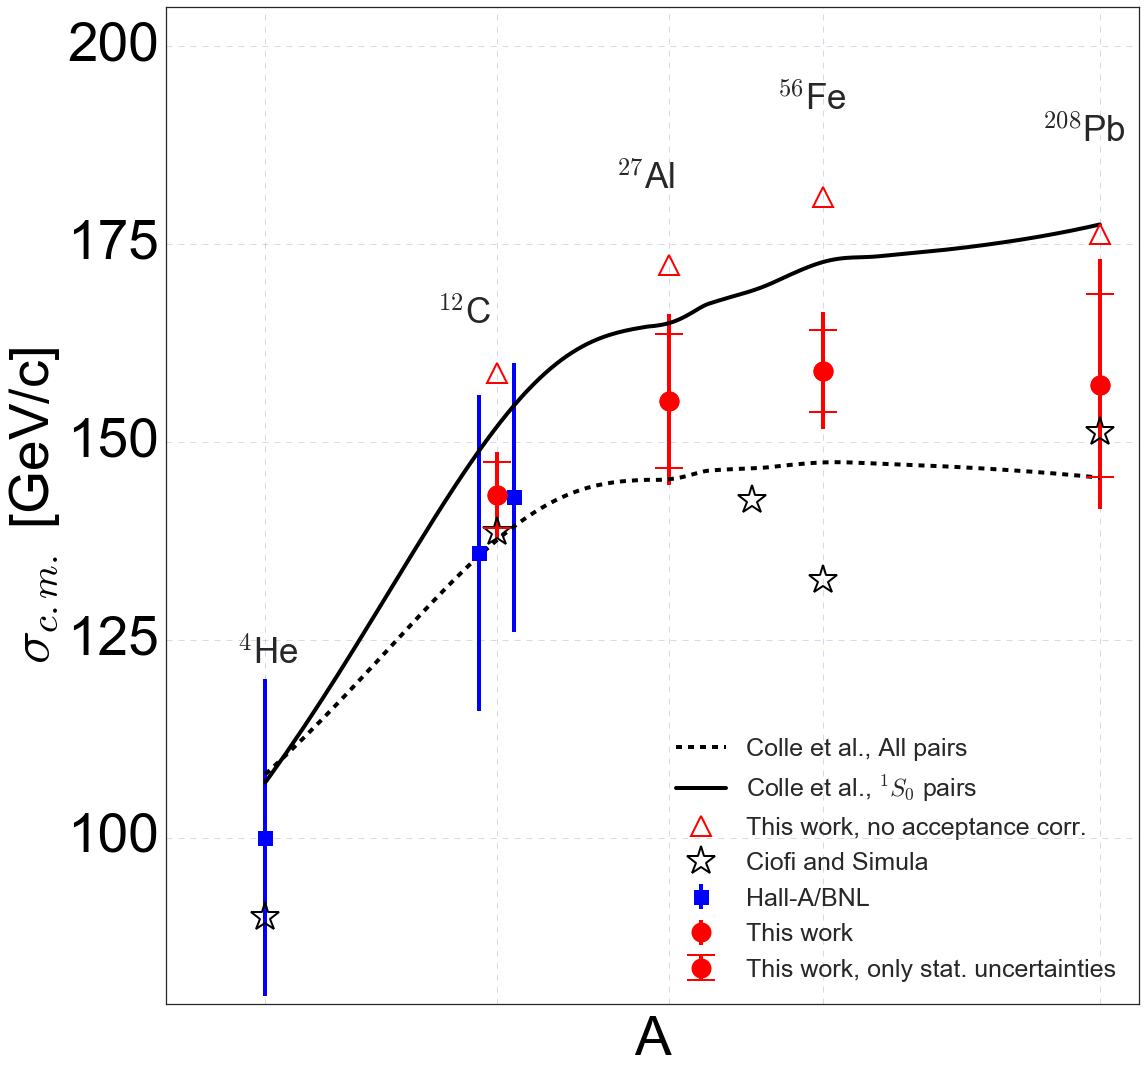

In [78]:
extraname=''
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(158,188), }),do_Ciofi=True)

plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],direction='t',ax=ax, label="This work" , marker='o', markersize=20 )
plt.legend(fontsize=20,loc='upper left')
# measured
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'] ,direction='t', unc_name='stat' , ax=ax, label="This work, only stat. uncertainties" , marker='o', markersize=20 , capthick=2 , capsize=14)

ax.legend(fontsize=25,loc='lower right')
plt.tight_layout()
plt.savefig(figures_path +'results.pdf')    

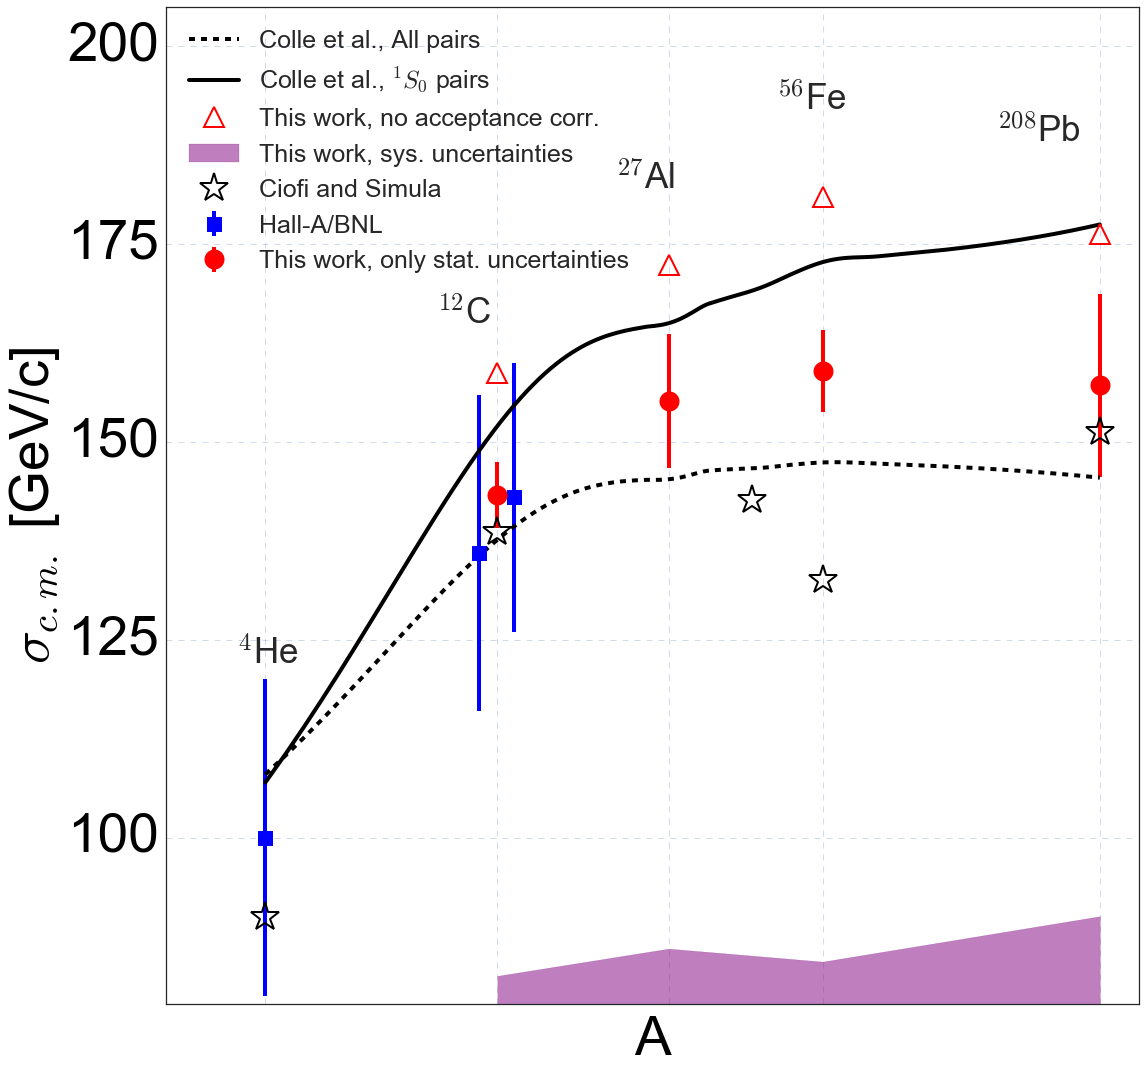

In [79]:
# separate sys. unc. as a band along the abscissa
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(128,188), }),do_Ciofi=True)
data=cm_parameters_with_correction['PrecFiducials']
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'] ,direction='t', unc_name='stat' , ax=ax, label="This work, only stat. uncertainties" , marker='o', markersize=20 )
plt.legend(fontsize=20,loc='upper left')
# measured
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
[]
# add a band of systematical uncertaintes
ax.fill_between(cm_pars['A']
                , np.min(ax.get_ylim()), np.min(ax.get_ylim()) + 1000*data['sigma_t_final_err_sys'] 
                , color='purple' , alpha=0.5 ,  label='This work, sys. uncertainties')

ax.legend(fontsize=25,loc='upper left')
plt.tight_layout()
plt.savefig(figures_path+'results_sys_band.pdf')    

# $x$ and $y$ directions seperately

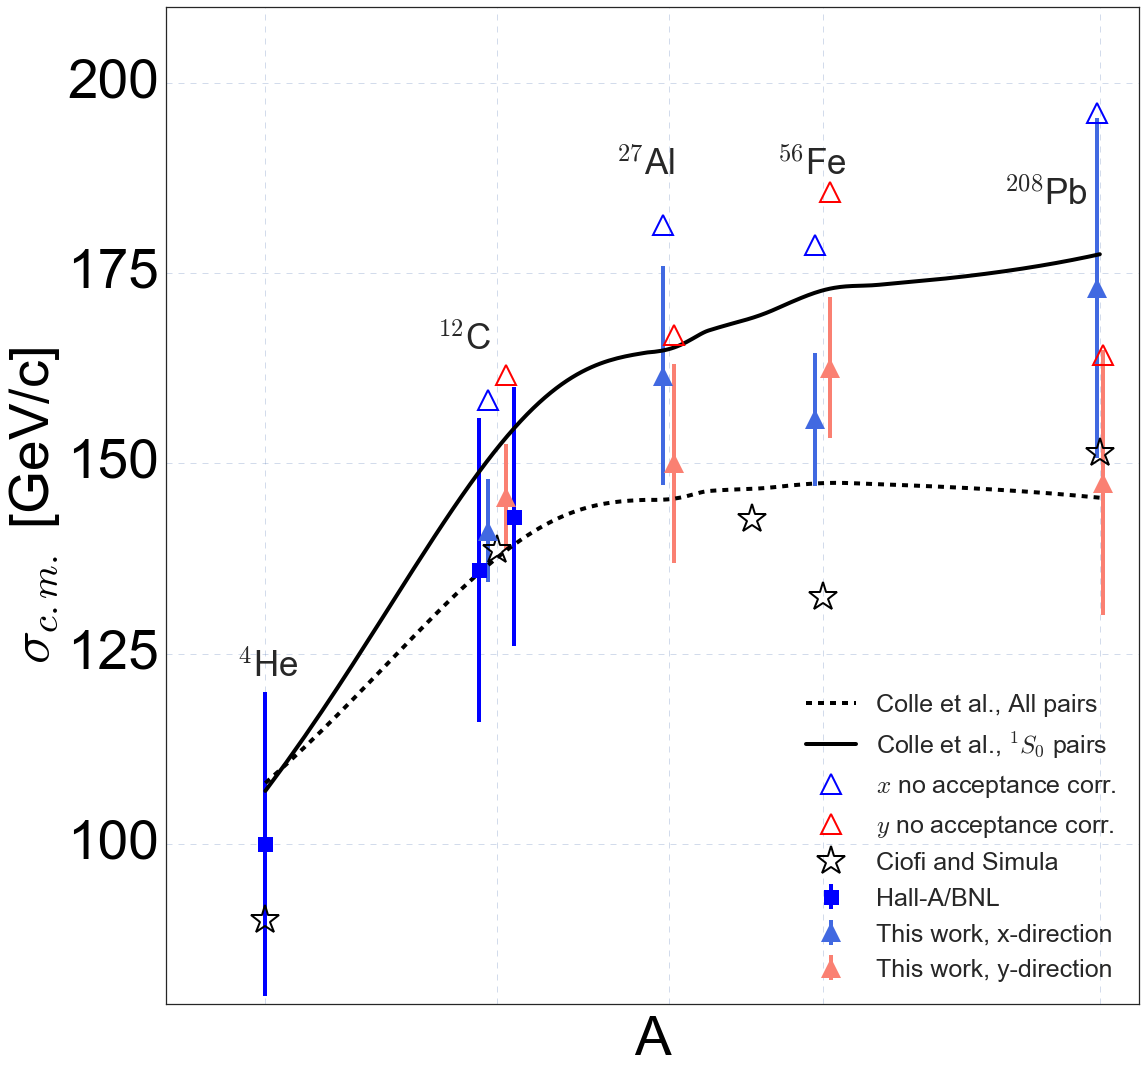

In [80]:
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,210),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165),
                                            '$^{27}$Al':(21,188),
                                            '$^{56}$Fe':(45,188),
                                            '$^{208}$Pb':(132,184),
                                           }))
ax.plot(cm_pars['A']+[-0.5,-0.7,-2,-3], 1000*cm_pars['sigma_x_unweighted'] ,mec='blue' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='$x$ no acceptance corr.')
plot_data( data=cm_parameters_with_correction['PrecFiducials'], ax=ax, Ashift=[-0.5,-0.7,-2,-3] , direction='x', label='This work, x-direction', color='royalblue',markersize=20 )
ax.plot(cm_pars['A']+[0.5,0.7,2,3], 1000*cm_pars['sigma_y_unweighted'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='$y$ no acceptance corr.')
plot_data( data=cm_parameters_with_correction['PrecFiducials'], ax=ax, Ashift=[0.5,0.7,2,3] ,direction='y', label='This work, y-direction', color='salmon', markersize=20 )
ax.legend(fontsize=25,loc='lower right')
plt.tight_layout()
plt.savefig( figures_path + 'corrected_sigma_xy_with_calculations.pdf')

# compare with previous results presented in WI

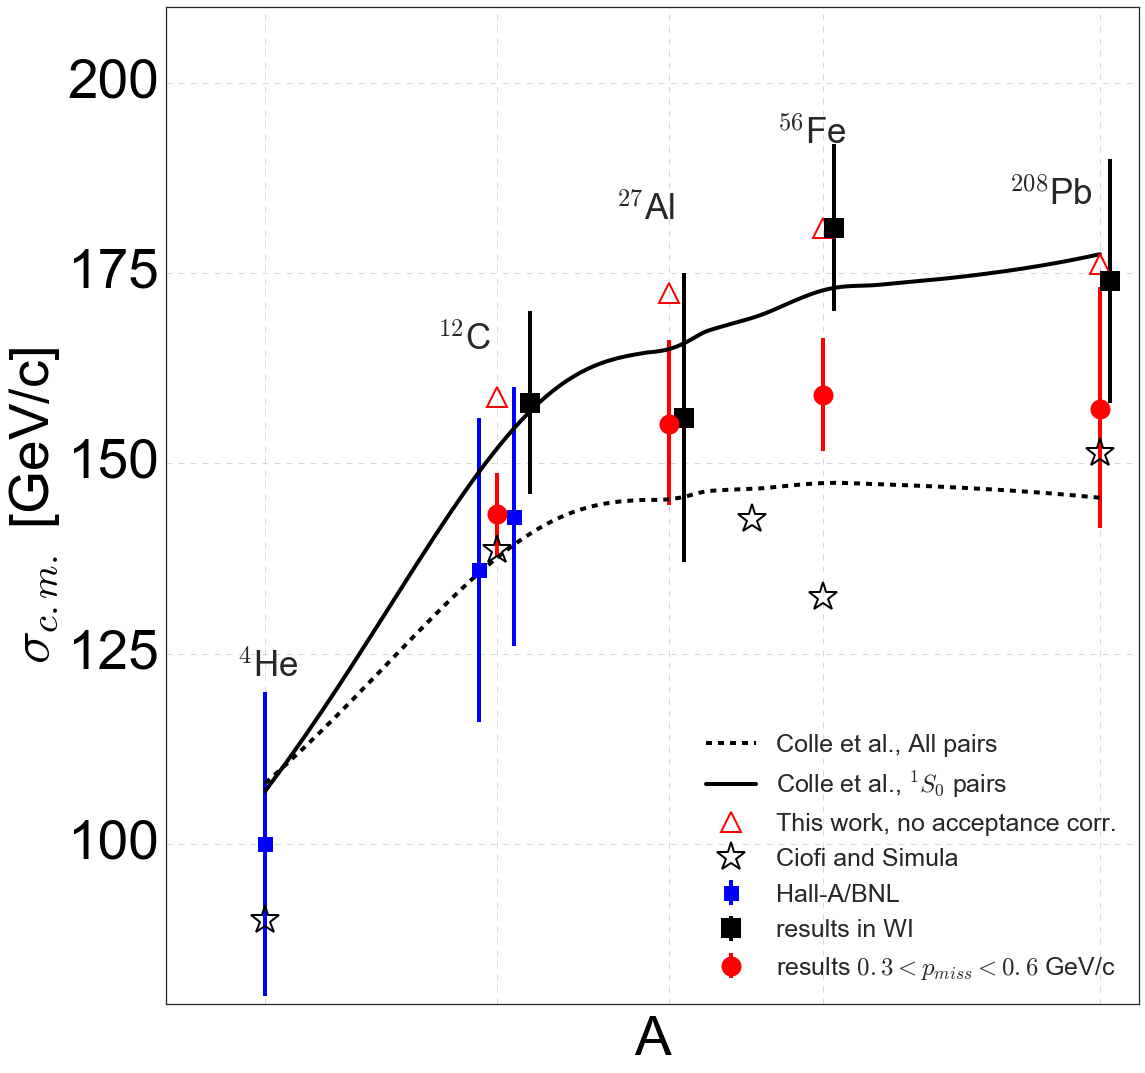

In [58]:
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,210),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(135,184), }))
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
plot_data( data=WI_Data, ax=ax,label='results in WI',Ashift=[2,2,3,10],  markersize=20 , marker='s', color='black')
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],ax=ax, label='results $0.3<p_{miss}<0.6$ GeV/c', marker='o', markersize=20 )
ax.legend(fontsize=25, loc='lower right')
plt.tight_layout()
plt.savefig( figures_path + 'corrected_sigma_t_vs_WI_results.pdf')

# Fiducial cuts vs. no Fiducial cuts

In [59]:
for Fiducials in ["NoPrecFiducials"]:
    for A,target in zip(As,targets):
        test_name = Fiducials+"_"+target
        simulation_results[test_name] = pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/final_simualtions_300Pmiss600/"+test_name+".csv")
        simulation_results[test_name].fillna(-1,inplace=True)
        print len(simulation_results[test_name]),'events in ',test_name

38400 events in  NoPrecFiducials_C
38400 events in  NoPrecFiducials_Al
38400 events in  NoPrecFiducials_Fe
23531 events in  NoPrecFiducials_Pb


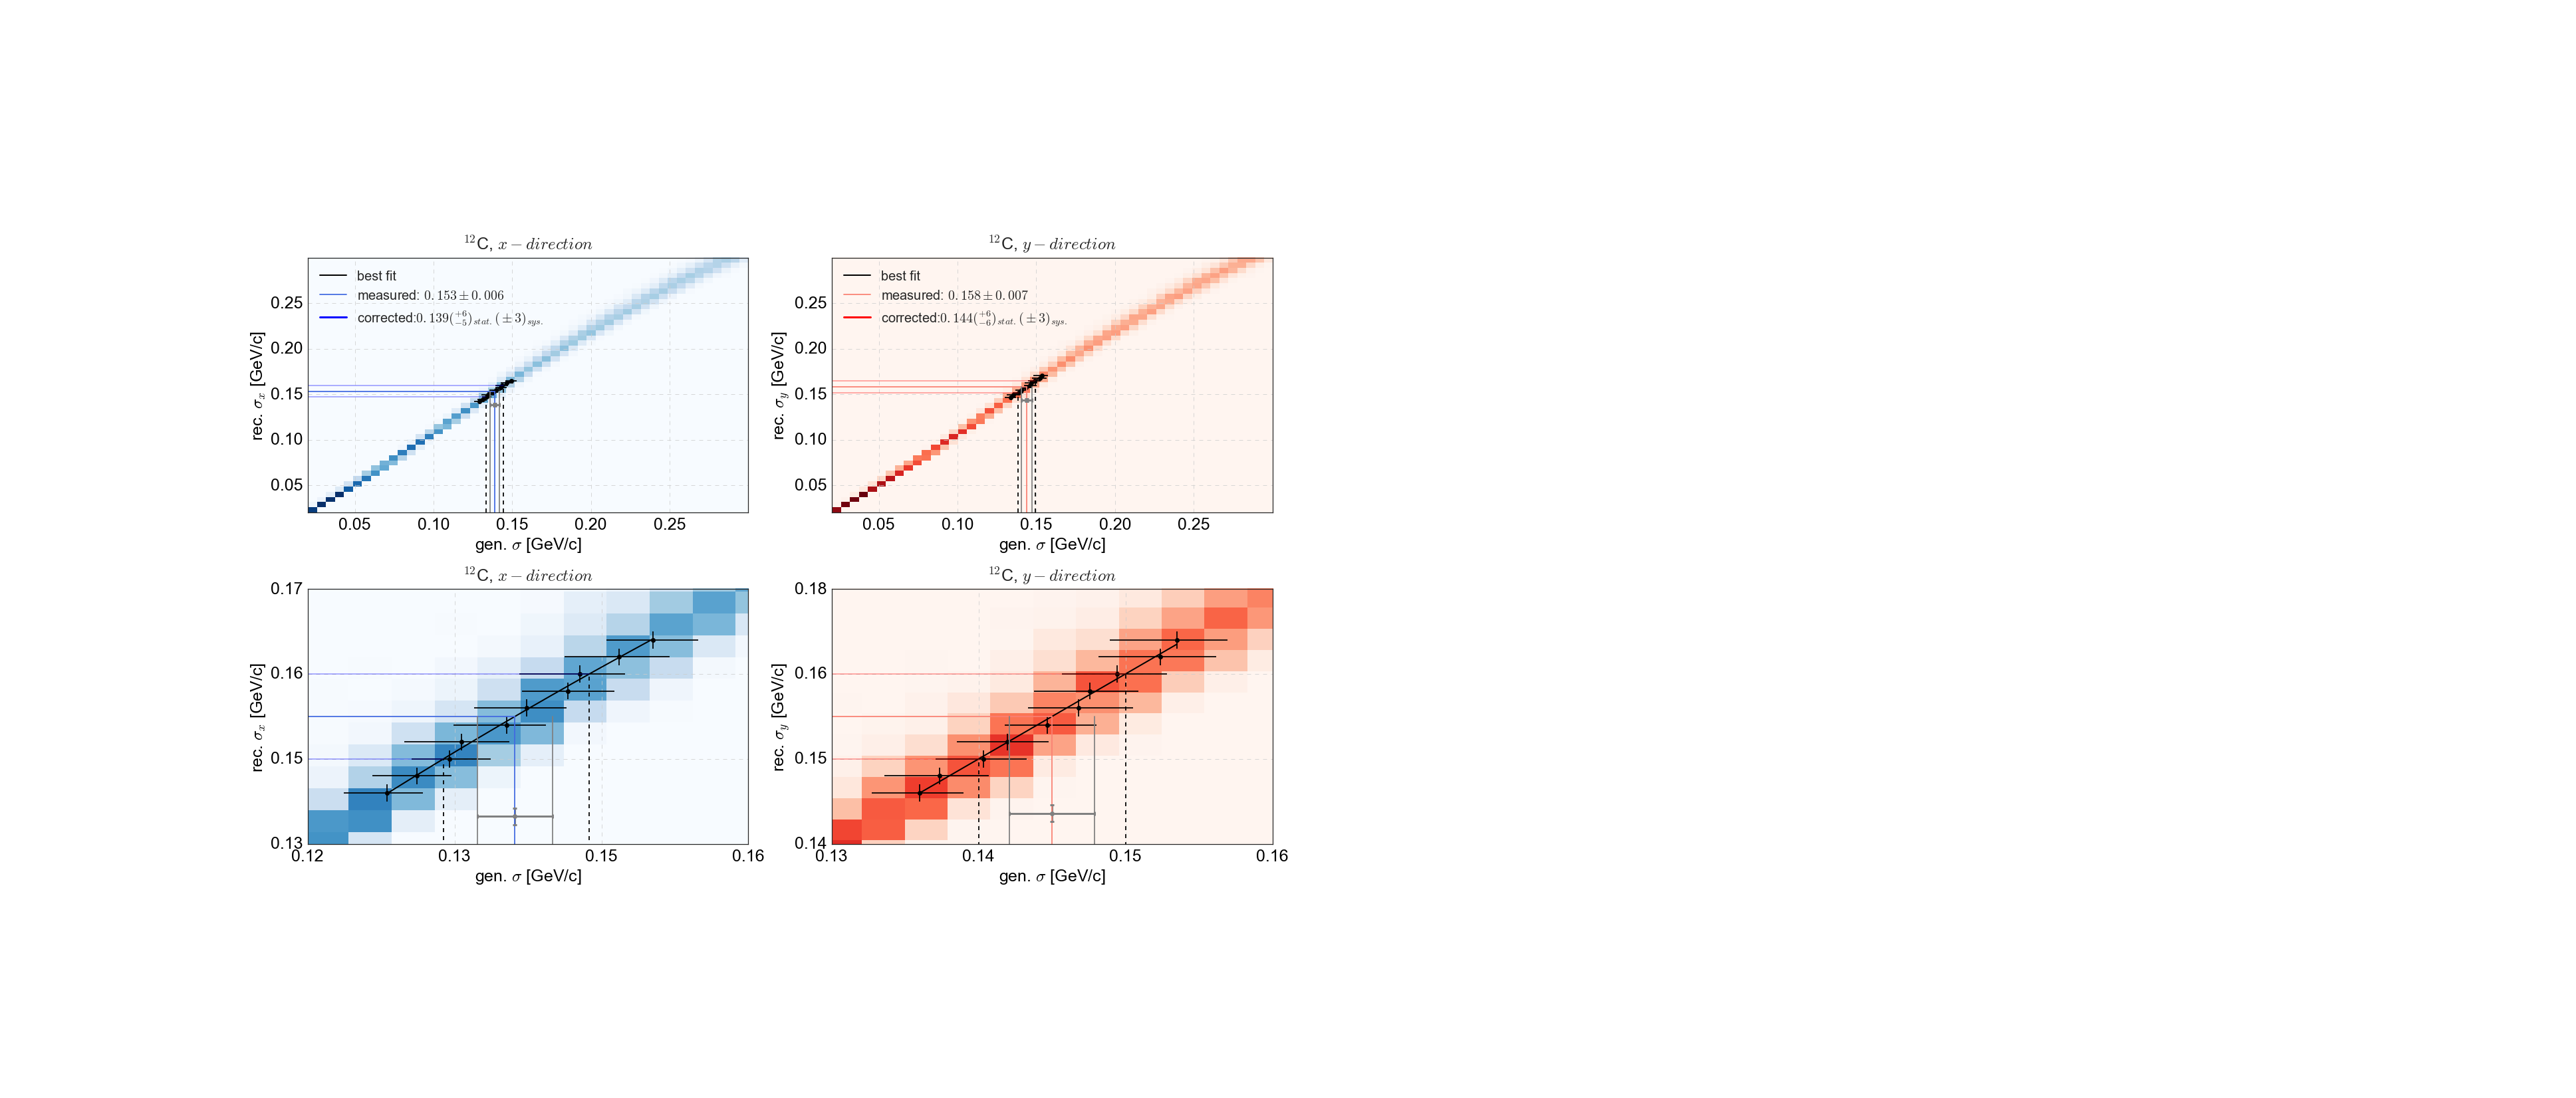

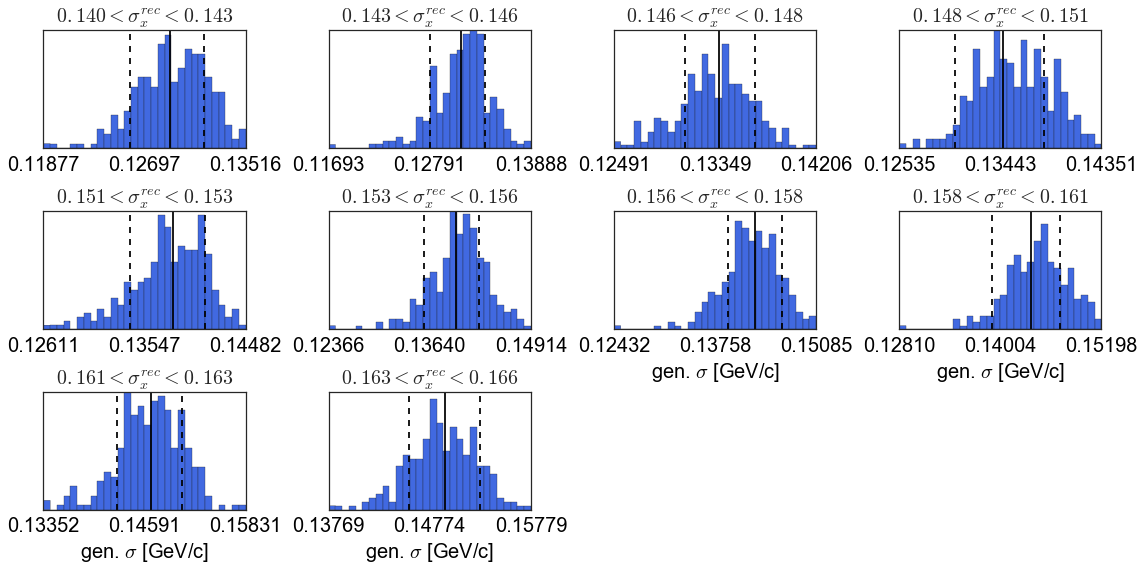

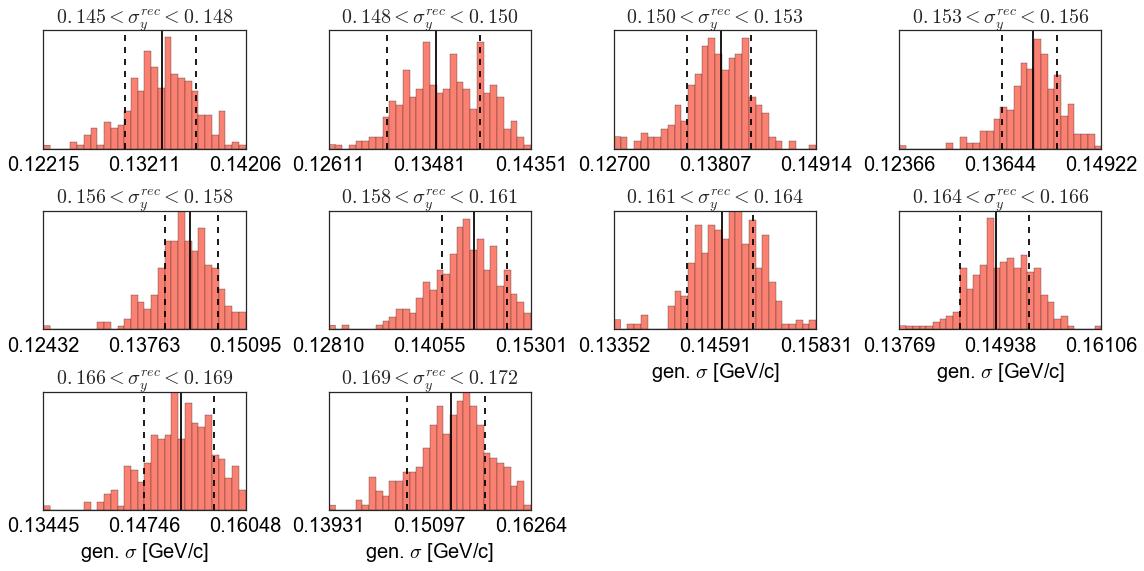

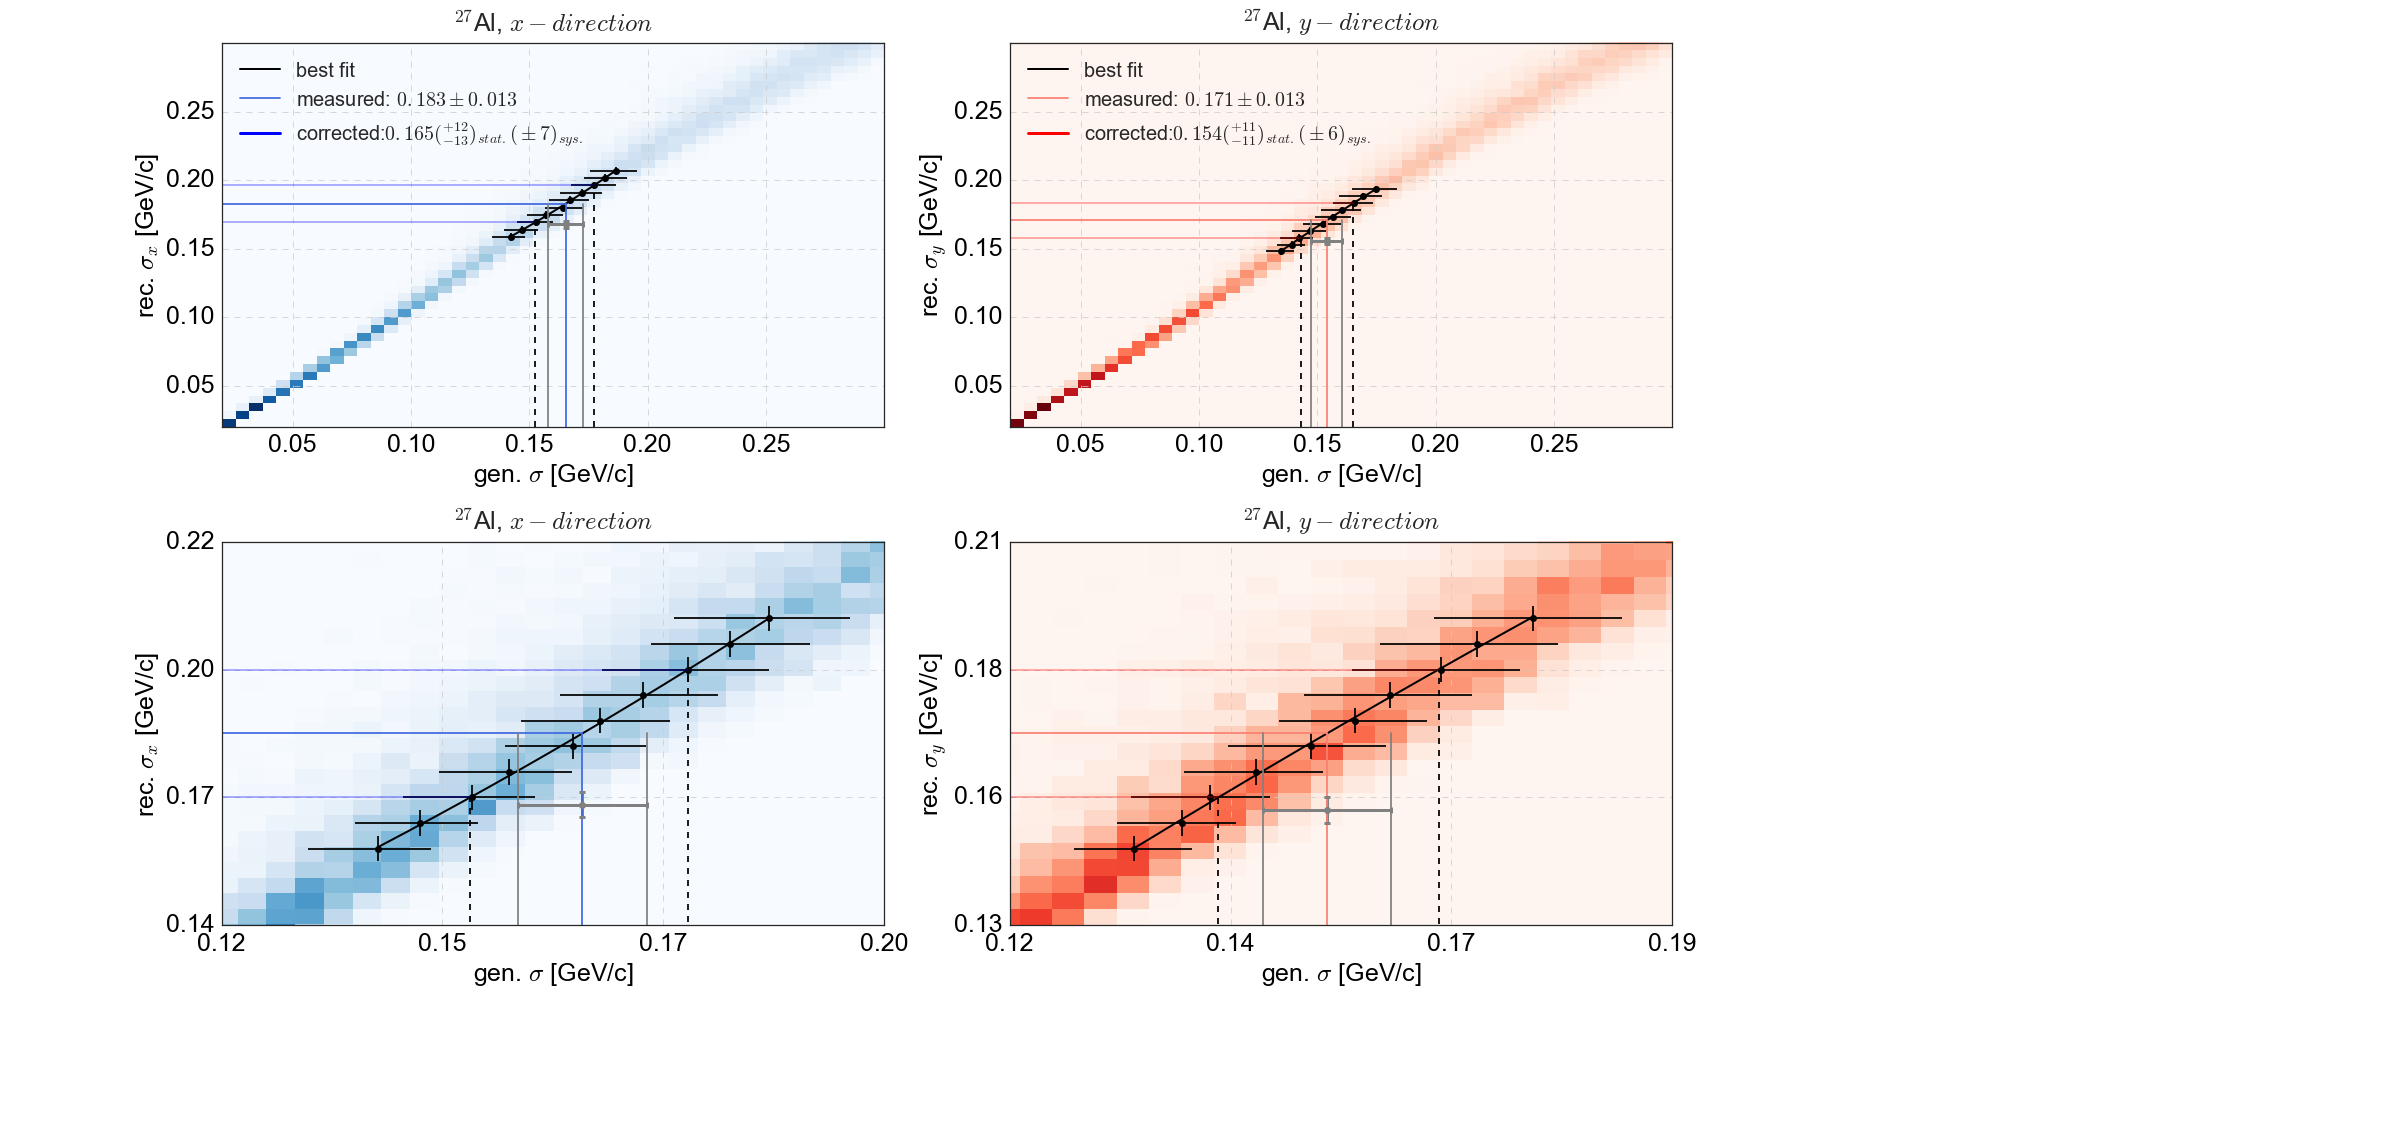

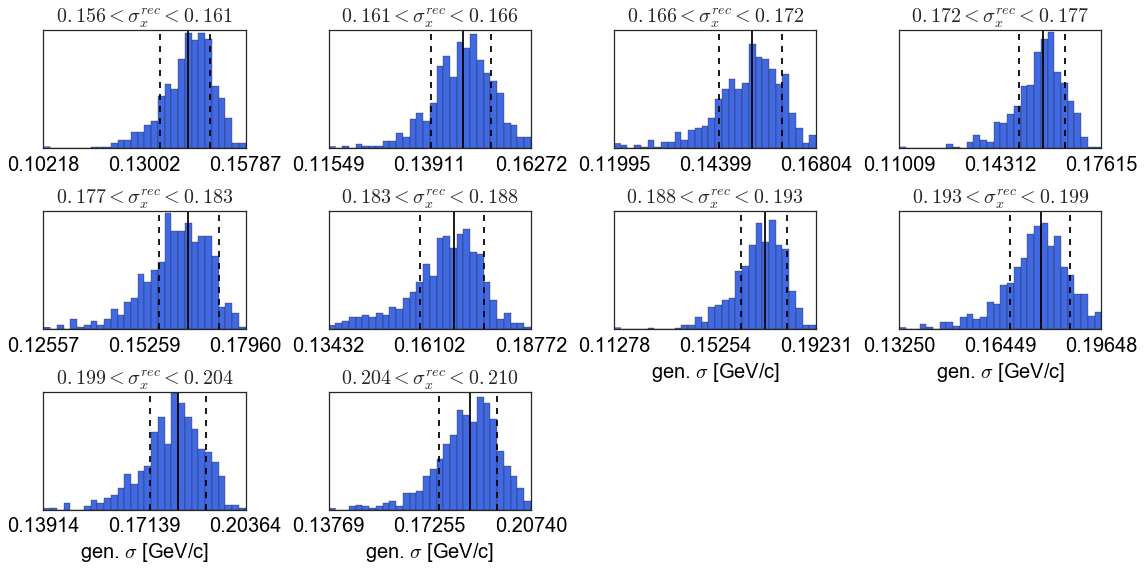

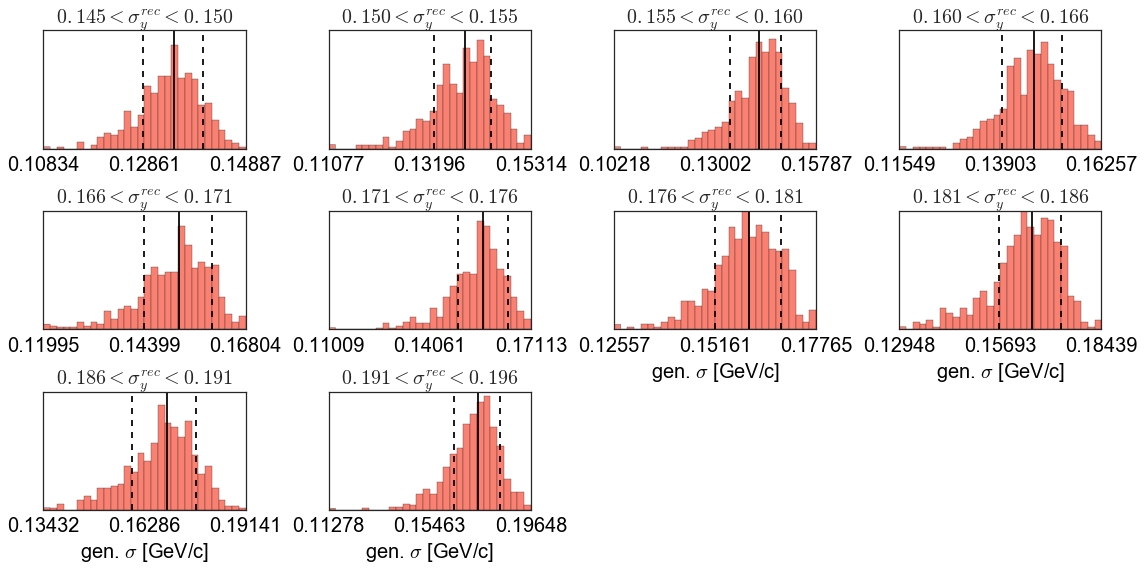

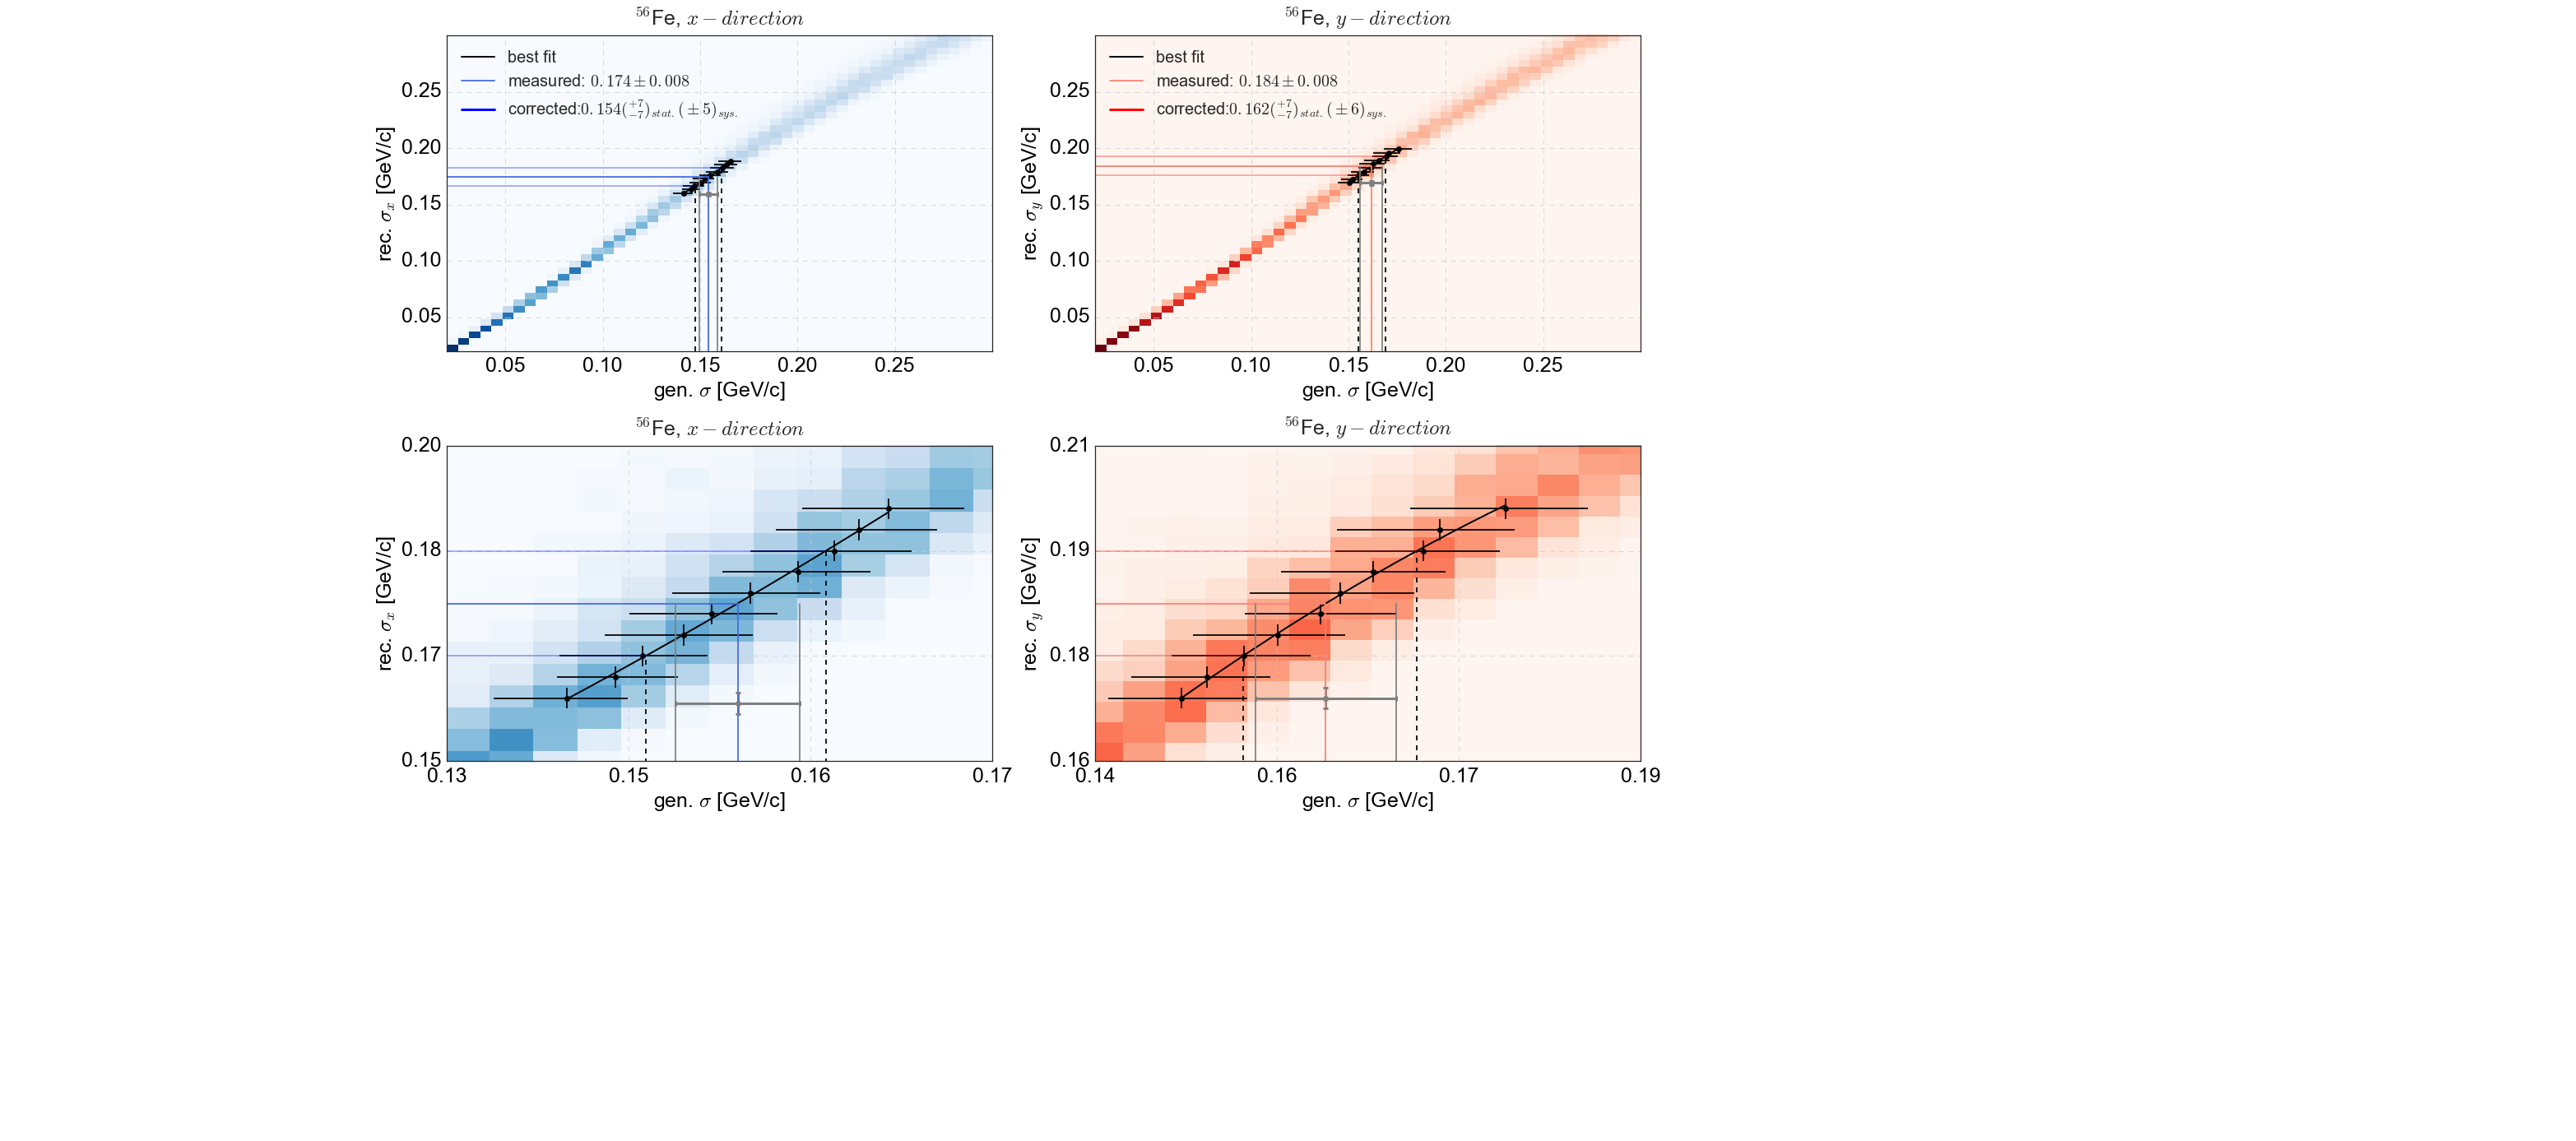

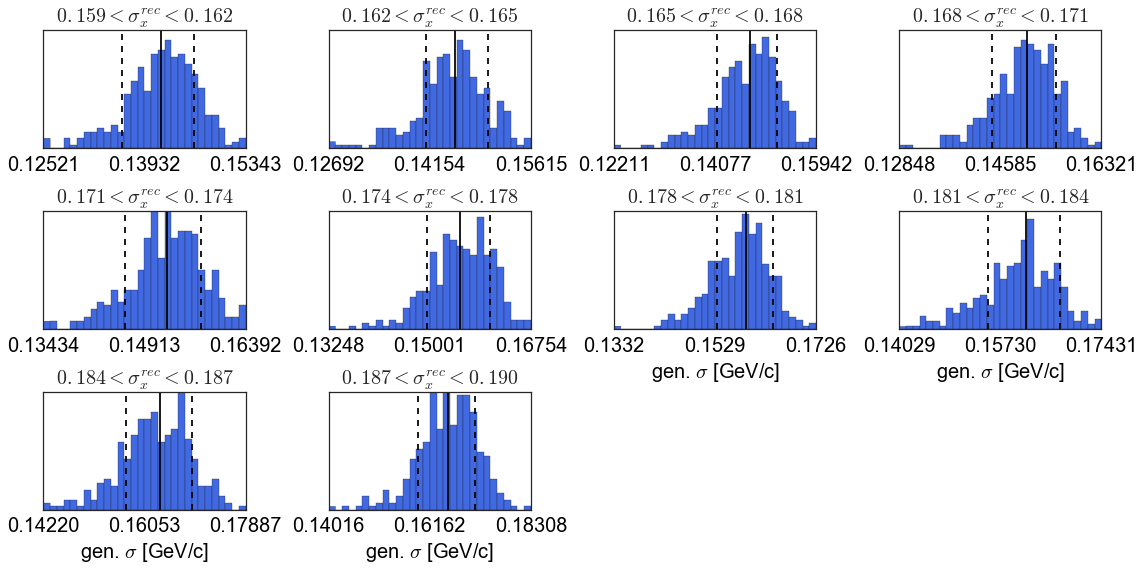

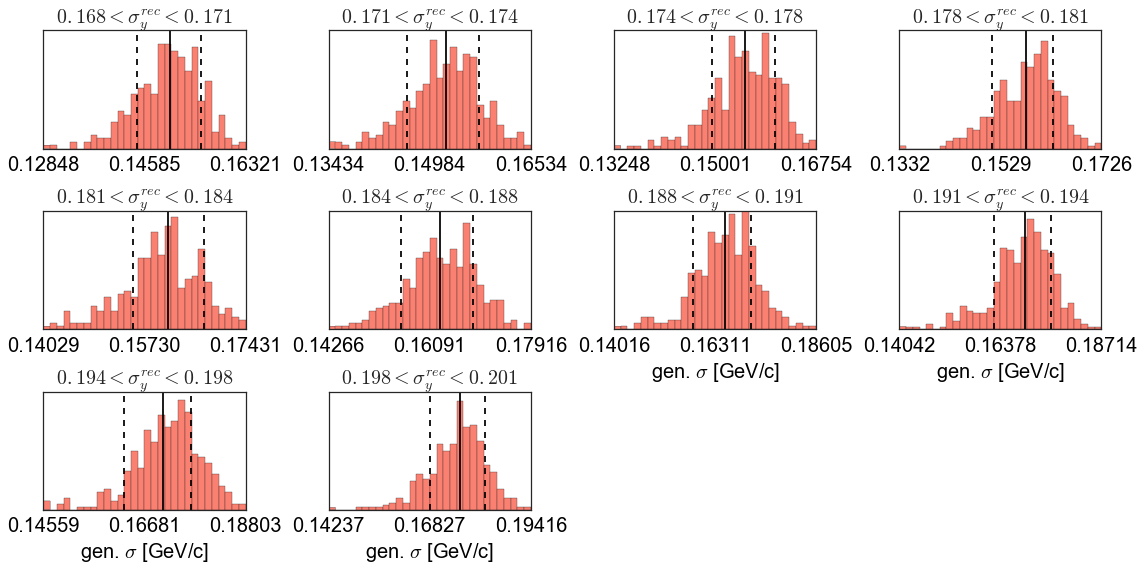

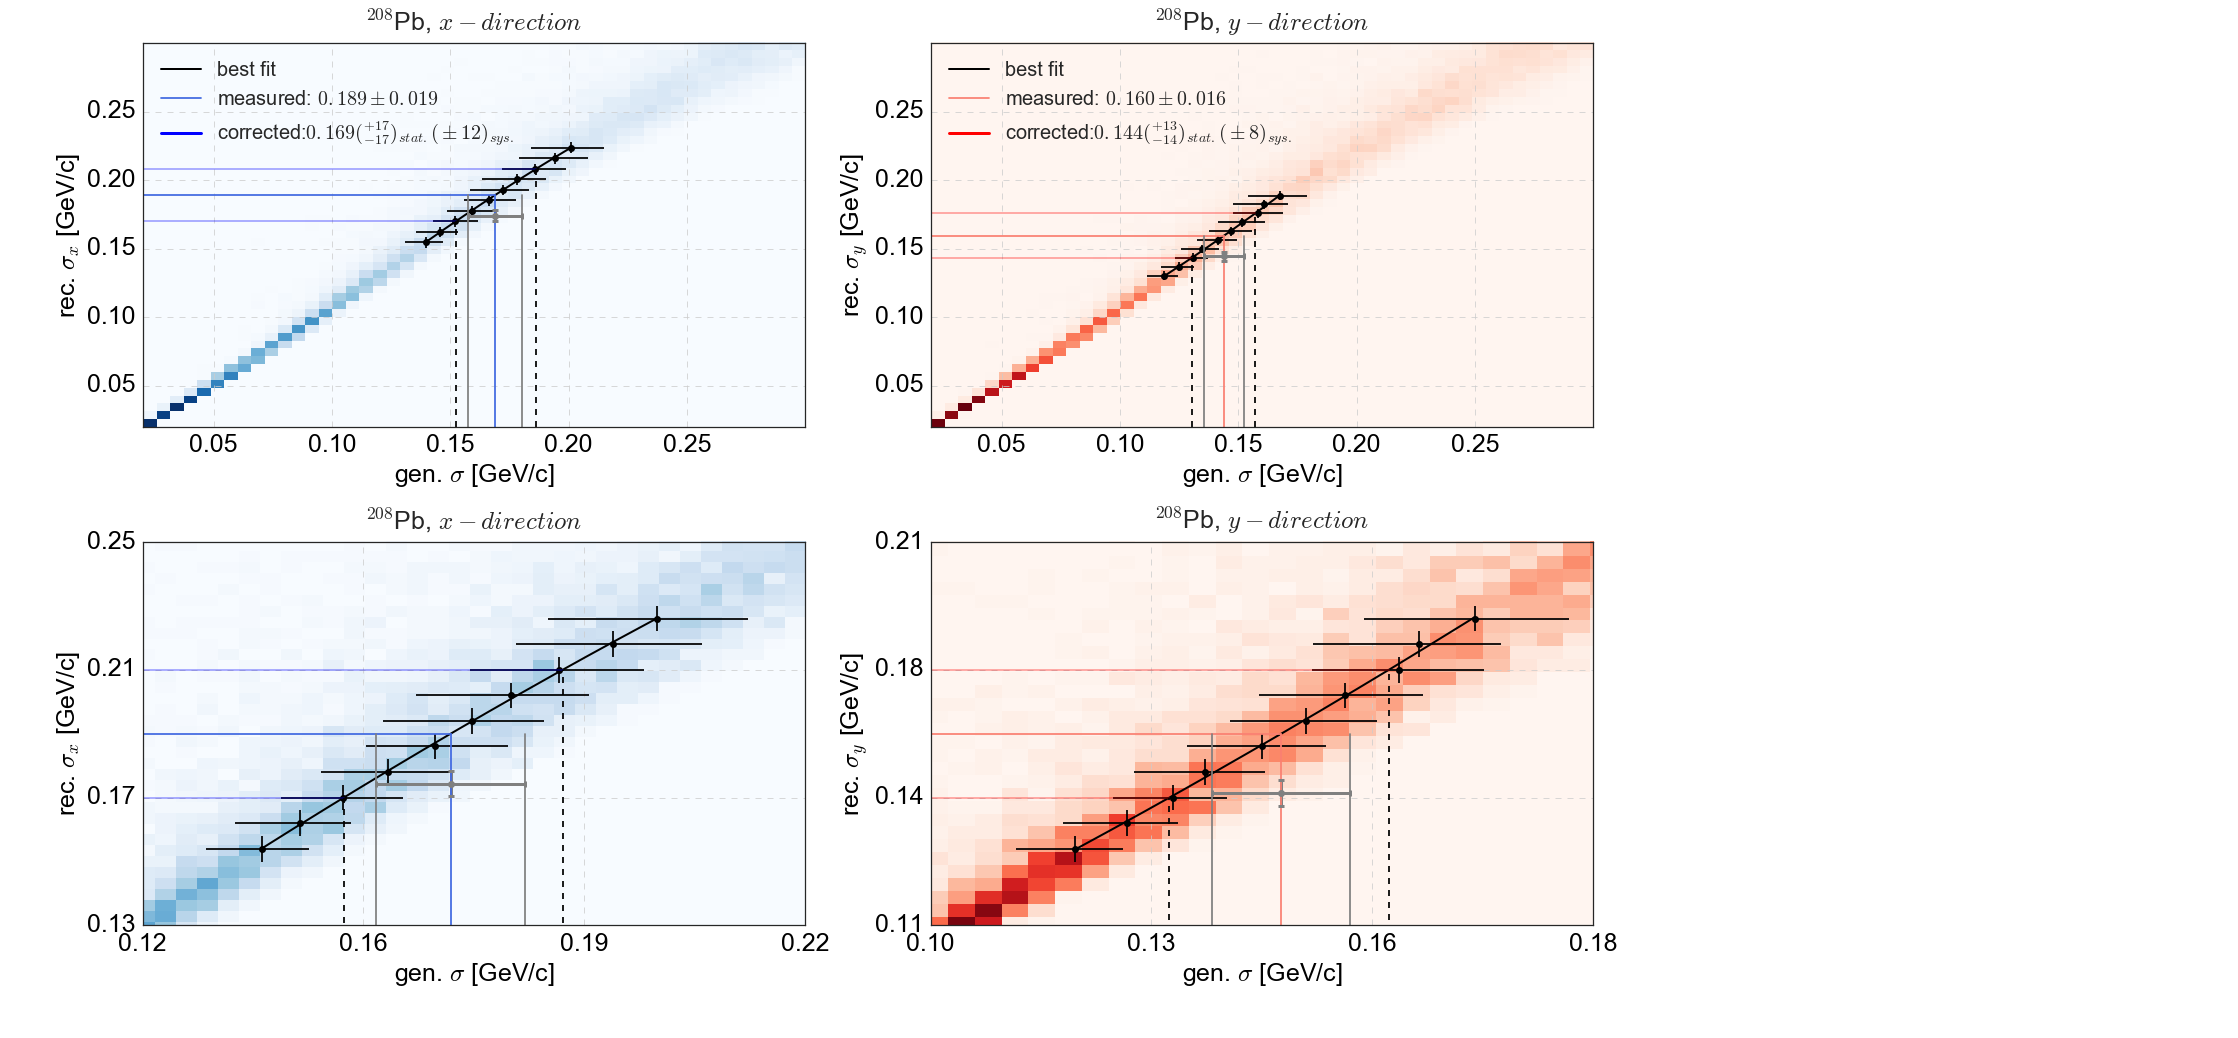

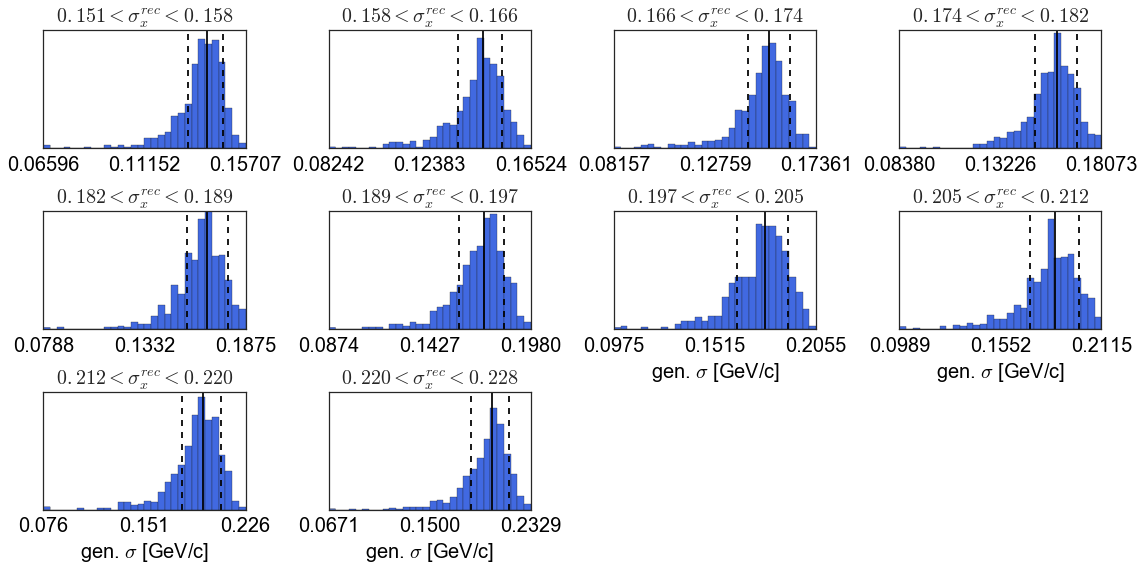

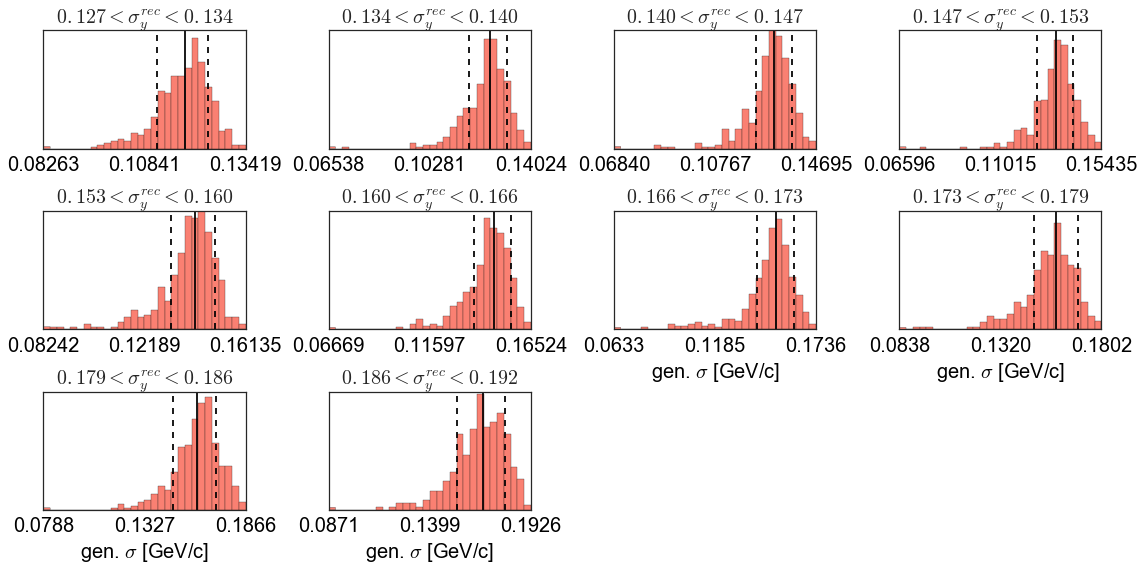

In [60]:
poly_degree = 2 # fit polynomial degree
extraname = 'NoPrecFiducials'
for i,(A,target) in enumerate(zip(As[0:],targets[0:])):
    test_name = extraname+"_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    fig=plt.figure(figsize=(22,14))
    ax=fig.add_subplot(2,2,1)    
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname,Fiducials=Fiducials
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,3)    
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname,Fiducials=Fiducials
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    ax=fig.add_subplot(2,2,2)
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname,Fiducials=Fiducials
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,4)
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname,Fiducials=Fiducials
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    fig.subplots_adjust(bottom=-0.5,left=-0.2)
    fig.tight_layout() 
    filename = figures_path+'St_gen_rec_'+target+'_'+extraname+'.png'    
    fig.savefig( filename )

In [61]:
sample = cm_parameters_with_correction['NoPrecFiducials']
extraname='NoPrecFiducials'

for direction in ['x','y']:
    sample['sigma_'+direction+extraname+'_final'] = sample['sigma_'+direction+'_corrected'+extraname]
    for updw in ['up','dw']:
        sample['sigma_'+direction+extraname+'_final_'+updw+'_err'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot'+extraname]

corr_x = sample['sigma_x_corrected'+extraname]
Dcorr_x = sample['sigma_x_corrected_err_tot'+extraname]

corr_y = sample['sigma_y_corrected'+extraname]
Dcorr_y = sample['sigma_y_corrected_err_tot'+extraname]

# weighted average
corr_t = (corr_x/np.square(Dcorr_x)+corr_y/np.square(Dcorr_y))/( 1./np.square(Dcorr_x) + 1./np.square(Dcorr_y))
sample['sigma_t'+extraname+'_final'] = corr_t
    
Dsys_x = sample['sigma_x_corrected_err_sys'+extraname]
Dsys_y = sample['sigma_y_corrected_err_sys'+extraname]
Dsys_t = 0.5*( Dsys_x + Dsys_y )
sample['sigma_t'+extraname+'_final_err_sys'] = Dsys_t

for updw in ['up','dw']:            
    Dstat_x = sample['sigma_x_corrected_'+updw+'_err_stat'+extraname]
    Dstat_y = sample['sigma_y_corrected_'+updw+'_err_stat'+extraname]
    Dstat_t = np.sqrt(1./( 1./np.square(Dstat_x) + 1./np.square(Dstat_y) ))
    sample['sigma_t'+extraname+'_final_'+updw+'_err_stat'] = Dstat_t

    Dtot_t = np.sqrt( np.square(Dstat_t) + np.square(Dsys_t) )
    sample['sigma_t'+extraname+'_final_'+updw+'_err_tot'] = Dtot_t
    sample['sigma_t'+extraname+'_final_'+updw+'_err'] = Dtot_t

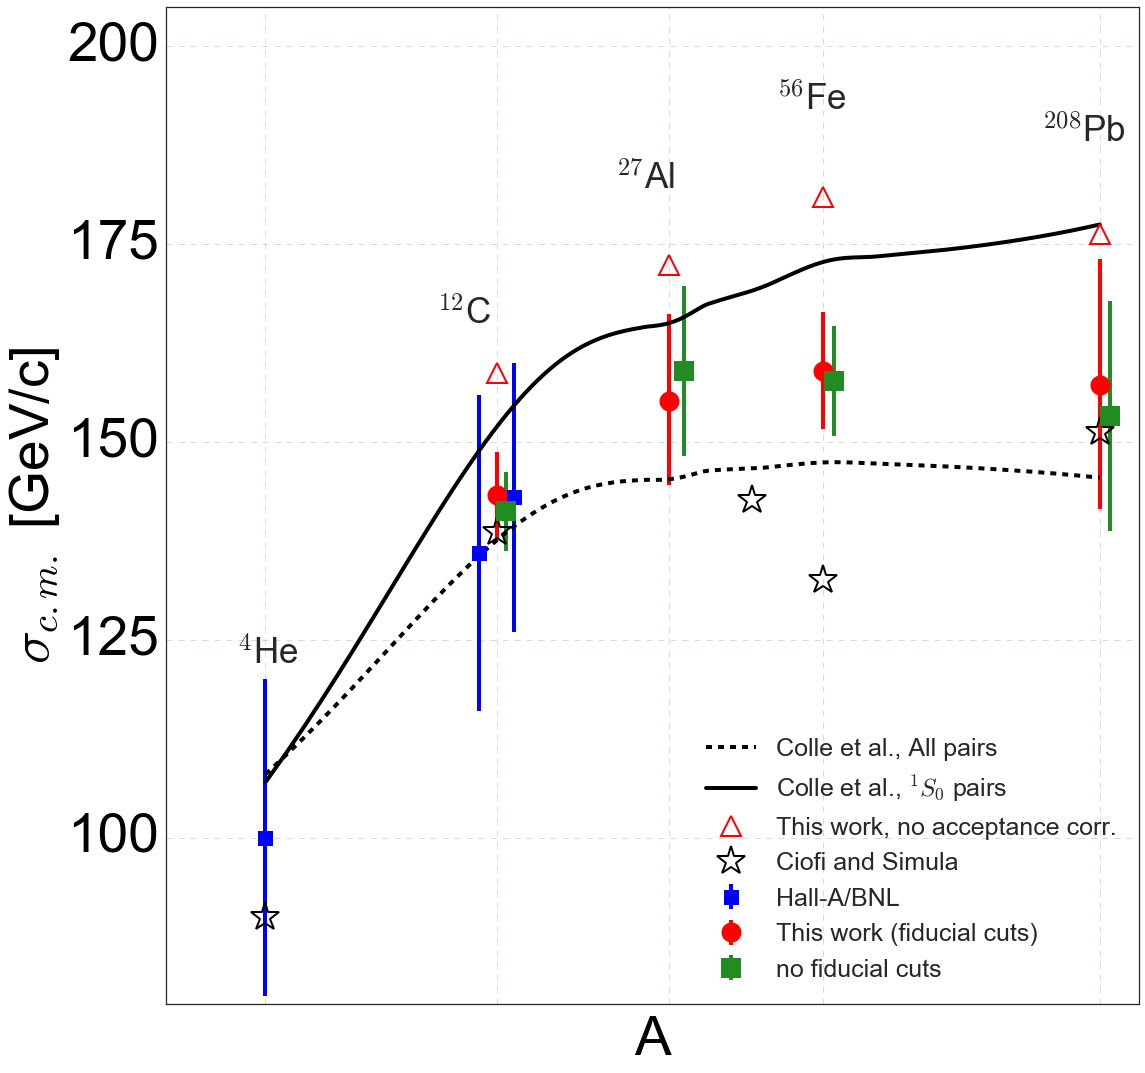

In [62]:
extraname='NoPrecFiducials'
label="no fiducial cuts"
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(158,188), }),do_Ciofi=True)
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],direction='t',ax=ax, label=r"This work (fiducial cuts)" , marker='o', markersize=20 )
plot_data_assymetric( data=cm_parameters_with_correction['NoPrecFiducials'],Ashift=[0.5,2,3,10], direction='t'+extraname,ax=ax, label=label , marker='s', markersize=20 , color='forestgreen')
plt.legend(fontsize=20,loc='upper left')
# measured
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
ax.legend(fontsize=25,loc='lower right')
plt.tight_layout()
plt.savefig(figures_path +'results_compare_'+extraname+'.pdf')

# compare constant band around mean(z) & \sigma(z) with 5  ×Δmeasured 

saved /Users/erezcohen/Desktop/Projects/2NSRC/CLASppCMnote/Figures/mean_sigma_z_Adependence_constant_band_around_measured.pdf


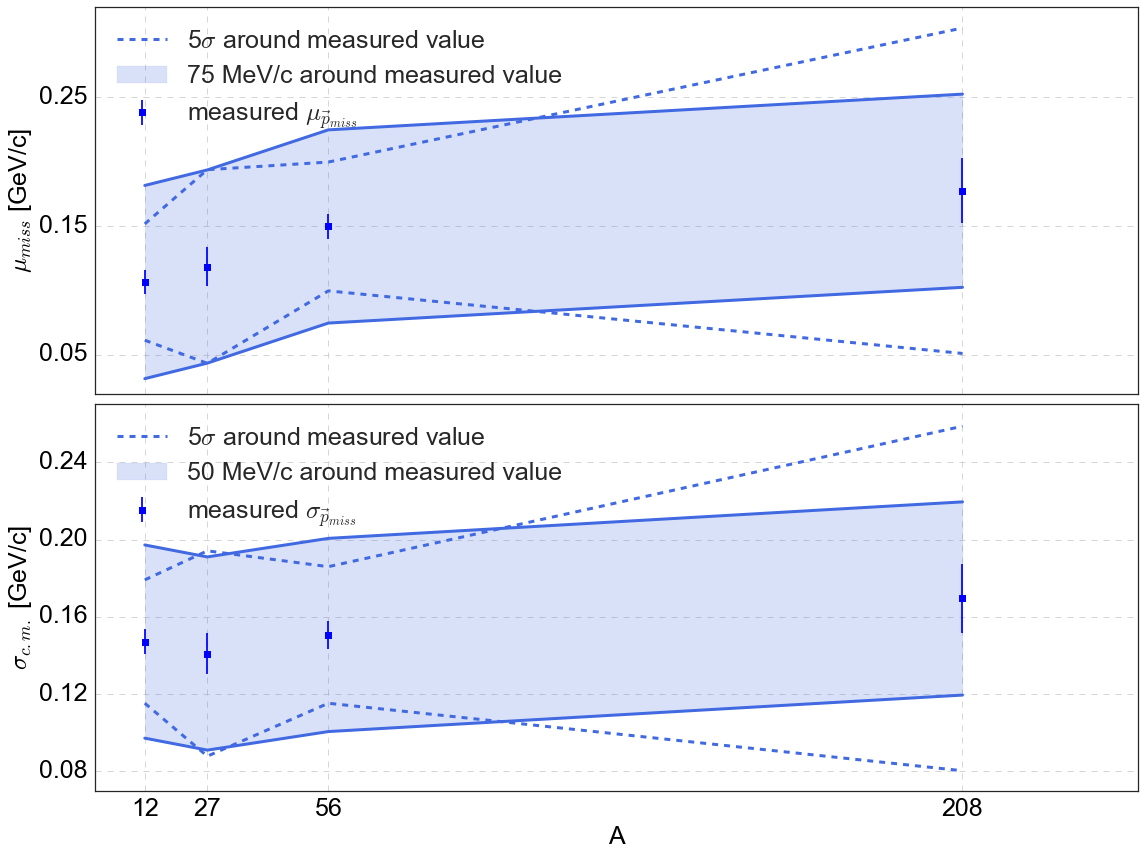

In [63]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(2,1,1)
ax.errorbar(x=cm_pars['A'],y=cm_pars['mean_z_unweighted'],yerr=cm_pars['mean_zErr_unweighted'],fmt='s'
            ,color='blue',label='measured $\\mu_{\\vec{p}_{miss}}$')
ax.fill_between(cm_pars['A']
                ,cm_pars['mean_z_unweighted']-0.075
                ,cm_pars['mean_z_unweighted']+0.075
                ,color='royalblue',alpha=0.2,label='75 MeV/c around measured value')

set_axes(ax,'','$\\mu_{miss}$ [GeV/c]')
ax.xaxis.set_ticks([12,27,56,208]);ax.yaxis.set_ticks([0.05,0.15,0.25,0.35]);
ax.grid(linestyle='--',alpha=0.8)
plt.plot(cm_pars['A'],cm_pars['mean_z_unweighted']-5*cm_pars['mean_zErr_unweighted'],'--',linewidth=3,color='royalblue',label='5$\\sigma$ around measured value')
ax.legend(fontsize=25,loc='upper left')
plt.plot(cm_pars['A'],cm_pars['mean_z_unweighted']-0.075,'-',linewidth=3,color='royalblue')
plt.plot(cm_pars['A'],cm_pars['mean_z_unweighted']+0.075,'-',linewidth=3,color='royalblue')
plt.plot(cm_pars['A'],cm_pars['mean_z_unweighted']+5*cm_pars['mean_zErr_unweighted'],'--',linewidth=3,color='royalblue')


ax.xaxis.set_major_formatter(NullFormatter())
ax.set_xlim(0,250);ax.set_ylim(0.02,0.32);

ax = fig.add_subplot(2,1,2)
ax.errorbar(x=cm_pars['A'],y=cm_pars['sigma_z_unweighted'],yerr=cm_pars['sigma_zErr_unweighted'],fmt='s'
            ,color='blue',label='measured $\\sigma_{\\vec{p}_{miss}}$')
ax.fill_between(cm_pars['A'] ,cm_pars['sigma_z_unweighted']-0.05 ,cm_pars['sigma_z_unweighted']+0.05
                ,color='royalblue',alpha=0.2,label='50 MeV/c around measured value')

set_axes(ax,'A','$\\sigma_{c.m.}$ [GeV/c]')
ax.xaxis.set_ticks([12,27,56,208]);ax.yaxis.set_ticks([0.08,0.12,0.16,0.20,0.24]);
ax.grid(linestyle='--',alpha=0.8)
plt.plot(cm_pars['A'],cm_pars['sigma_z_unweighted']-5*cm_pars['sigma_zErr_unweighted'],'--',linewidth=3,color='royalblue',label='5$\\sigma$ around measured value')
ax.legend(fontsize=25,loc='upper left')
plt.plot(cm_pars['A'],cm_pars['sigma_z_unweighted']-0.05,'-',linewidth=3,color='royalblue')
plt.plot(cm_pars['A'],cm_pars['sigma_z_unweighted']+0.05,'-',linewidth=3,color='royalblue')
plt.plot(cm_pars['A'],cm_pars['sigma_z_unweighted']+5*cm_pars['sigma_zErr_unweighted'],'--',linewidth=3,color='royalblue')


ax.set_xlim(0,250);ax.set_ylim(0.07,0.27);


plt.tight_layout()
outfilename = figures_path + 'mean_sigma_z_Adependence_constant_band_around_measured.pdf'
print 'saved',outfilename
plt.savefig(outfilename)

In [64]:
for Fiducials in ["PrecFiducials"]:
    for A,target in zip(As,targets):
        test_name = "ConstBandAroundMeasuredValues_"+Fiducials+"_"+target
        simulation_results[test_name] = pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/final_simualtions_300Pmiss600/"+test_name+".csv")
        simulation_results[test_name].fillna(-1,inplace=True)
        print len(simulation_results[test_name]),'events in ',test_name

38400 events in  ConstBandAroundMeasuredValues_PrecFiducials_C
37304 events in  ConstBandAroundMeasuredValues_PrecFiducials_Al
36269 events in  ConstBandAroundMeasuredValues_PrecFiducials_Fe
34541 events in  ConstBandAroundMeasuredValues_PrecFiducials_Pb


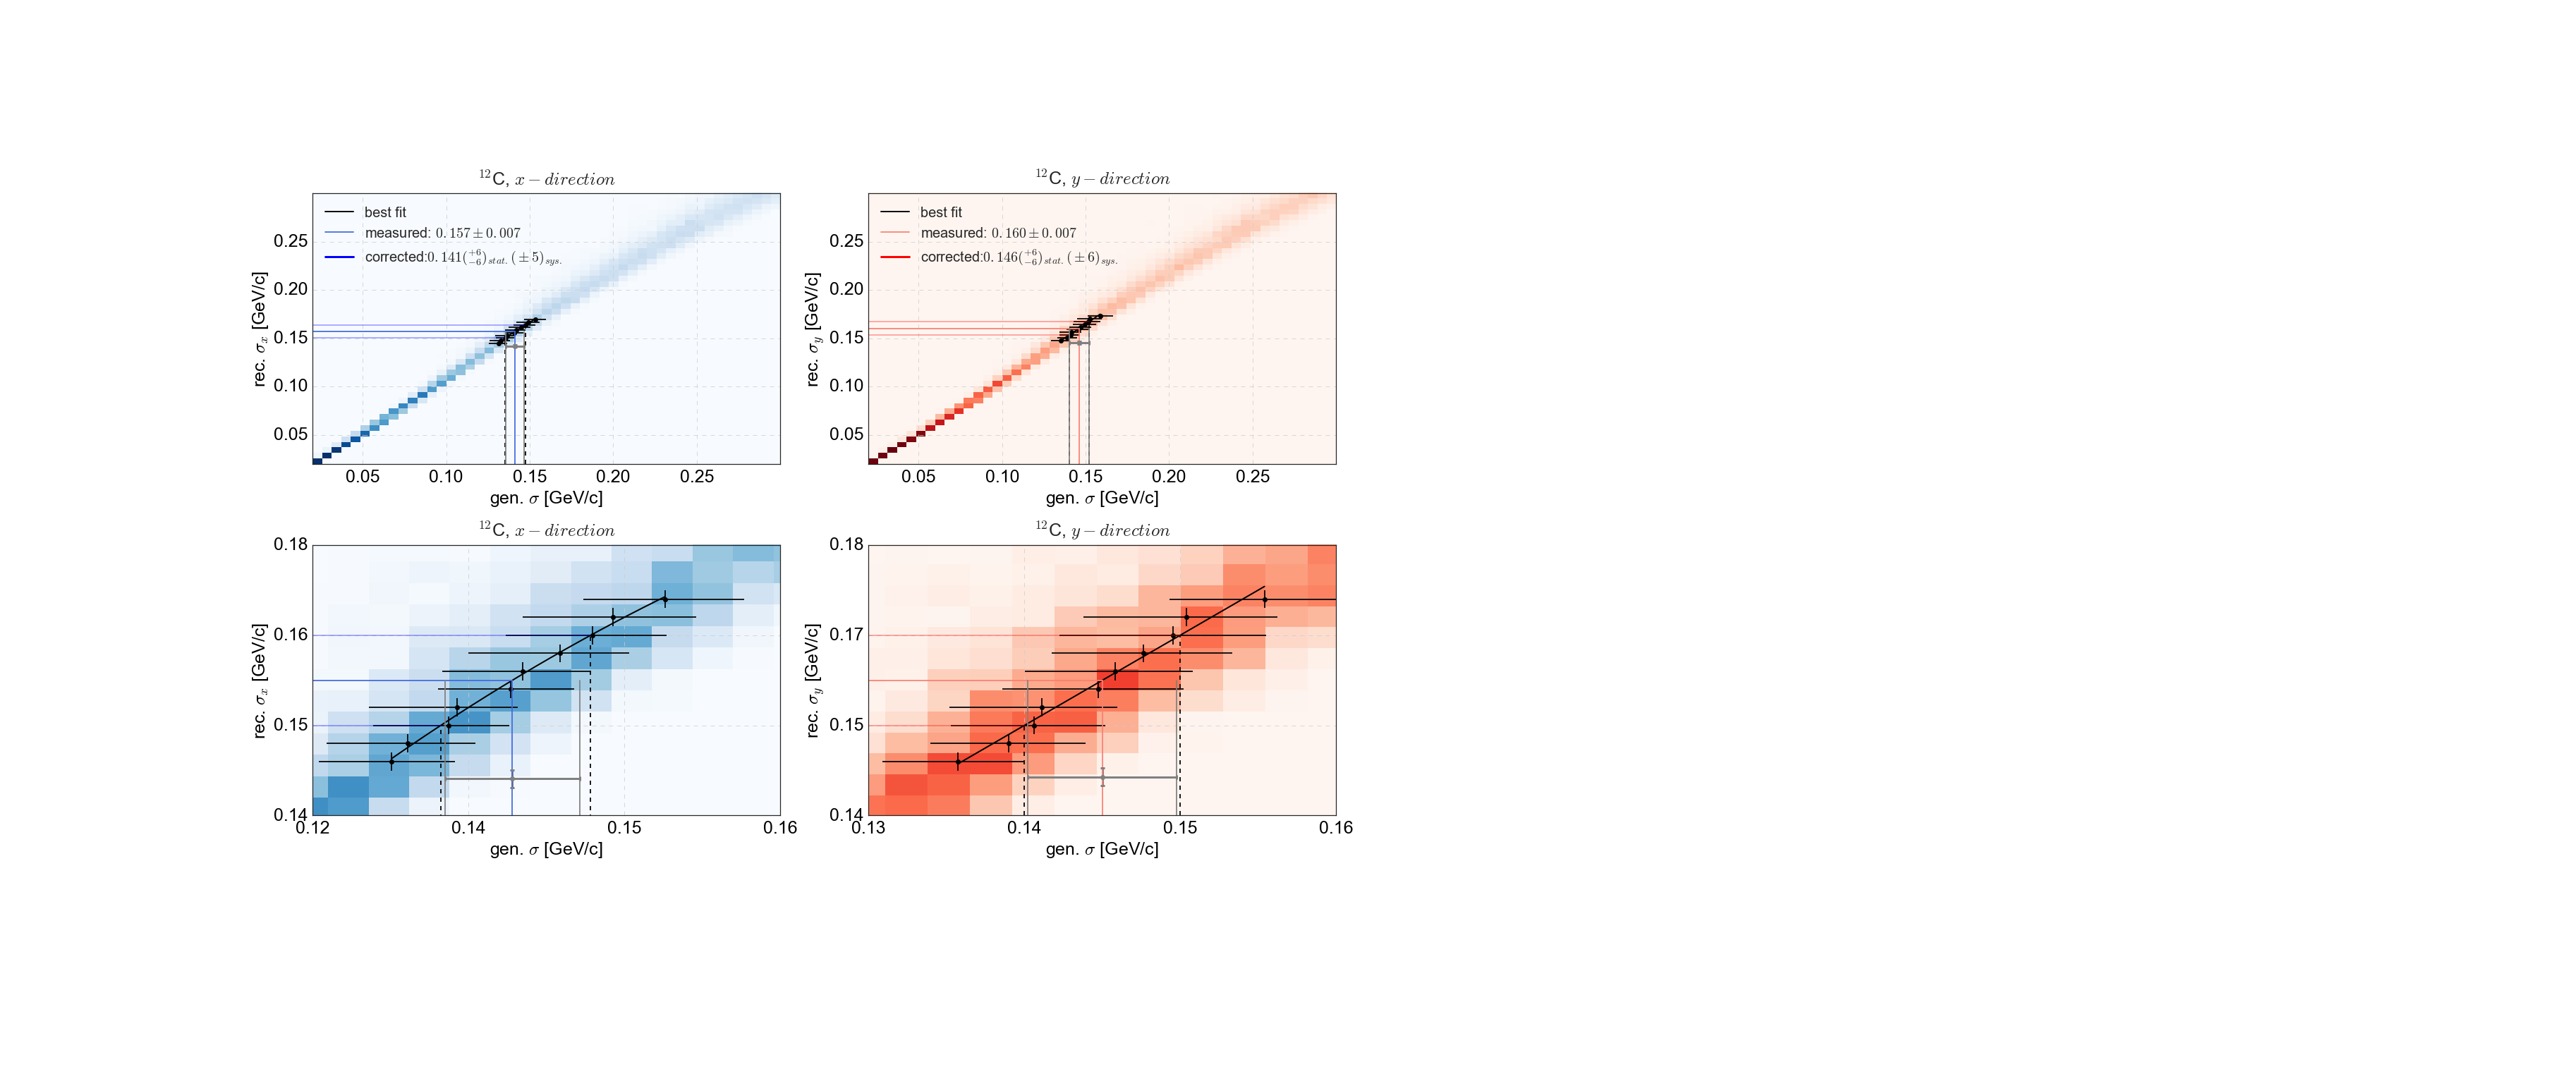

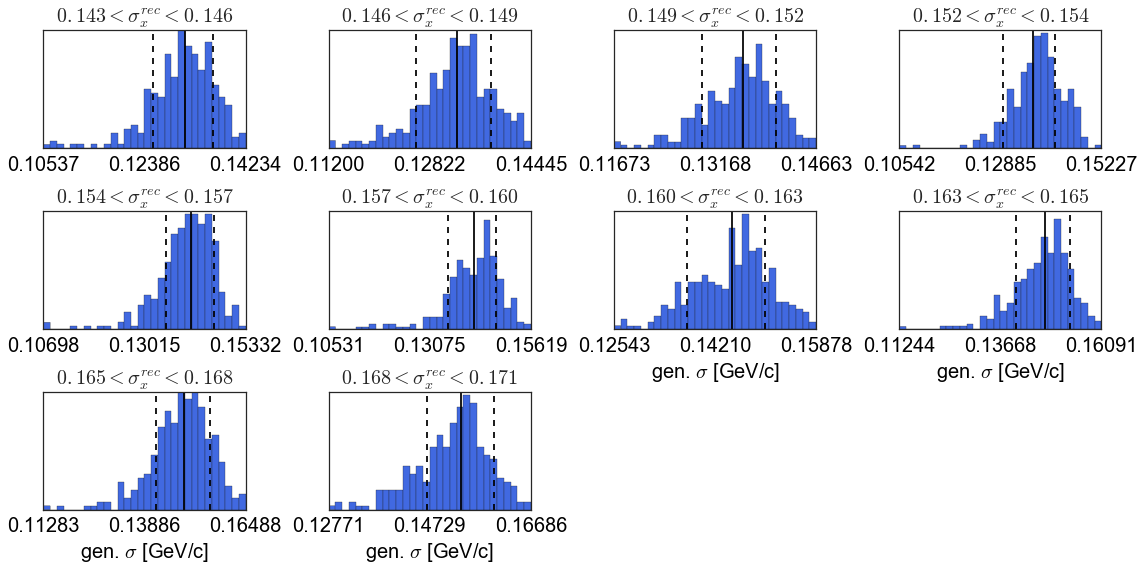

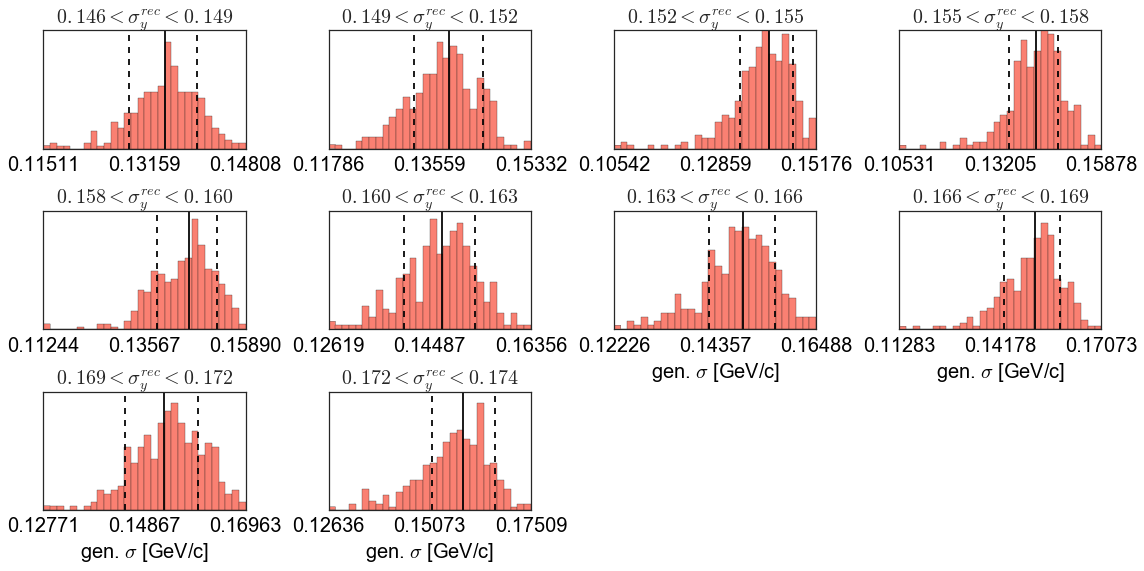

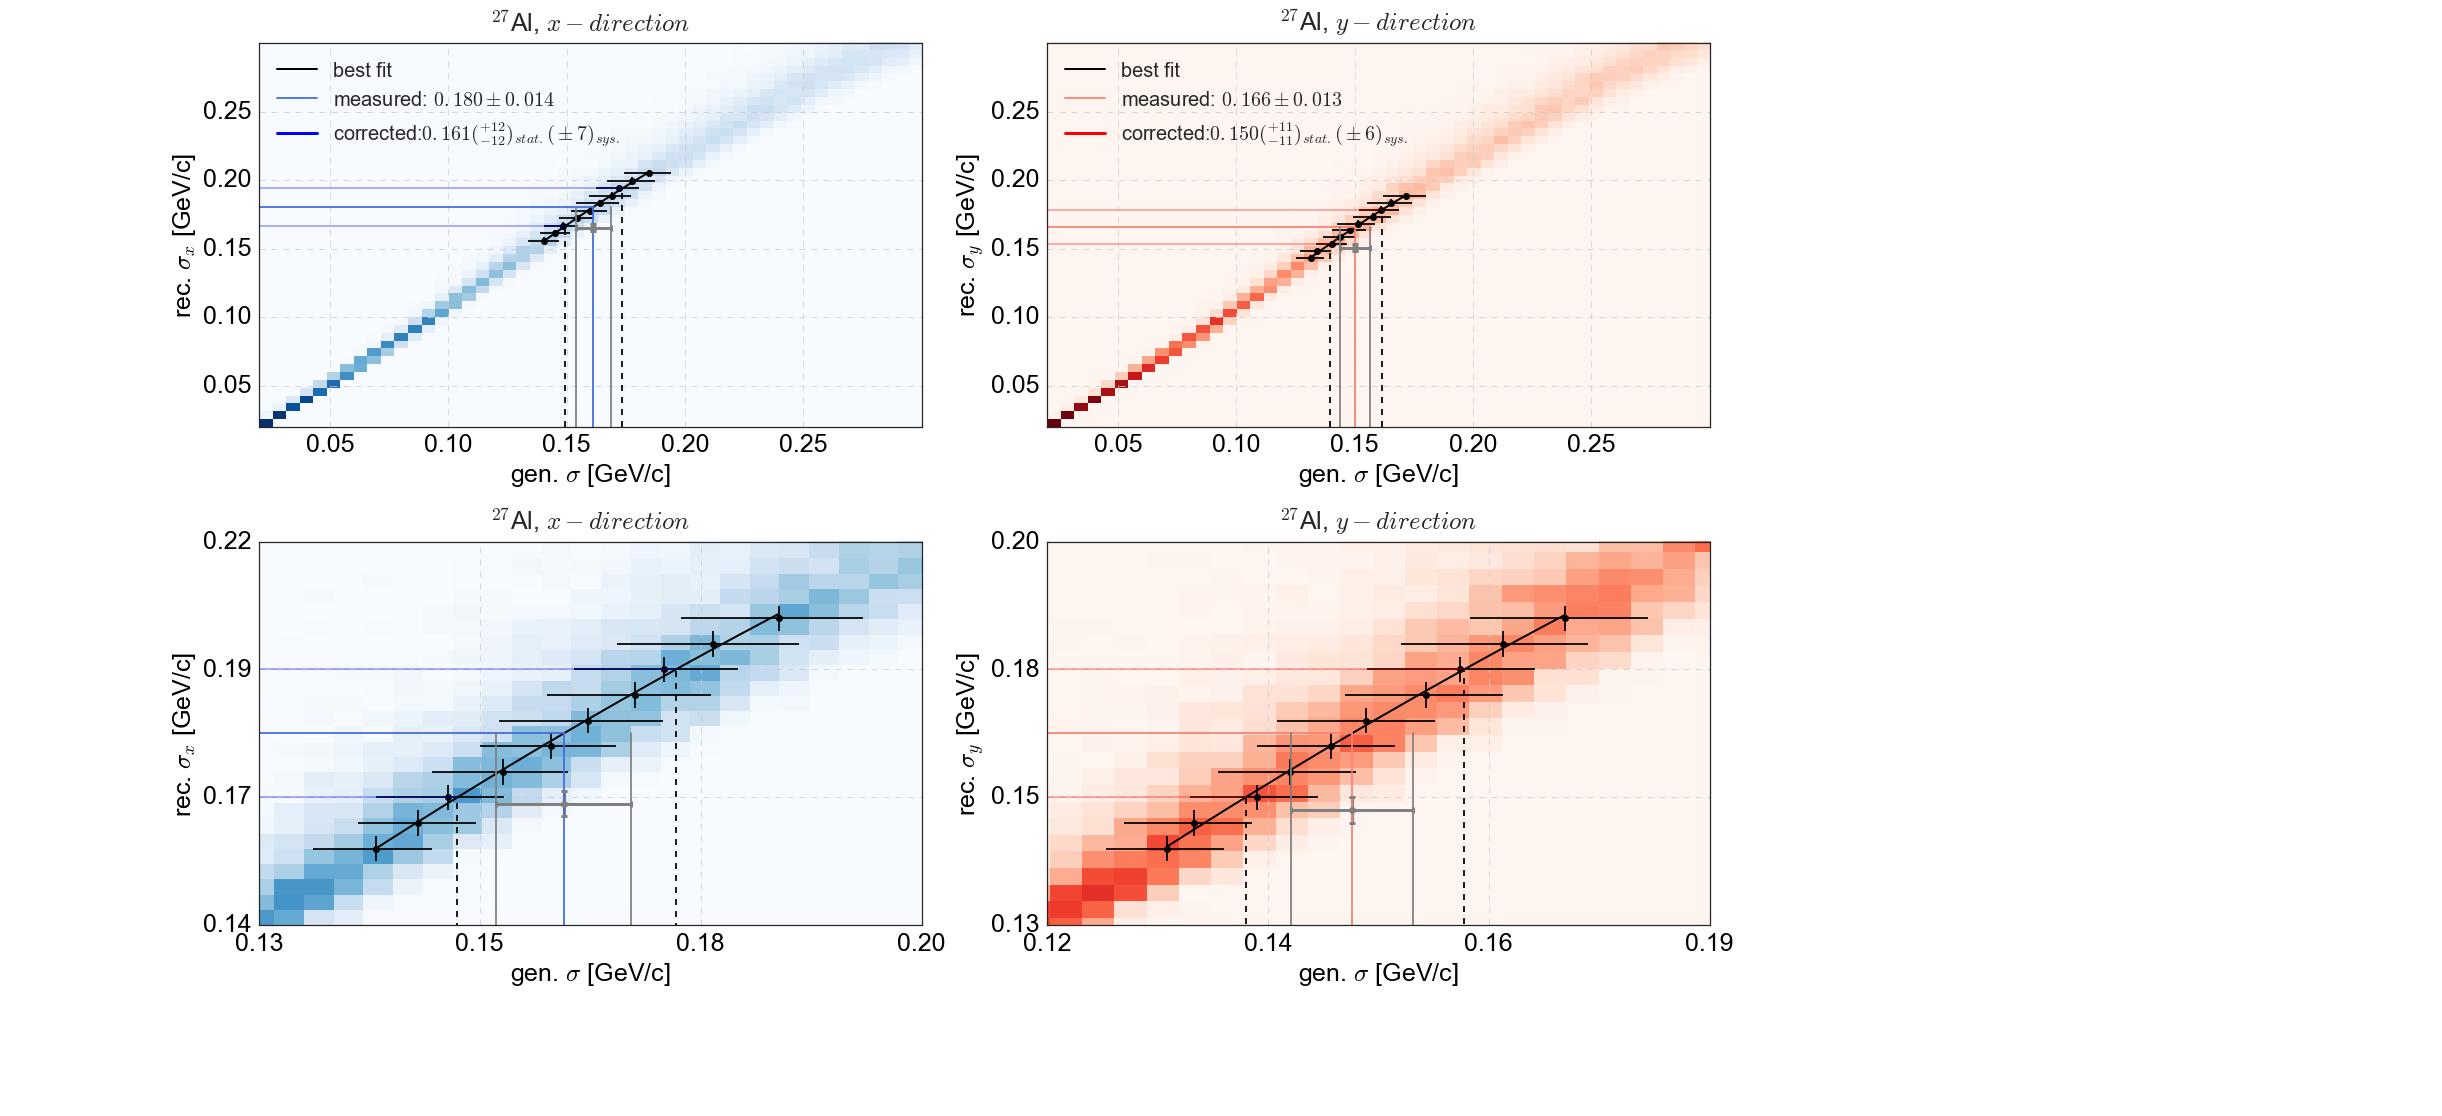

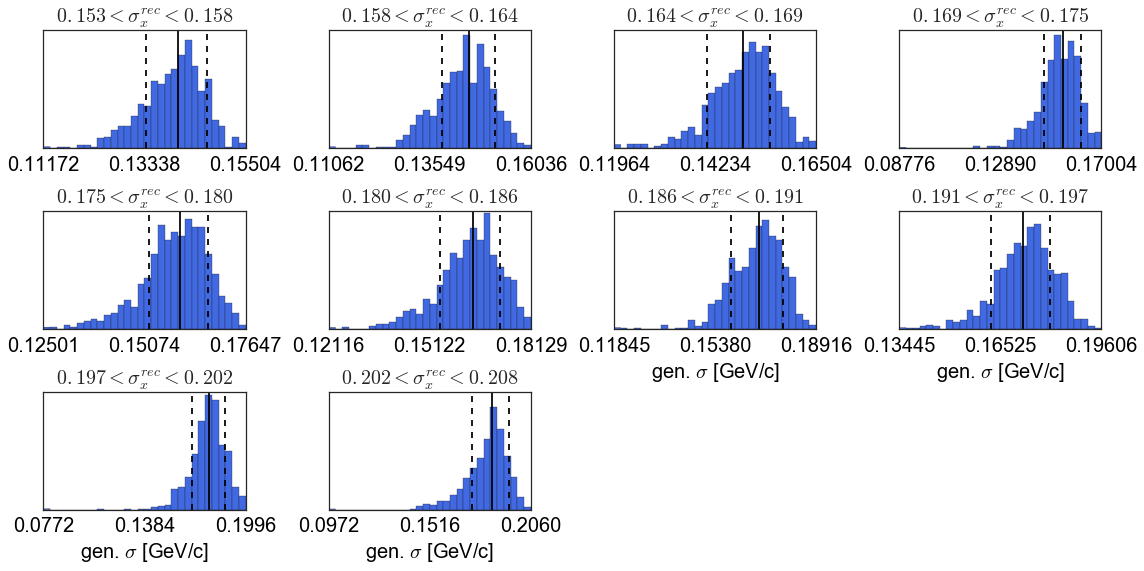

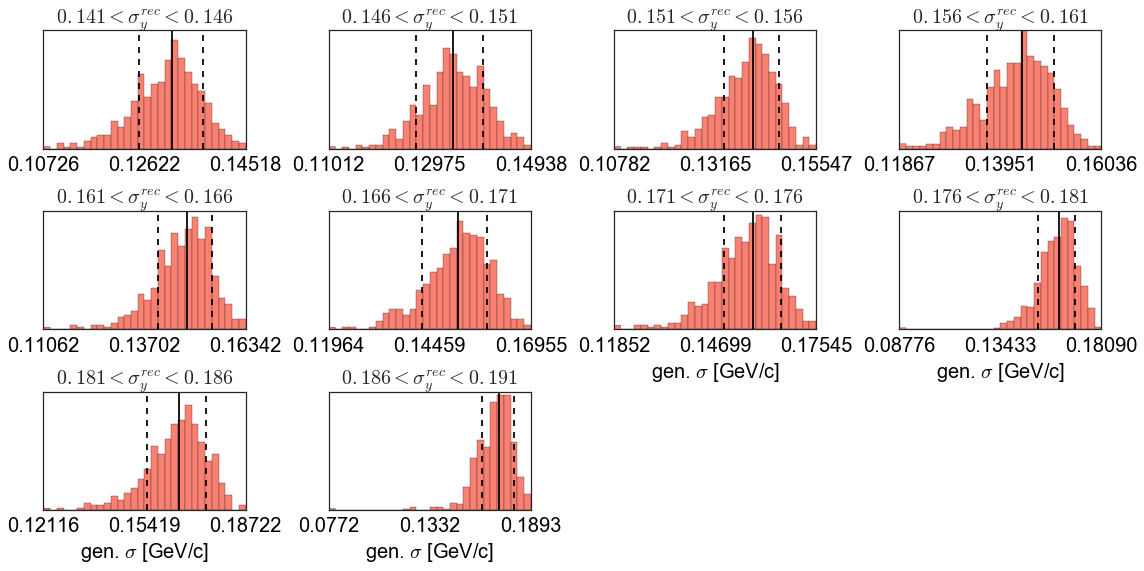

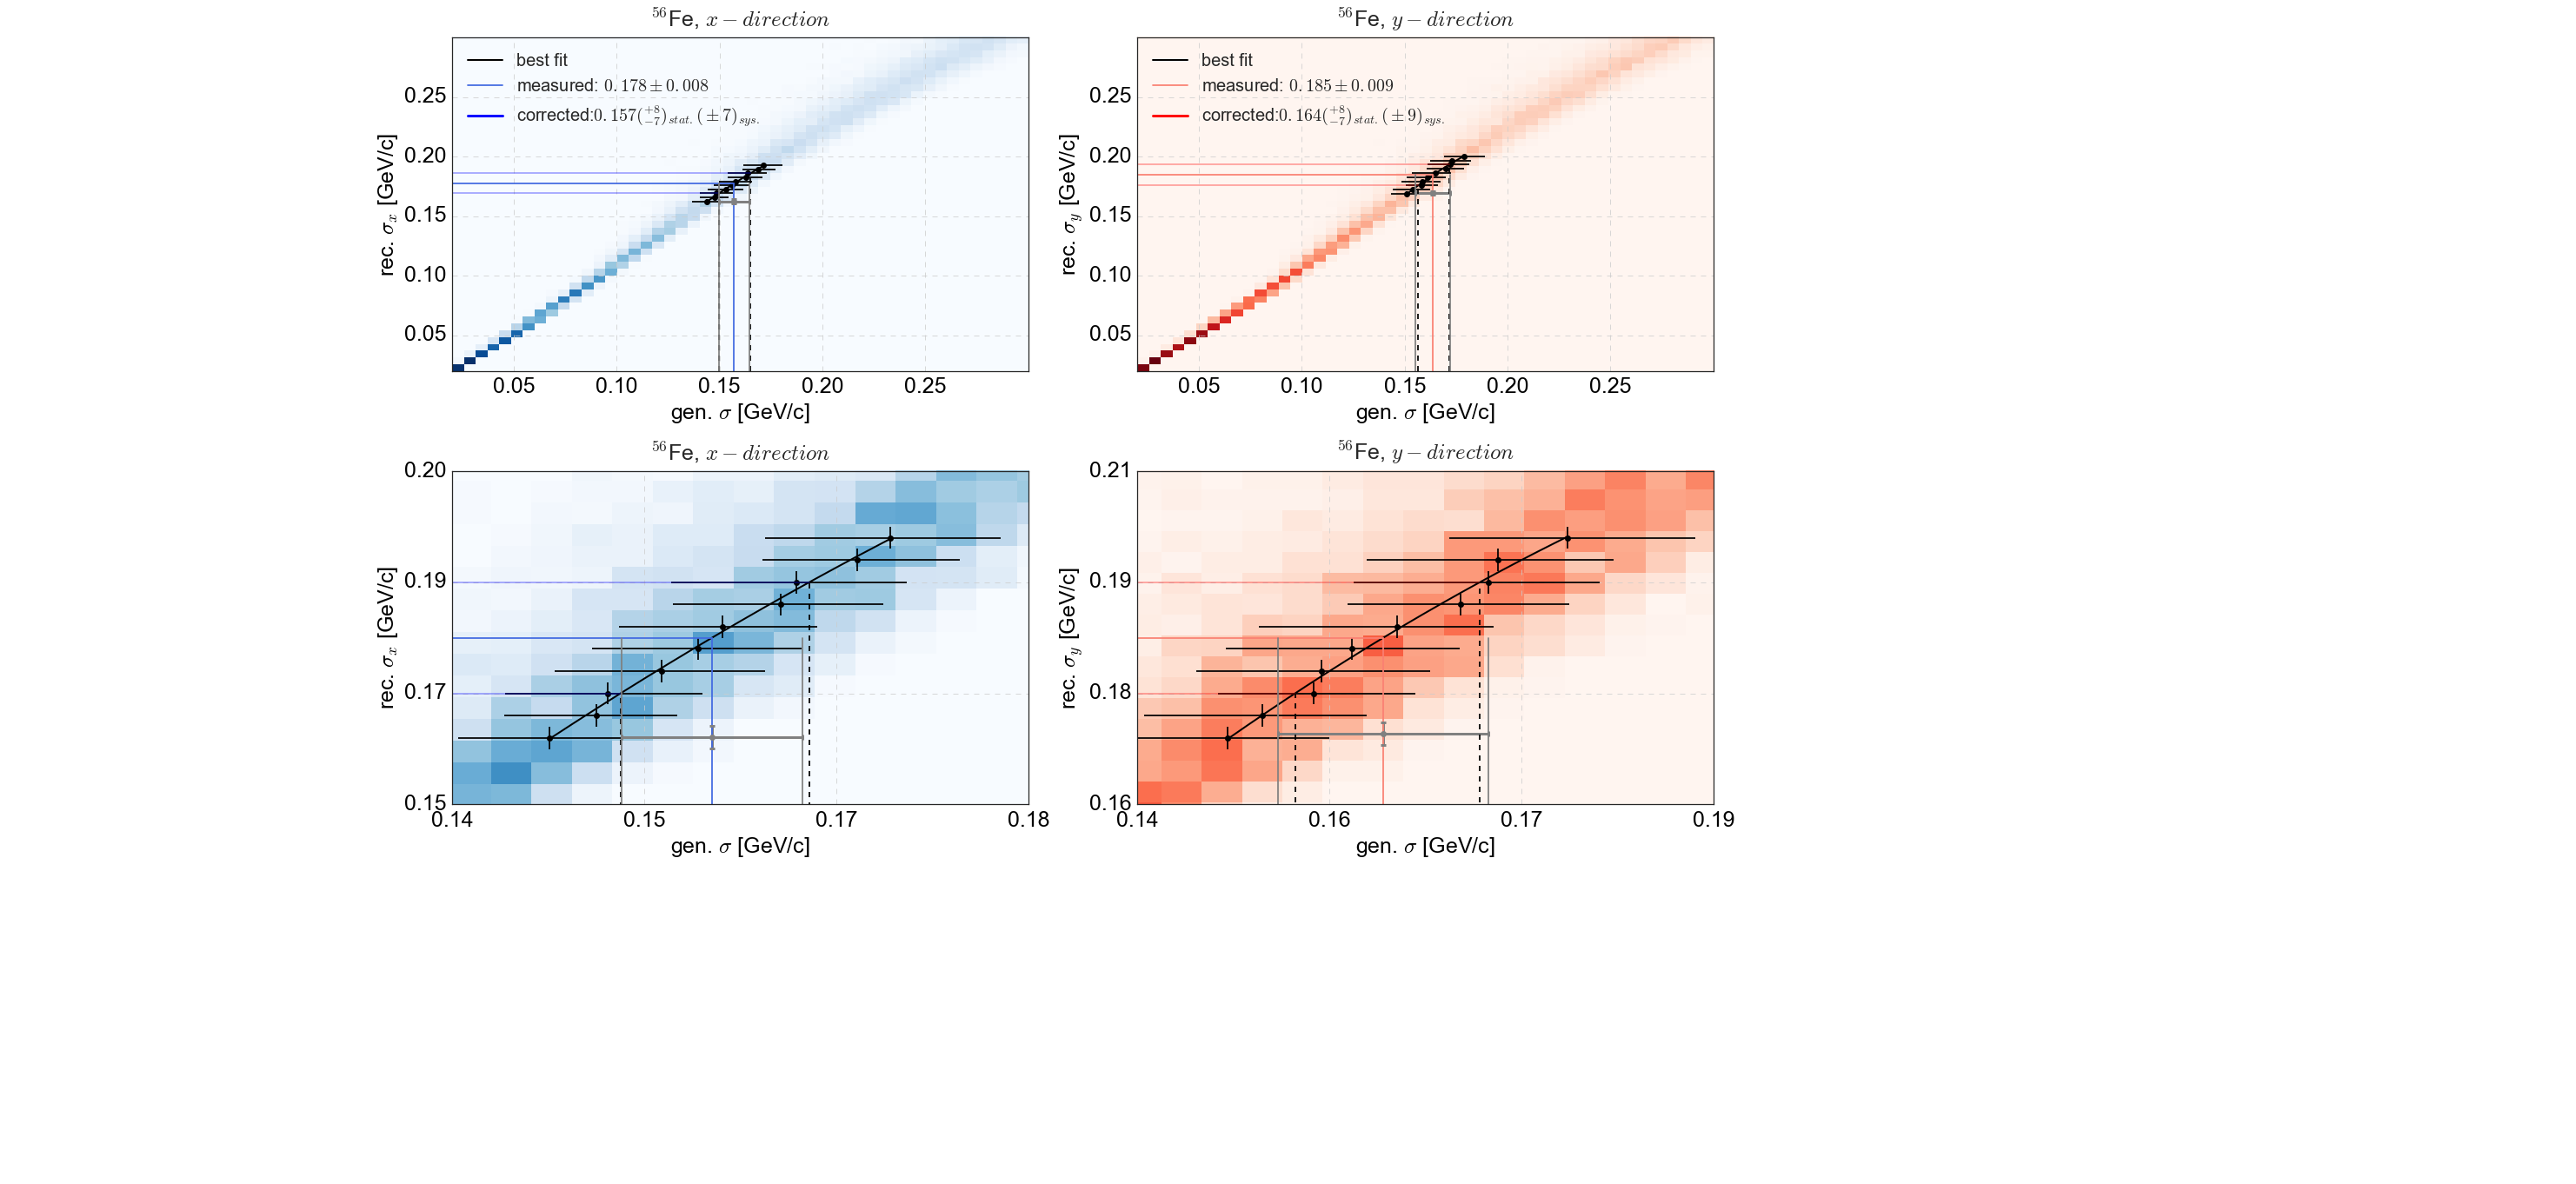

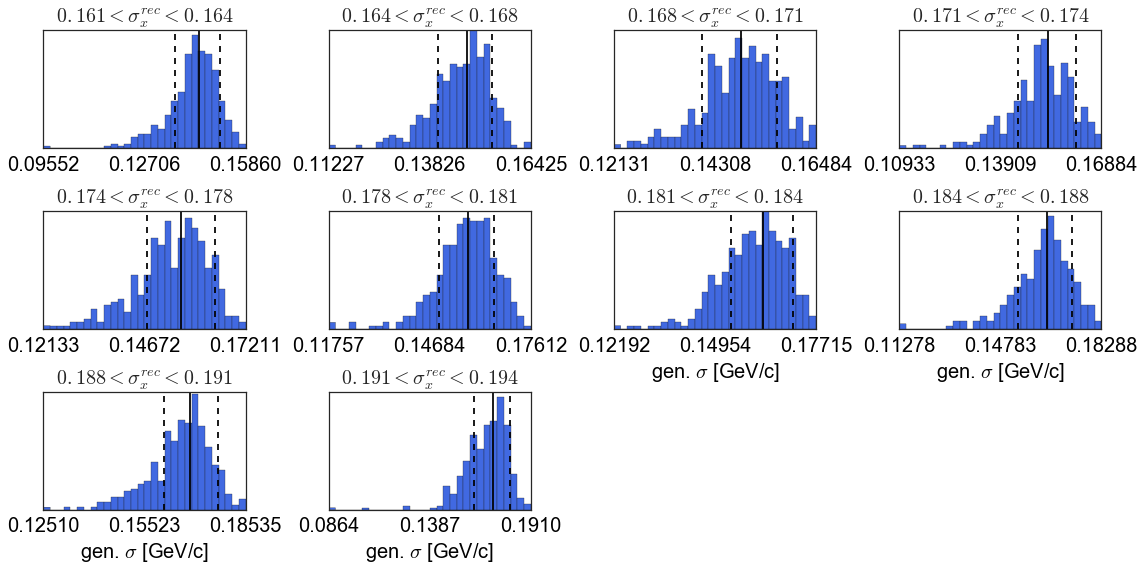

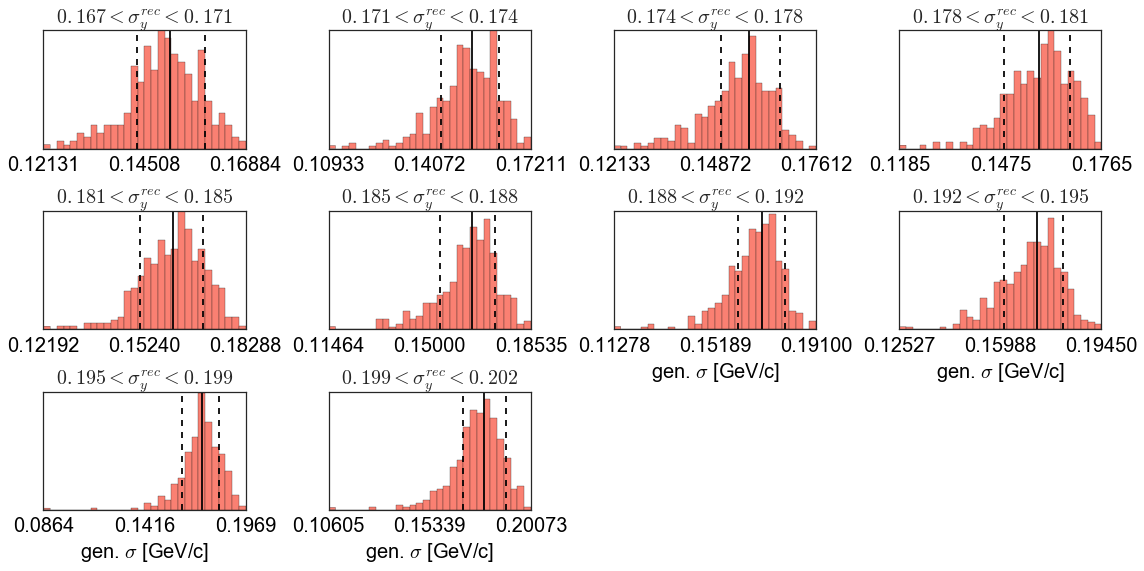

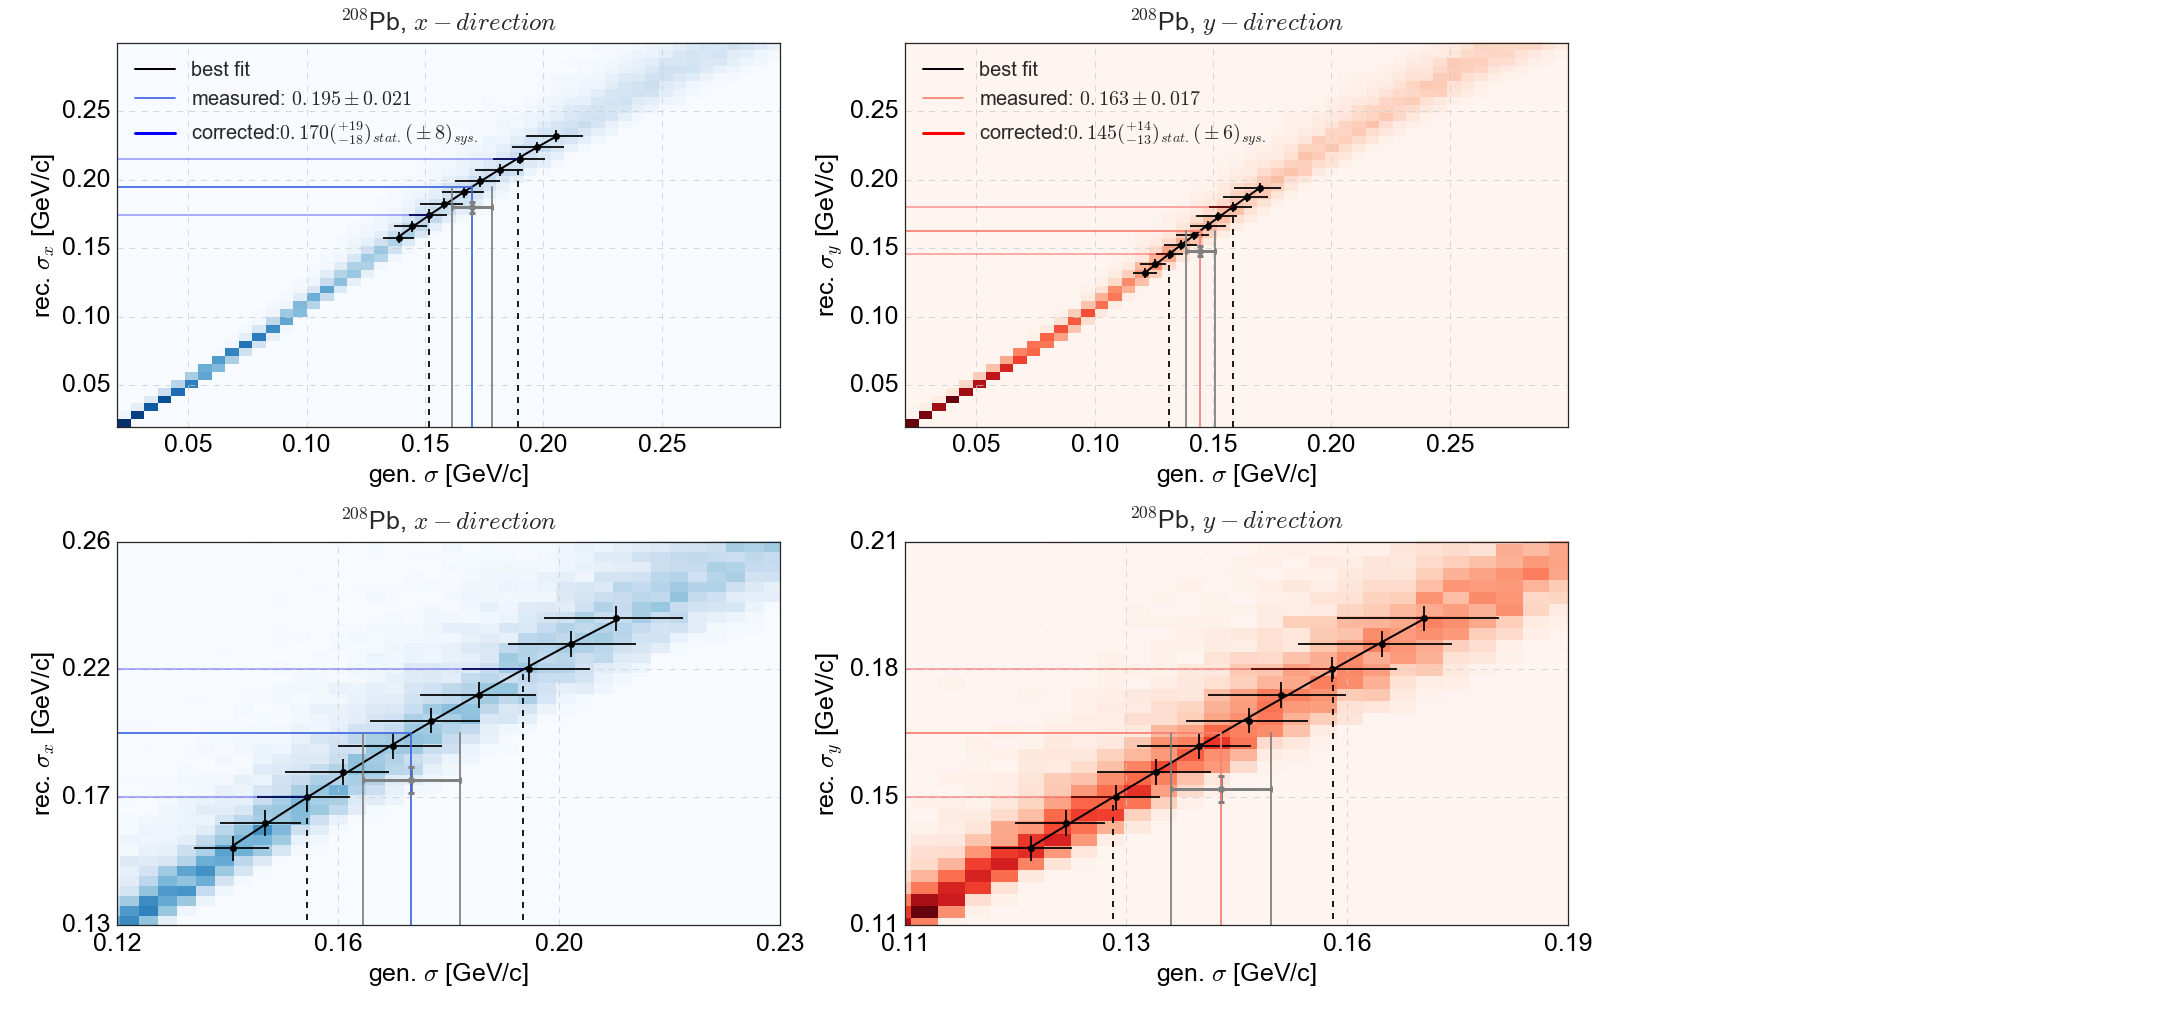

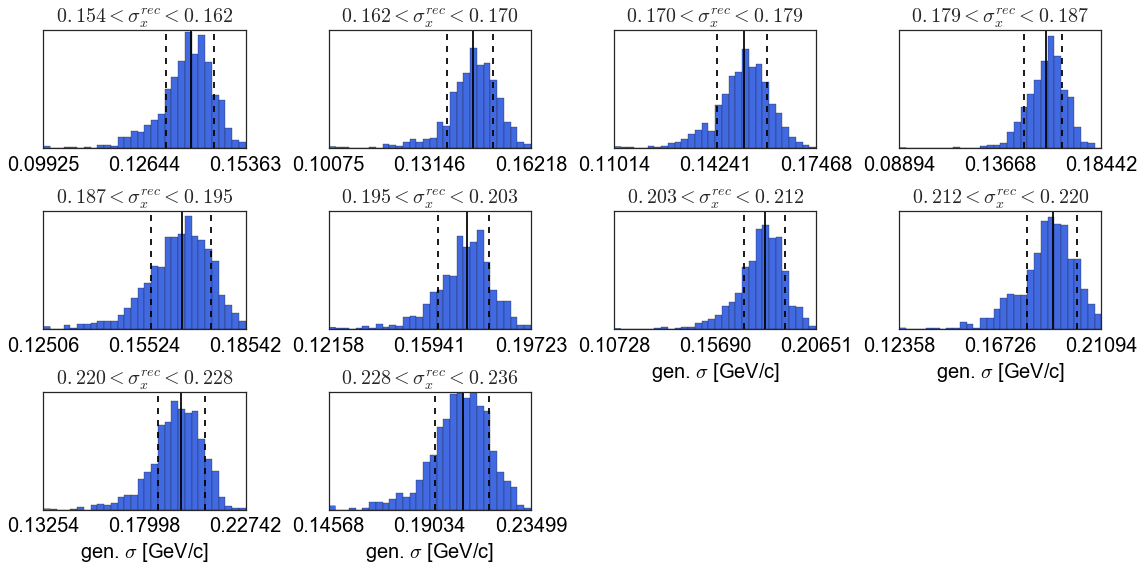

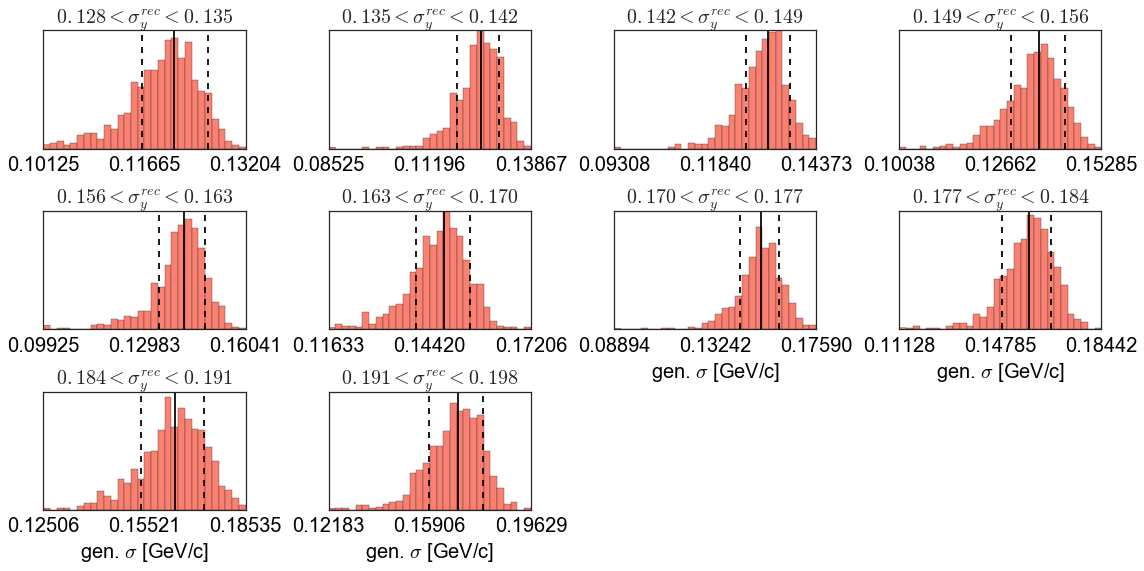

In [65]:
poly_degree = 2 # fit polynomial degree
extraname='ConstBandAroundMeasuredValues'
for i,(A,target) in enumerate(zip(As[0:],targets[0:])):
    test_name = extraname+"_"+Fiducials+"_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    fig=plt.figure(figsize=(22,14))
    ax=fig.add_subplot(2,2,1)    
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,3)    
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    ax=fig.add_subplot(2,2,2)
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,4)
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    fig.subplots_adjust(bottom=-0.5,left=-0.2)
    fig.tight_layout() 
    filename = figures_path+'St_gen_rec_'+target+'_'+extraname+'.png'    
    fig.savefig( filename )

In [66]:
sample = cm_parameters_with_correction['PrecFiducials']
extraname='ConstBandAroundMeasuredValues'

for direction in ['x','y']:
    sample['sigma_'+direction+extraname+'_final'] = sample['sigma_'+direction+'_corrected'+extraname]
    for updw in ['up','dw']:
        sample['sigma_'+direction+extraname+'_final_'+updw+'_err'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot'+extraname]

corr_x = sample['sigma_x_corrected'+extraname]
Dcorr_x = sample['sigma_x_corrected_err_tot'+extraname]

corr_y = sample['sigma_y_corrected'+extraname]
Dcorr_y = sample['sigma_y_corrected_err_tot'+extraname]

# weighted average
corr_t = (corr_x/np.square(Dcorr_x)+corr_y/np.square(Dcorr_y))/( 1./np.square(Dcorr_x) + 1./np.square(Dcorr_y))
sample['sigma_t'+extraname+'_final'] = corr_t
    
Dsys_x = sample['sigma_x_corrected_err_sys'+extraname]
Dsys_y = sample['sigma_y_corrected_err_sys'+extraname]
Dsys_t = 0.5*( Dsys_x + Dsys_y )
sample['sigma_t'+extraname+'_final_err_sys'] = Dsys_t

for updw in ['up','dw']:            
    Dstat_x = sample['sigma_x_corrected_'+updw+'_err_stat'+extraname]
    Dstat_y = sample['sigma_y_corrected_'+updw+'_err_stat'+extraname]
    #     Dstat_t = 0.5*np.sqrt( np.square(Dstat_x) + np.square(Dstat_y) )
    Dstat_t = np.sqrt(1./( 1./np.square(Dstat_x) + 1./np.square(Dstat_y) ))
    sample['sigma_t'+extraname+'_final_'+updw+'_err_stat'] = Dstat_t

    Dtot_t = np.sqrt( np.square(Dstat_t) + np.square(Dsys_t) )
    sample['sigma_t'+extraname+'_final_'+updw+'_err_tot'] = Dtot_t
    sample['sigma_t'+extraname+'_final_'+updw+'_err'] = Dtot_t

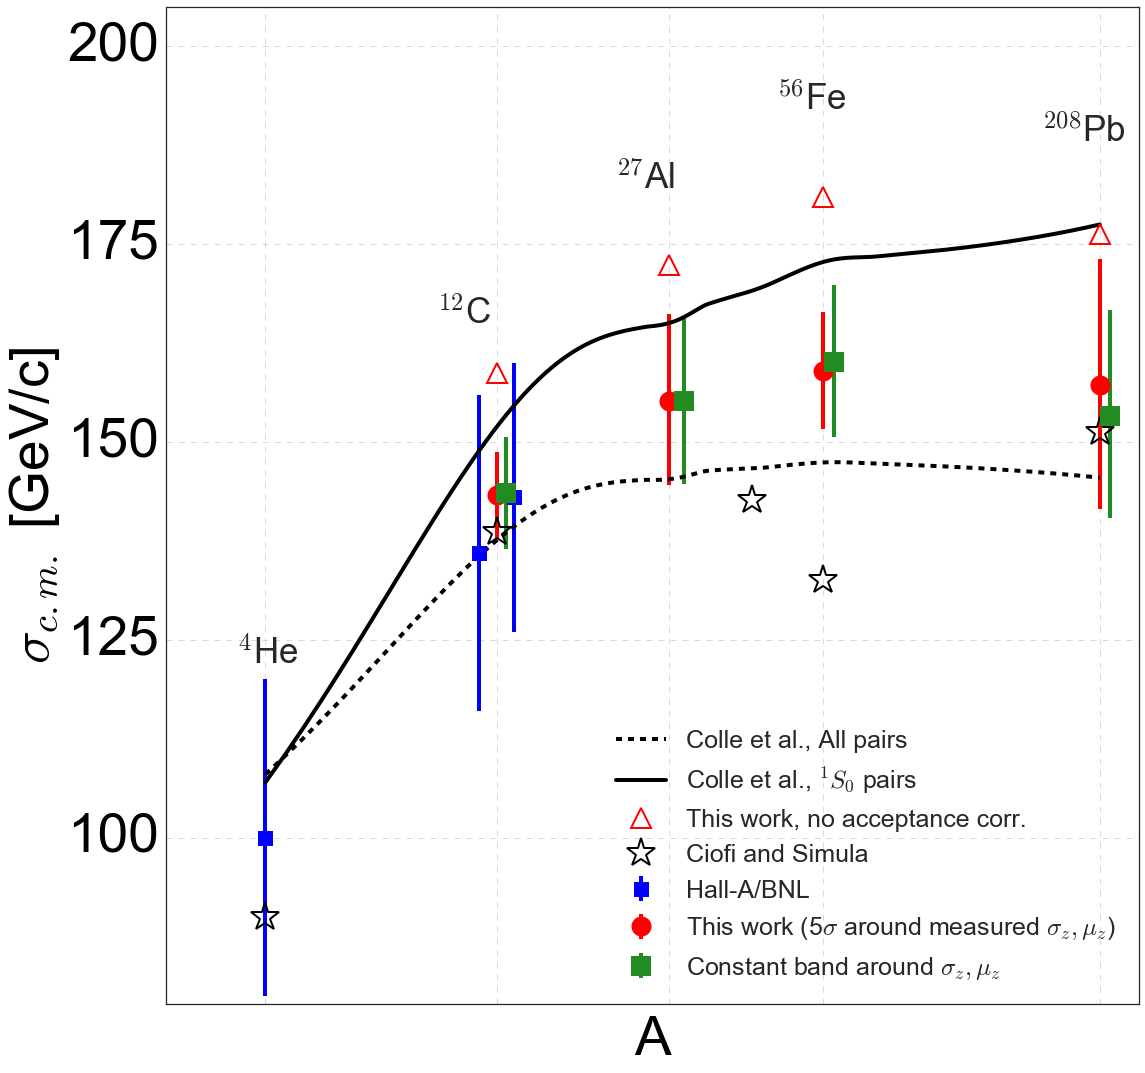

In [67]:
extraname='ConstBandAroundMeasuredValues'
label=r"Constant band around $\sigma_z,\mu_z$"
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(158,188), }),do_Ciofi=True)
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],direction='t',ax=ax, label=r"This work (5$\sigma$ around measured $\sigma_z,\mu_z$)" , marker='o', markersize=20 )
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],Ashift=[0.5,2,3,10], direction='t'+extraname,ax=ax, label=label , marker='s', markersize=20 , color='forestgreen')
plt.legend(fontsize=20,loc='upper left')
# measured
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
ax.legend(fontsize=25,loc='lower right')
plt.tight_layout()
plt.savefig(figures_path +'results_compare_'+extraname+'.pdf')

# compare mean(z) linear in $p_{miss}$ (slope$\times(p_{miss}-0.3)$) with 5 $\times \Delta_{measured}$

In [68]:
for Fiducials in ["PrecFiducials"]:
    for A,target in zip(As,targets):
        test_name = "MeanZLinearInPmiss_"+Fiducials+"_"+target
        simulation_results[test_name] = pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/final_simualtions_300Pmiss600/"+test_name+".csv")
        simulation_results[test_name].fillna(-1,inplace=True)
        print len(simulation_results[test_name]),'events in ',test_name

38400 events in  MeanZLinearInPmiss_PrecFiducials_C
38400 events in  MeanZLinearInPmiss_PrecFiducials_Al
38400 events in  MeanZLinearInPmiss_PrecFiducials_Fe
38400 events in  MeanZLinearInPmiss_PrecFiducials_Pb


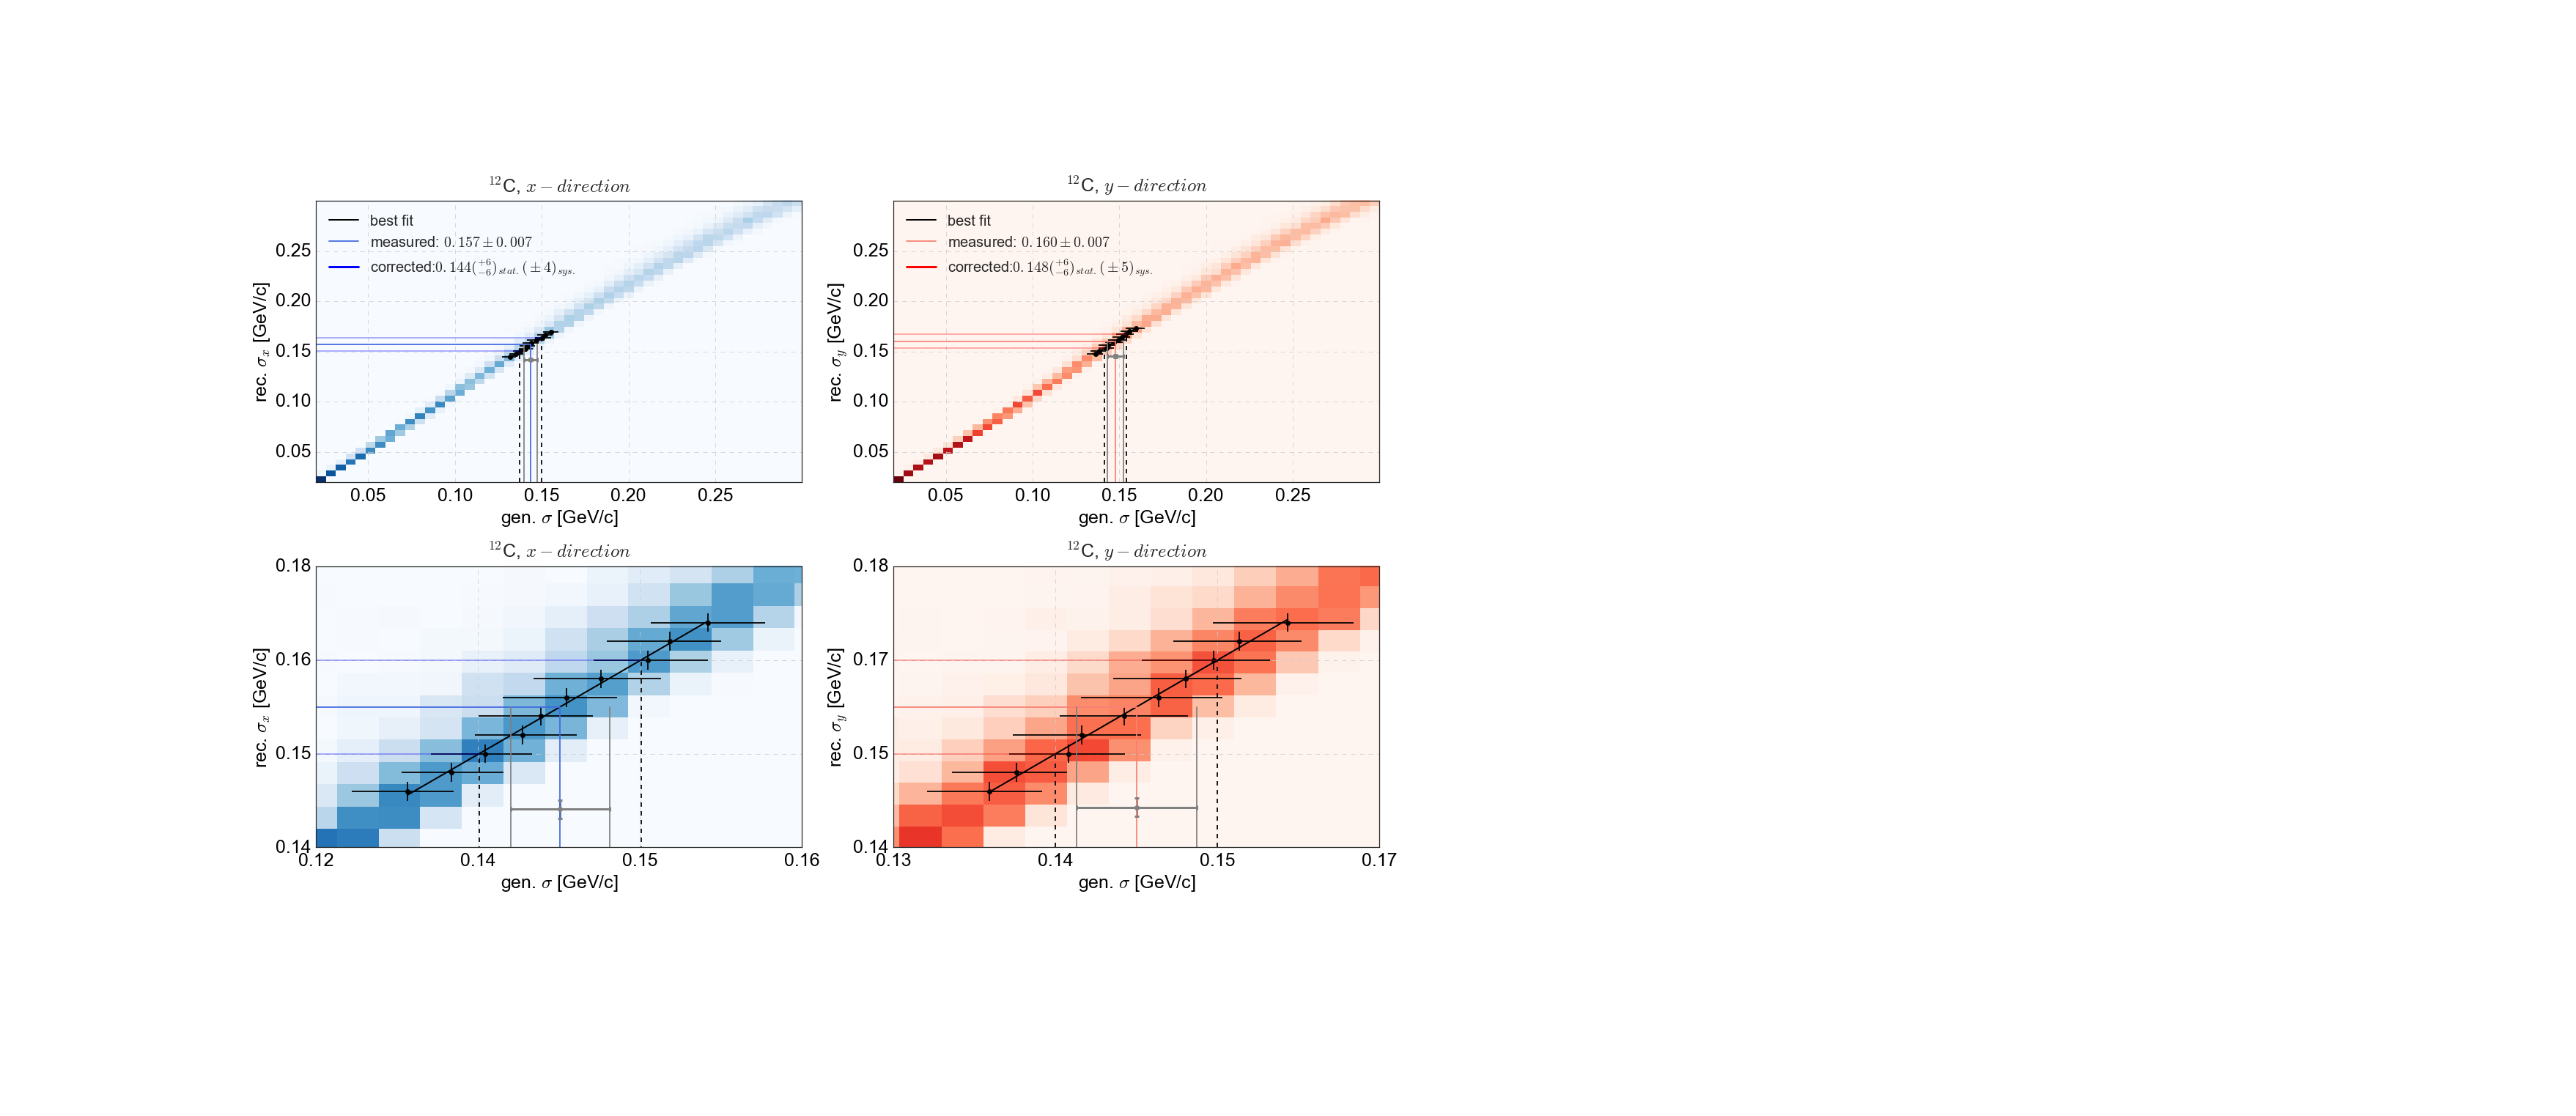

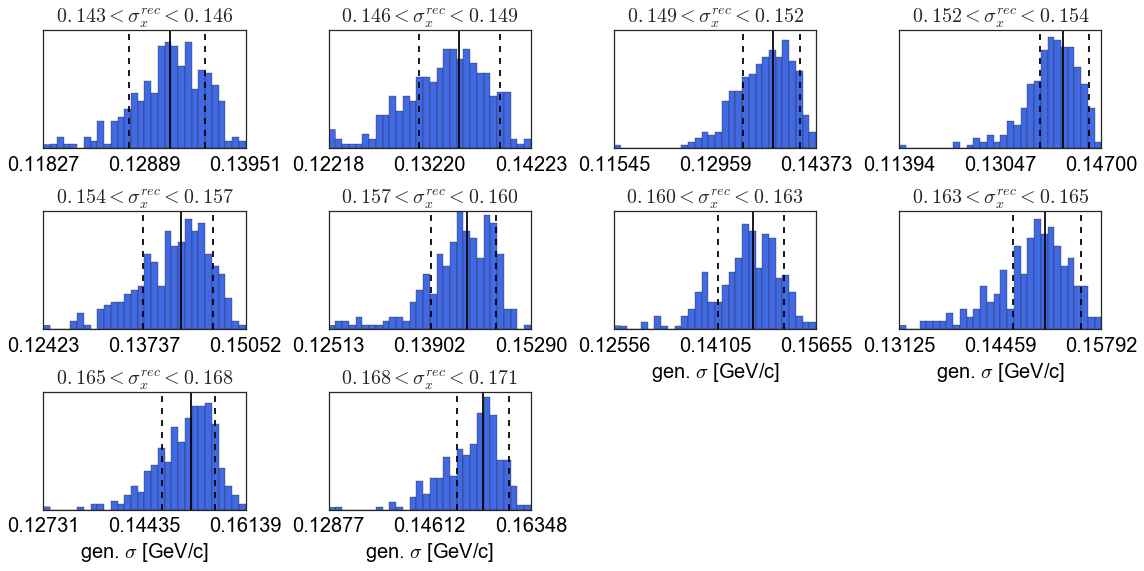

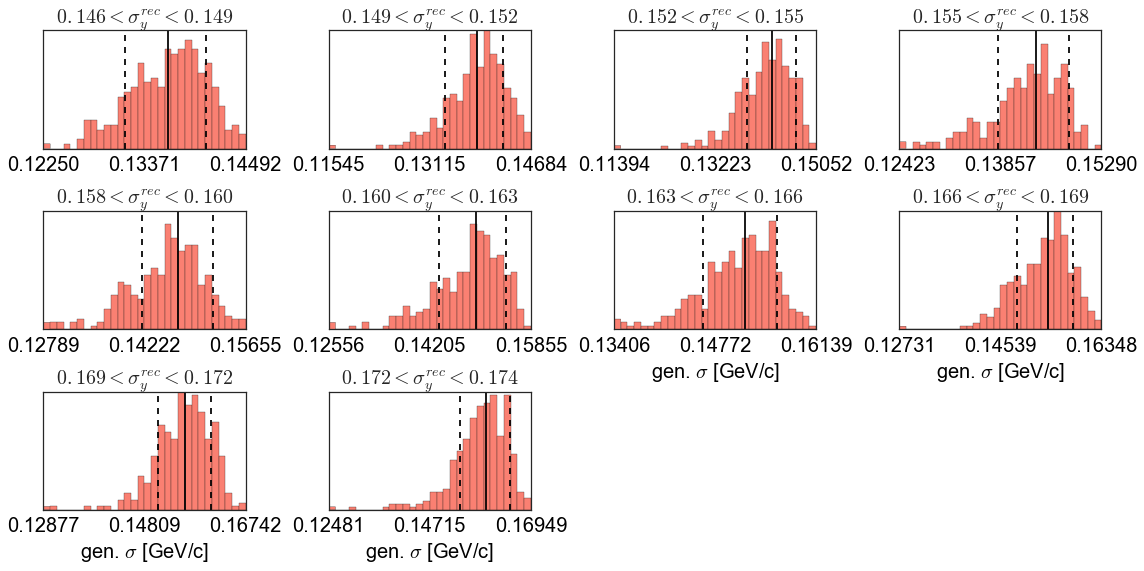

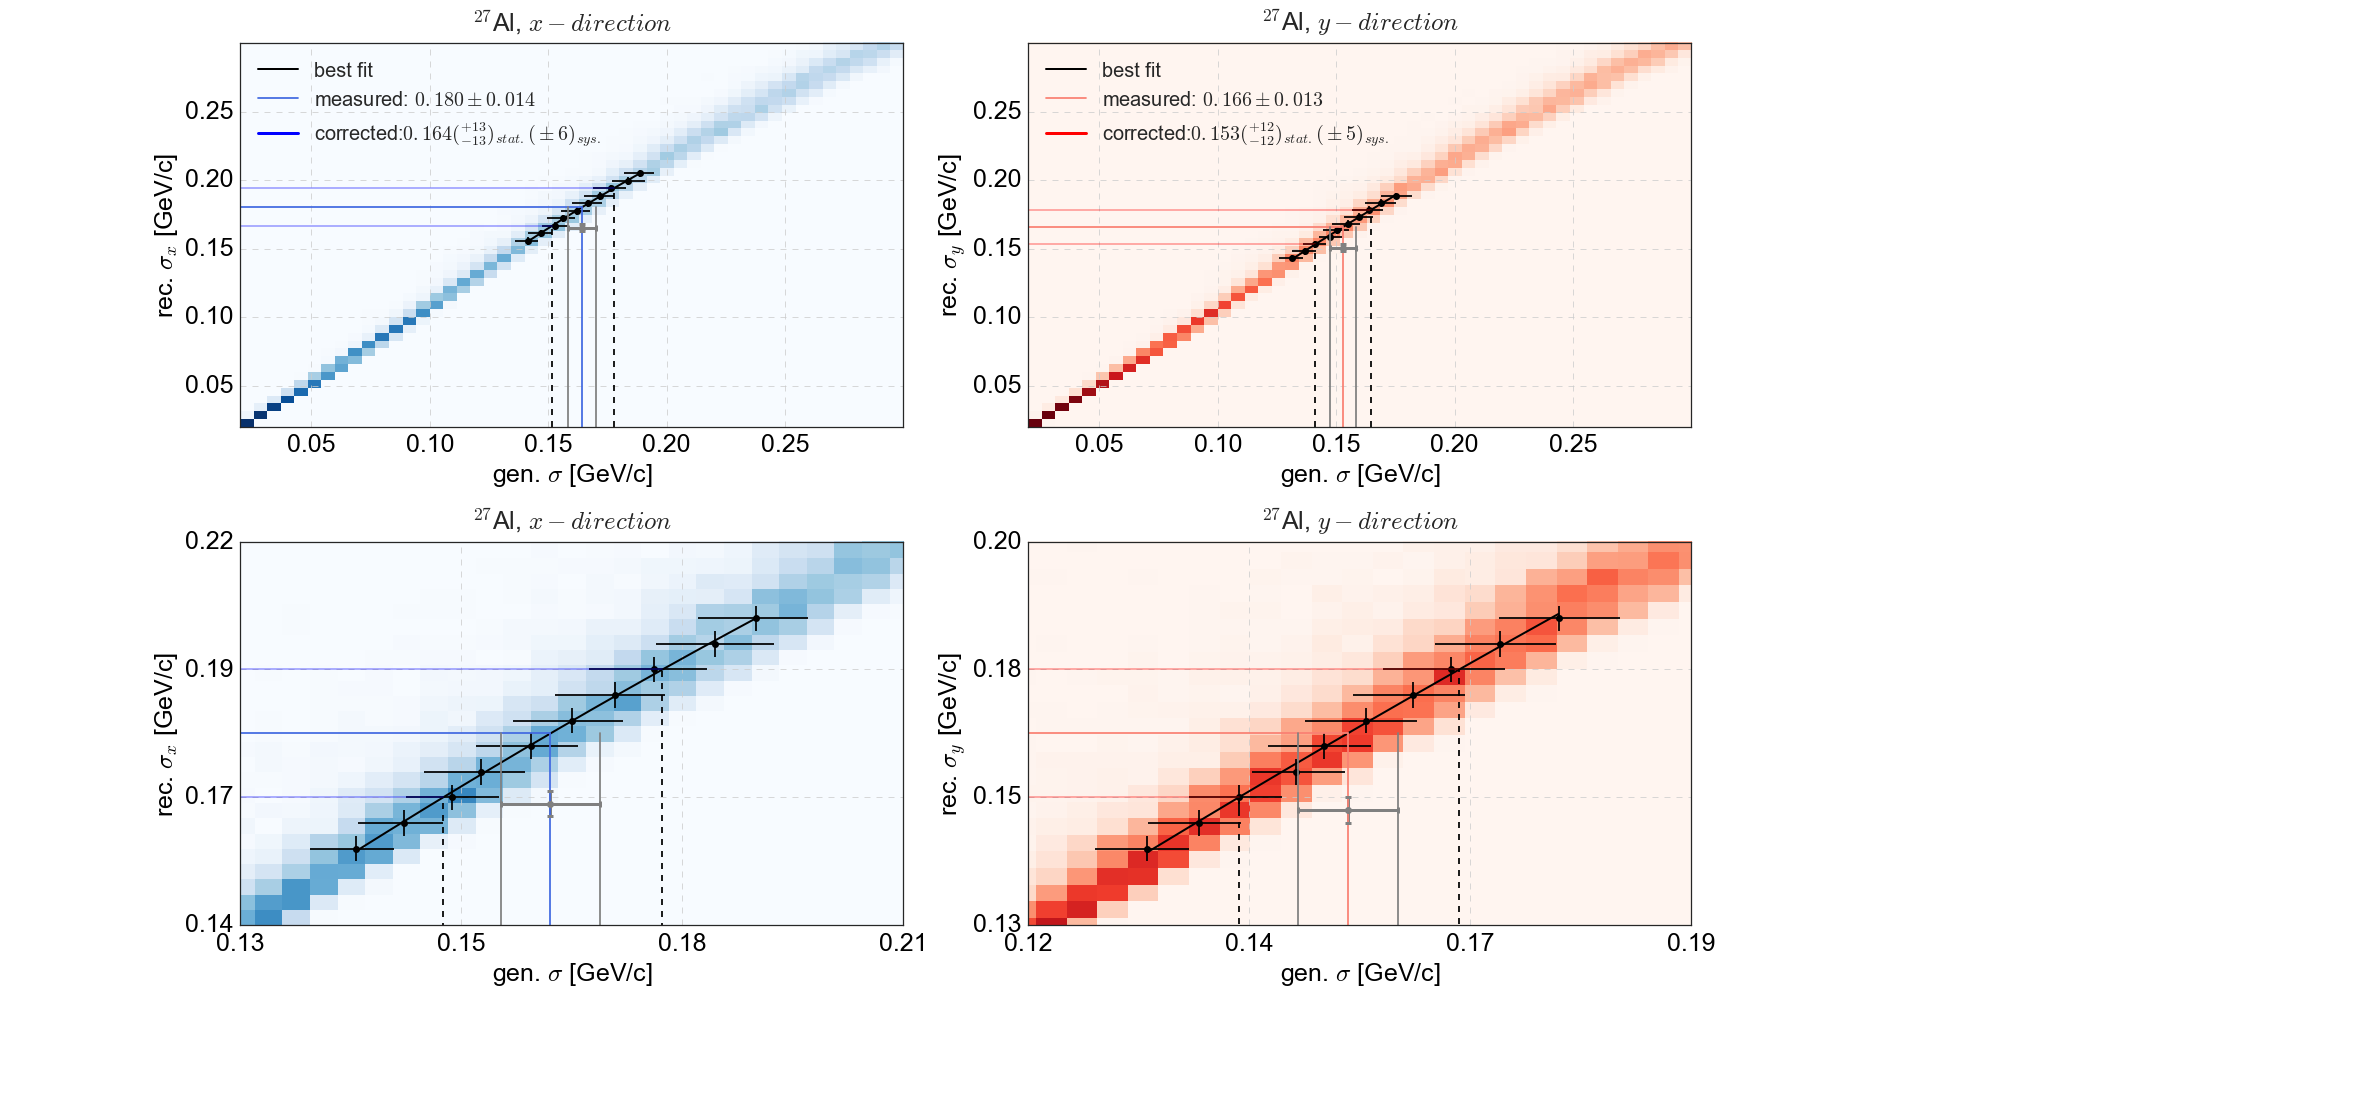

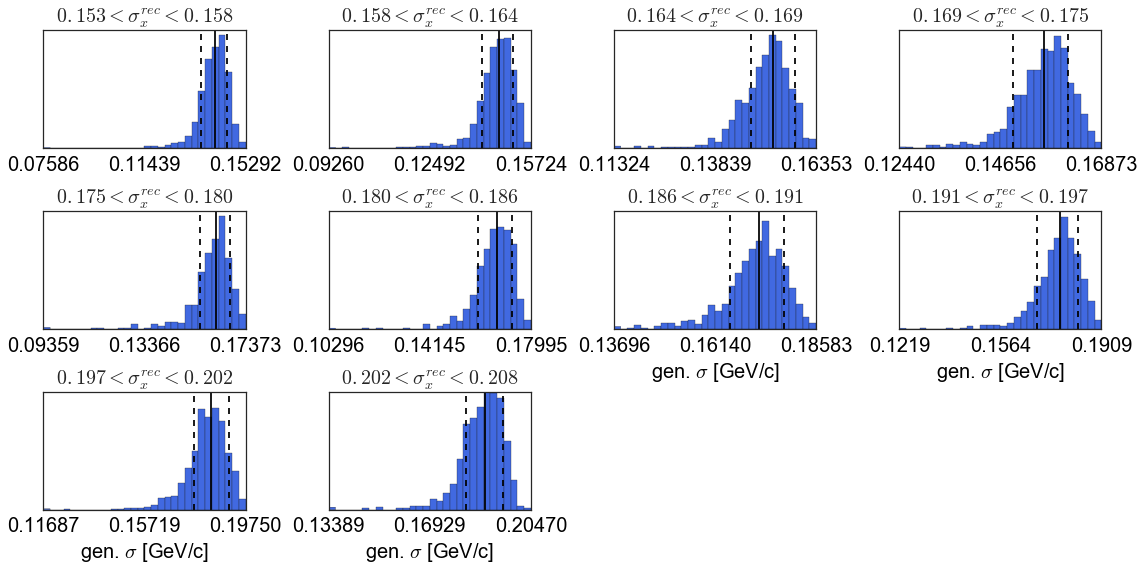

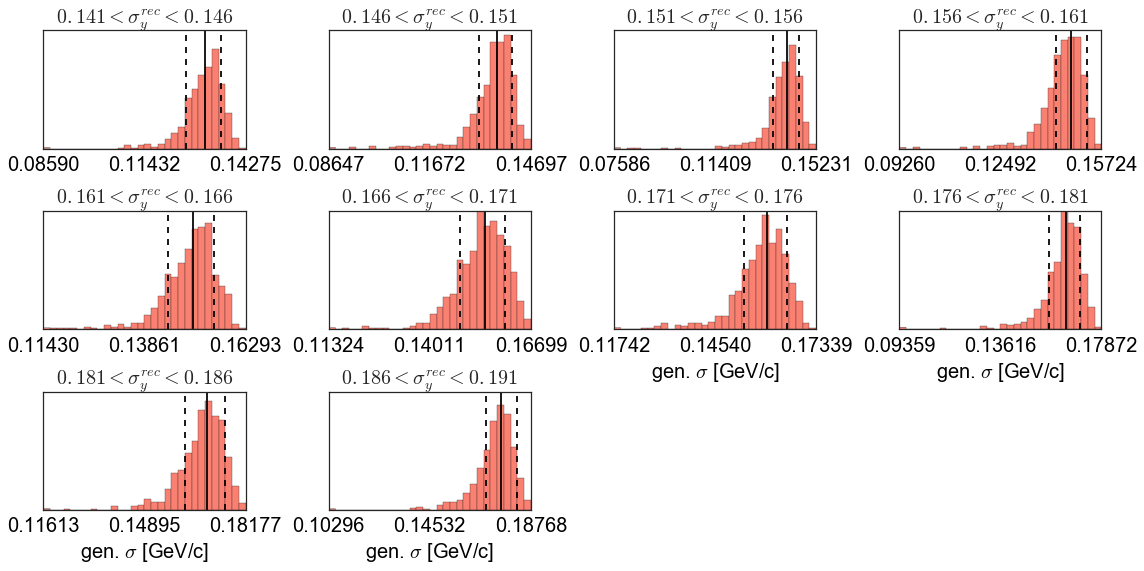

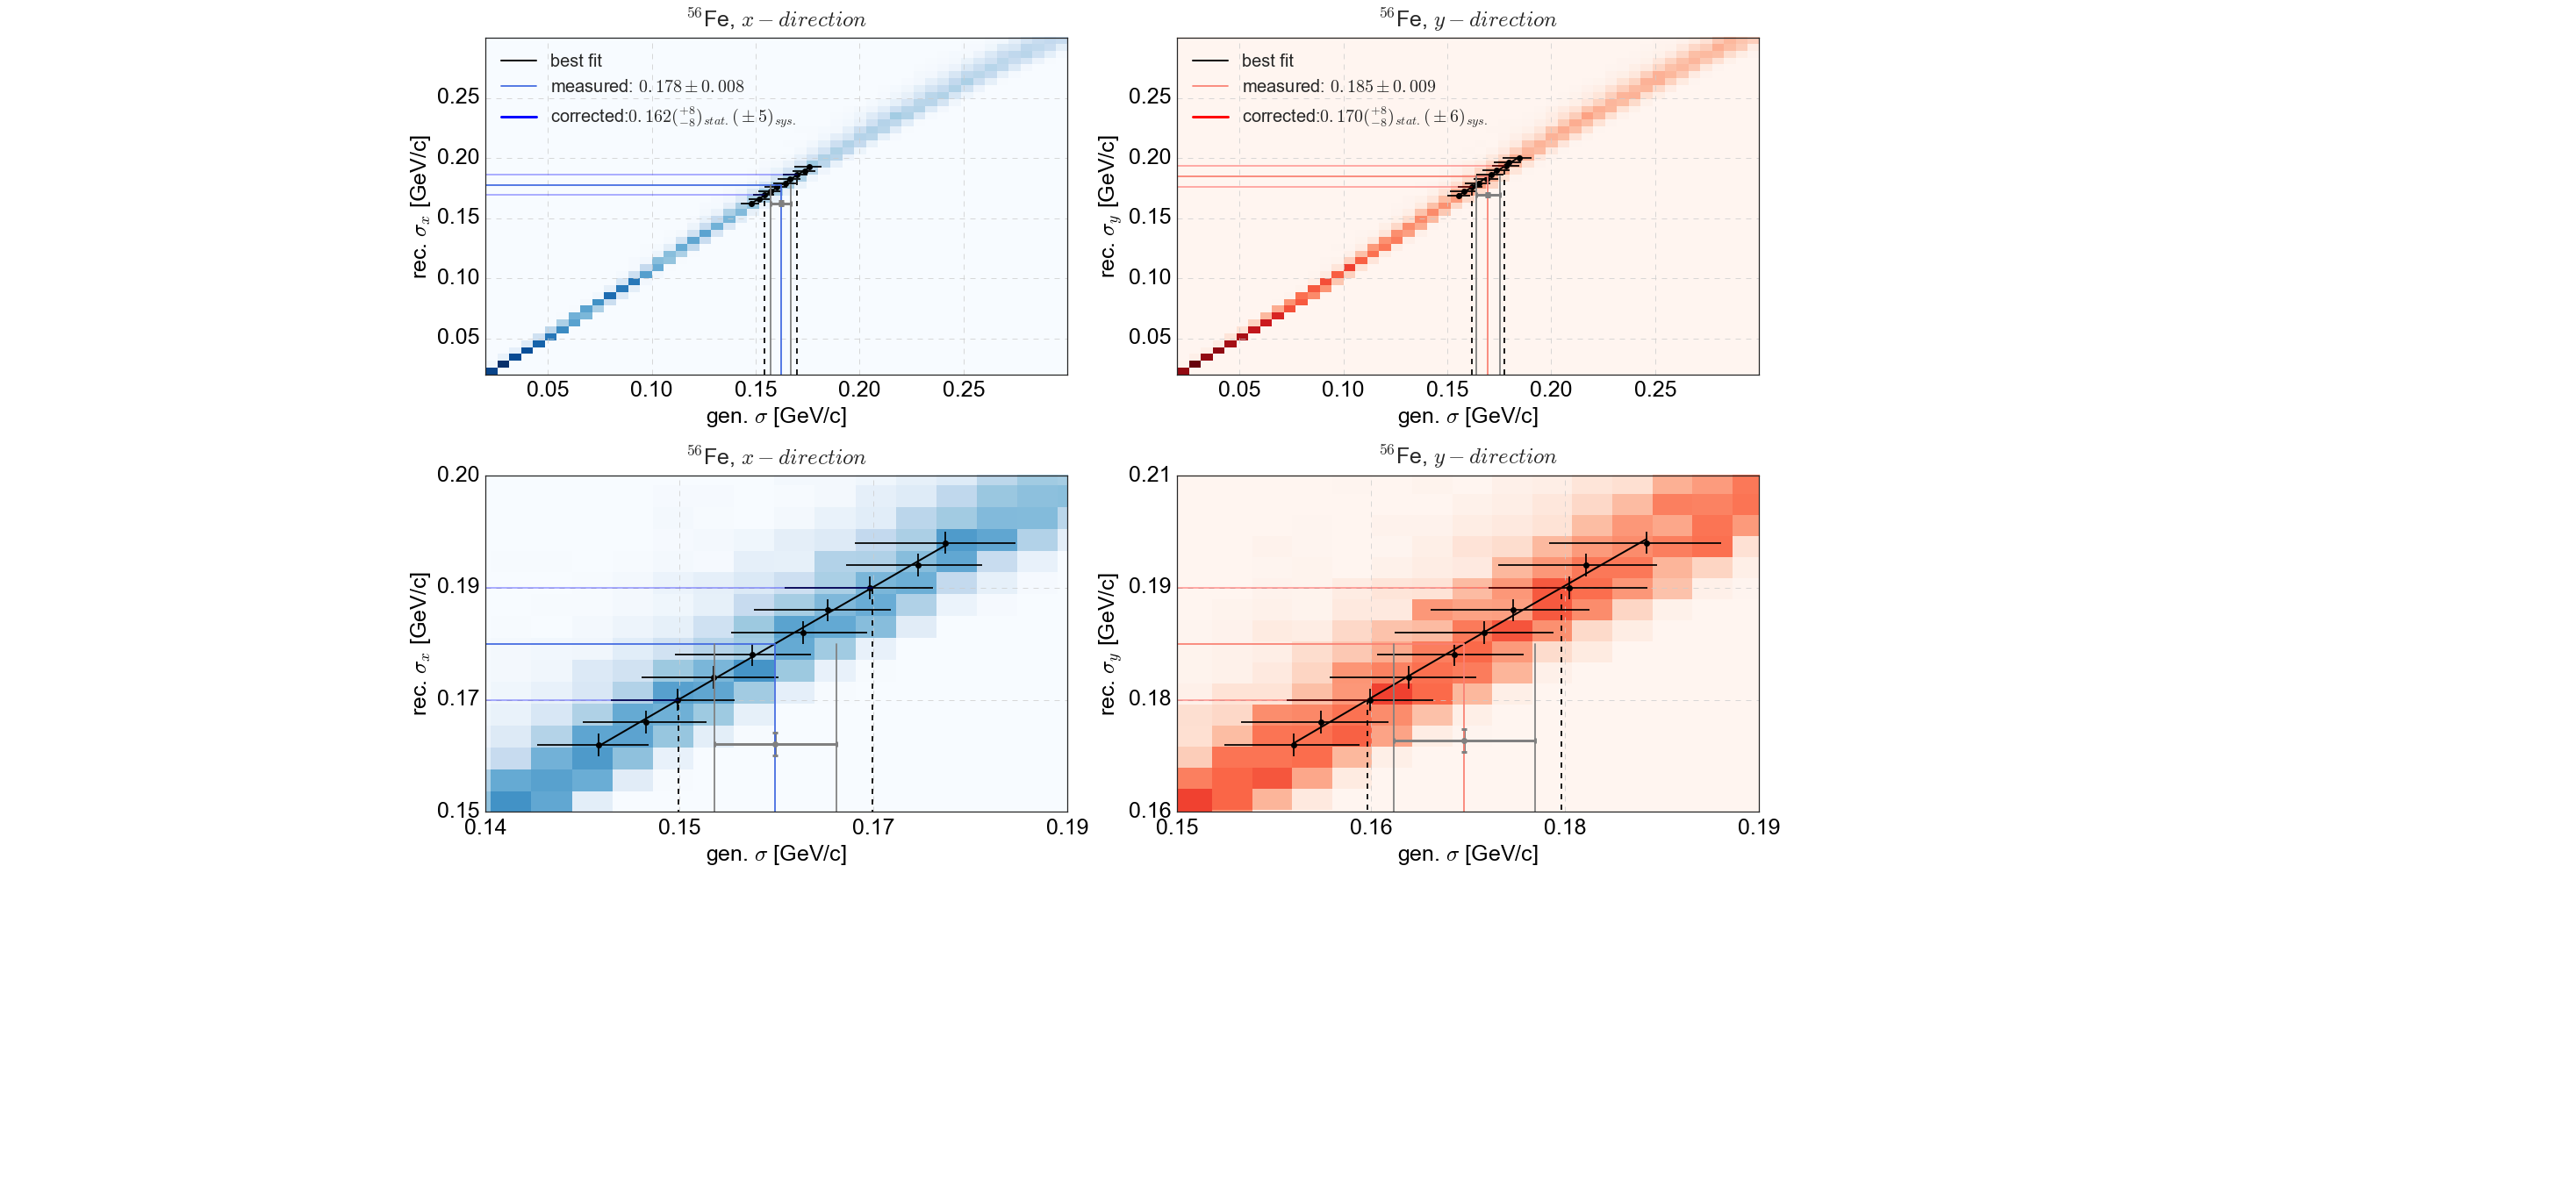

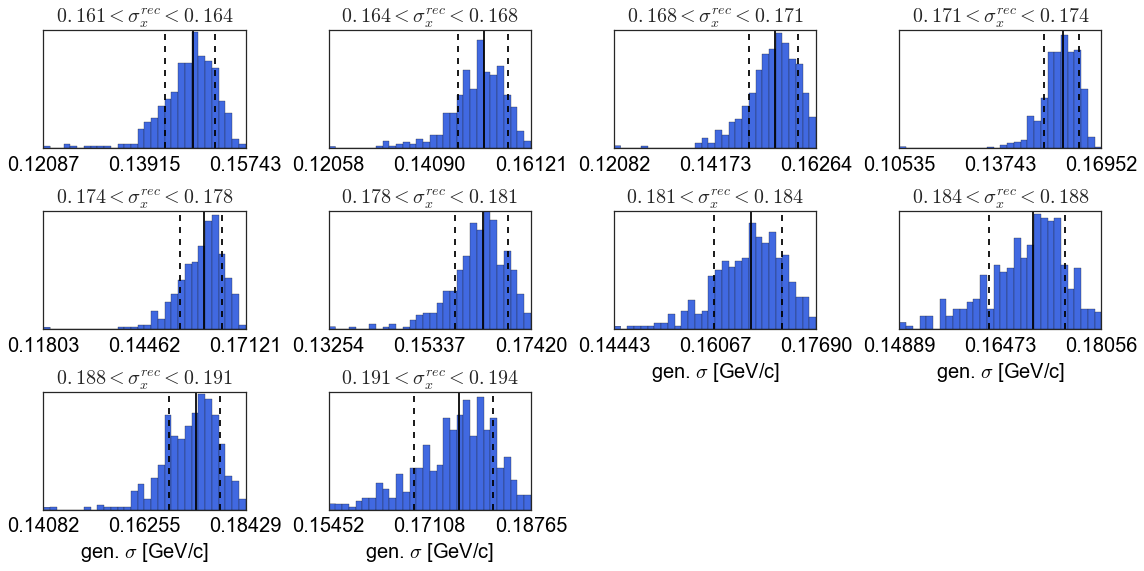

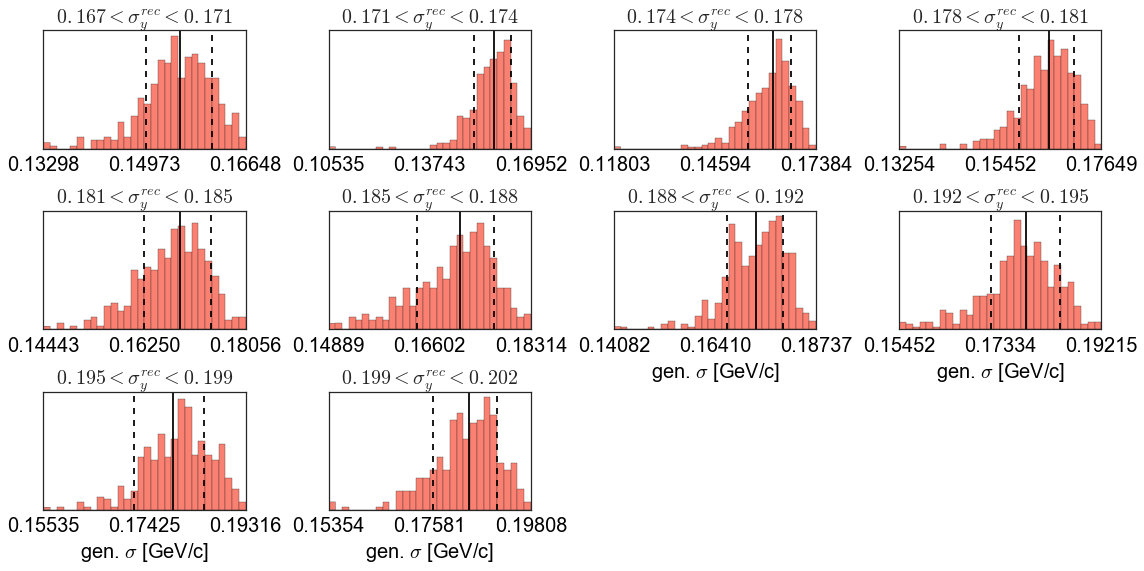

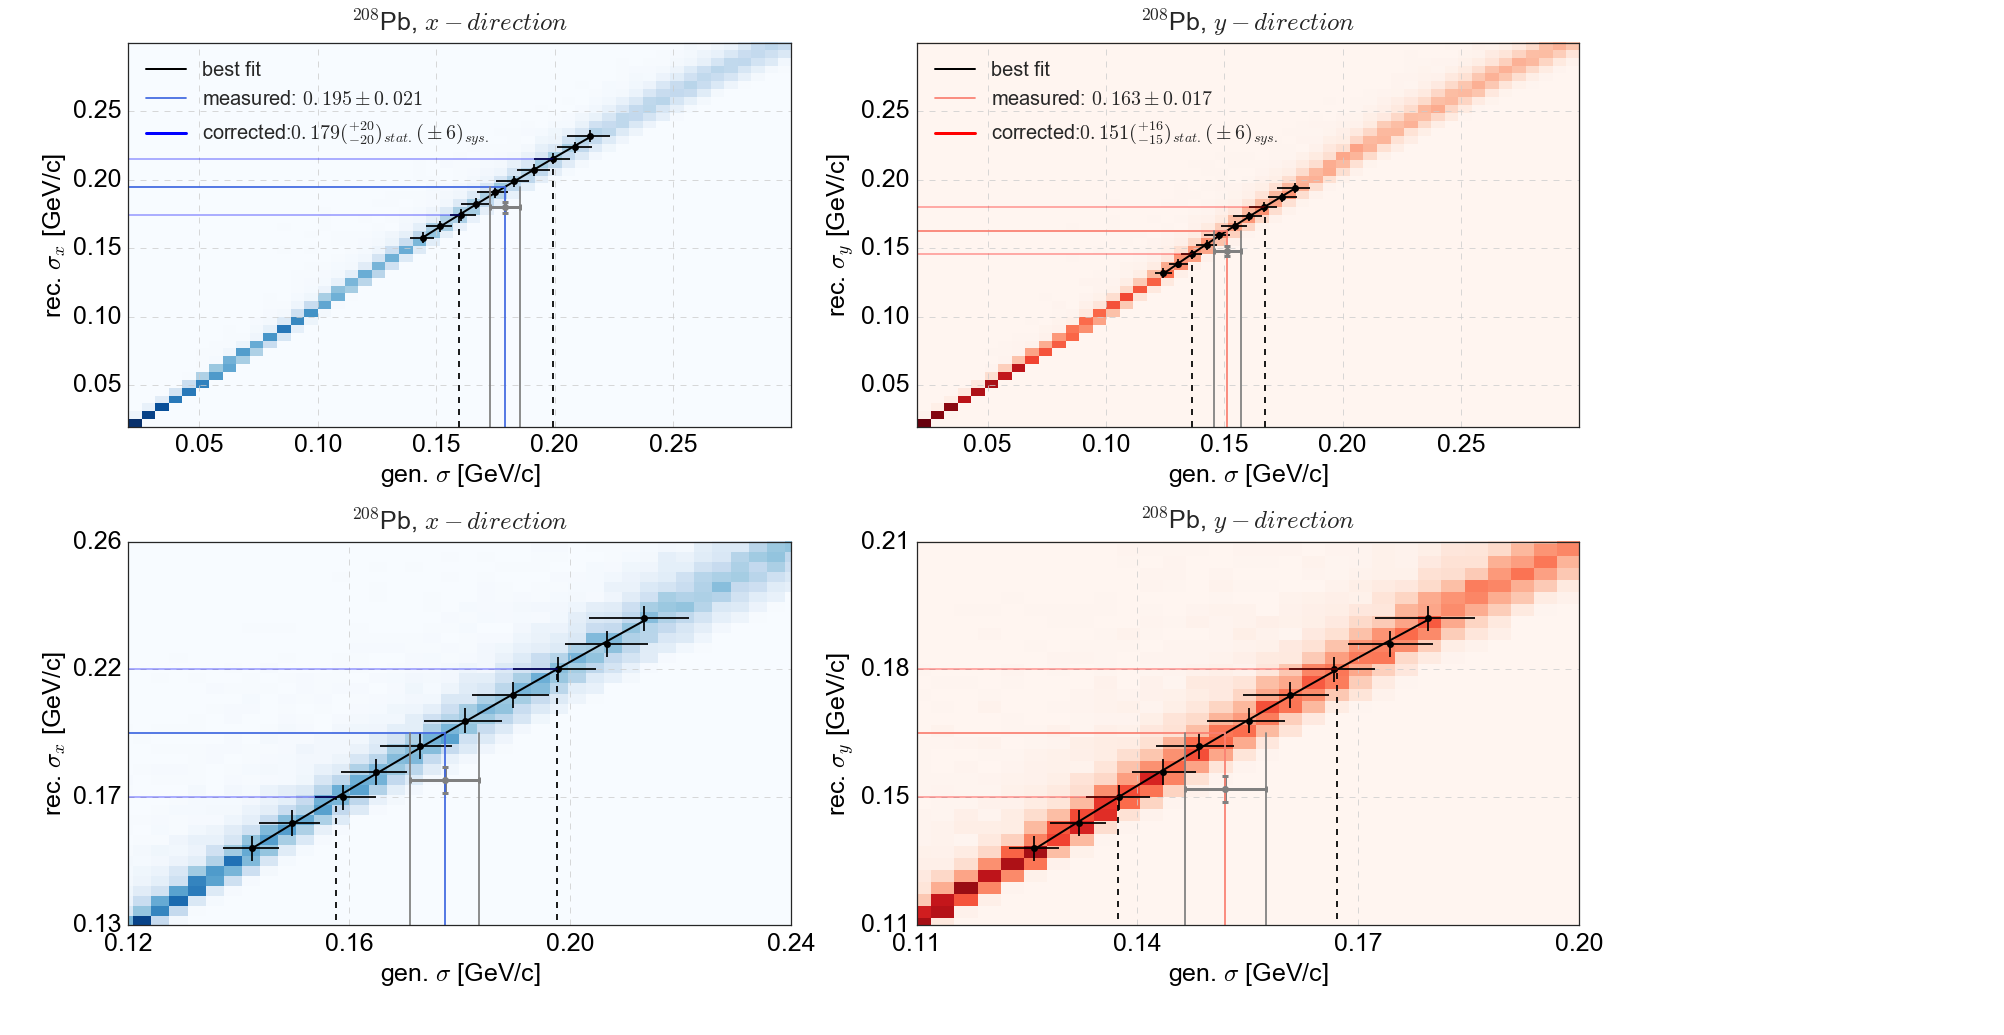

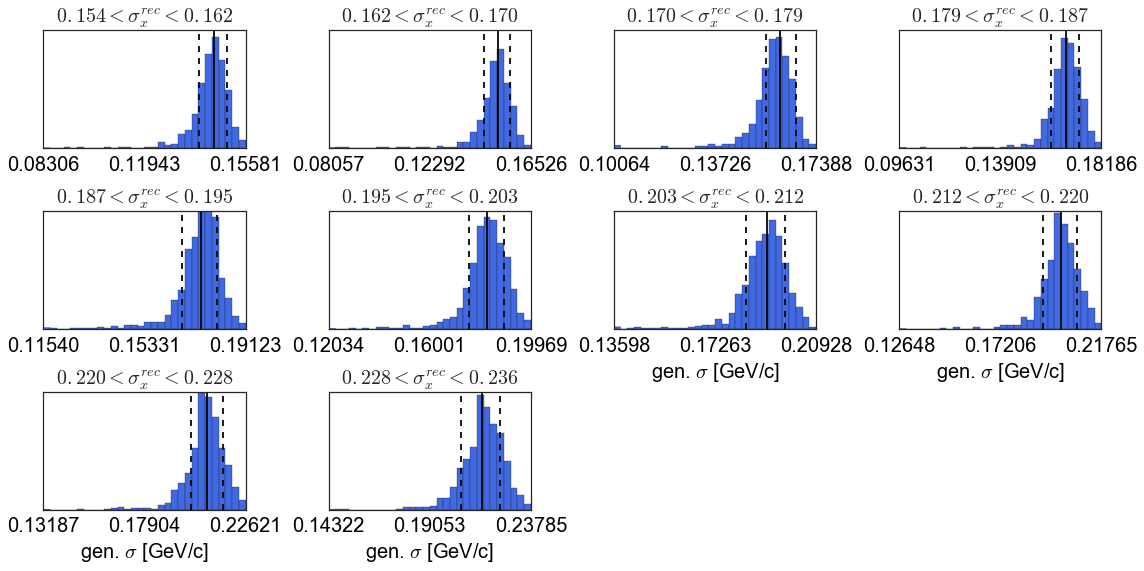

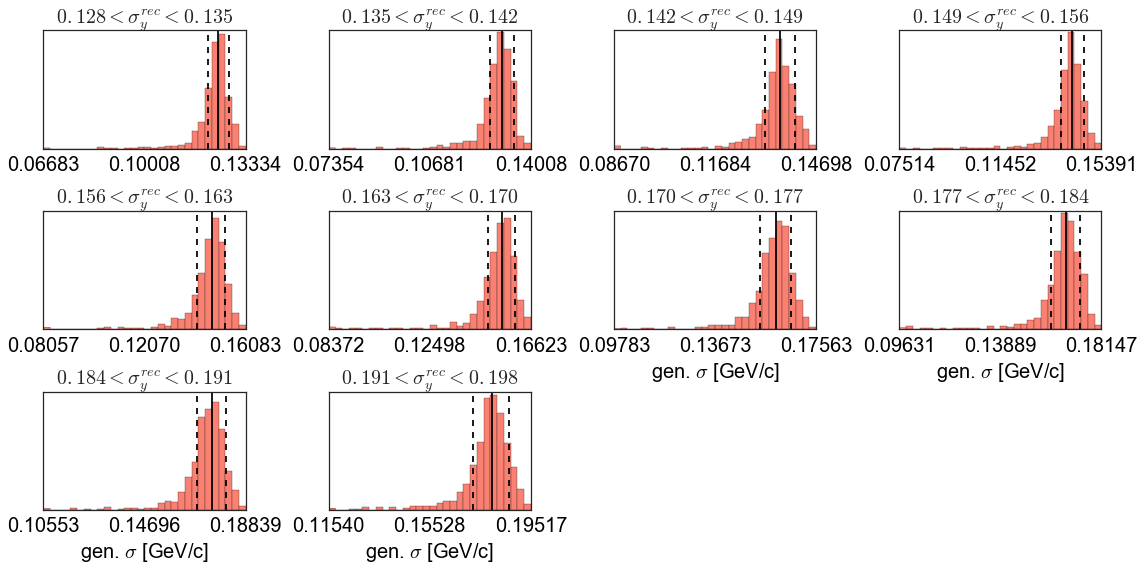

In [69]:
poly_degree = 2 # fit polynomial degree
extraname='MeanZLinearInPmiss'
for i,(A,target) in enumerate(zip(As[0:],targets[0:])):
    test_name = extraname+"_"+Fiducials+"_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    fig=plt.figure(figsize=(22,14))
    ax=fig.add_subplot(2,2,1)    
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,3)    
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    ax=fig.add_subplot(2,2,2)
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,4)
    plot_cm_direction_binned_confidence68(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    fig.subplots_adjust(bottom=-0.5,left=-0.2)
    fig.tight_layout() 
    filename = figures_path+'St_gen_rec_'+target+'_'+extraname+'.png'    
    fig.savefig( filename )

In [70]:
sample = cm_parameters_with_correction['PrecFiducials']
extraname='MeanZLinearInPmiss'

for direction in ['x','y']:
    sample['sigma_'+direction+extraname+'_final'] = sample['sigma_'+direction+'_corrected'+extraname]
    for updw in ['up','dw']:
        sample['sigma_'+direction+extraname+'_final_'+updw+'_err'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot'+extraname]

corr_x = sample['sigma_x_corrected'+extraname]
Dcorr_x = sample['sigma_x_corrected_err_tot'+extraname]

corr_y = sample['sigma_y_corrected'+extraname]
Dcorr_y = sample['sigma_y_corrected_err_tot'+extraname]

# weighted average
corr_t = (corr_x/np.square(Dcorr_x)+corr_y/np.square(Dcorr_y))/( 1./np.square(Dcorr_x) + 1./np.square(Dcorr_y))
sample['sigma_t'+extraname+'_final'] = corr_t
    
Dsys_x = sample['sigma_x_corrected_err_sys'+extraname]
Dsys_y = sample['sigma_y_corrected_err_sys'+extraname]
Dsys_t = 0.5*( Dsys_x + Dsys_y )
sample['sigma_t'+extraname+'_final_err_sys'] = Dsys_t

for updw in ['up','dw']:            
    Dstat_x = sample['sigma_x_corrected_'+updw+'_err_stat'+extraname]
    Dstat_y = sample['sigma_y_corrected_'+updw+'_err_stat'+extraname]
    Dstat_t = np.sqrt(1./( 1./np.square(Dstat_x) + 1./np.square(Dstat_y) ))
    sample['sigma_t'+extraname+'_final_'+updw+'_err_stat'] = Dstat_t

    Dtot_t = np.sqrt( np.square(Dstat_t) + np.square(Dsys_t) )
    sample['sigma_t'+extraname+'_final_'+updw+'_err_tot'] = Dtot_t
    sample['sigma_t'+extraname+'_final_'+updw+'_err'] = Dtot_t

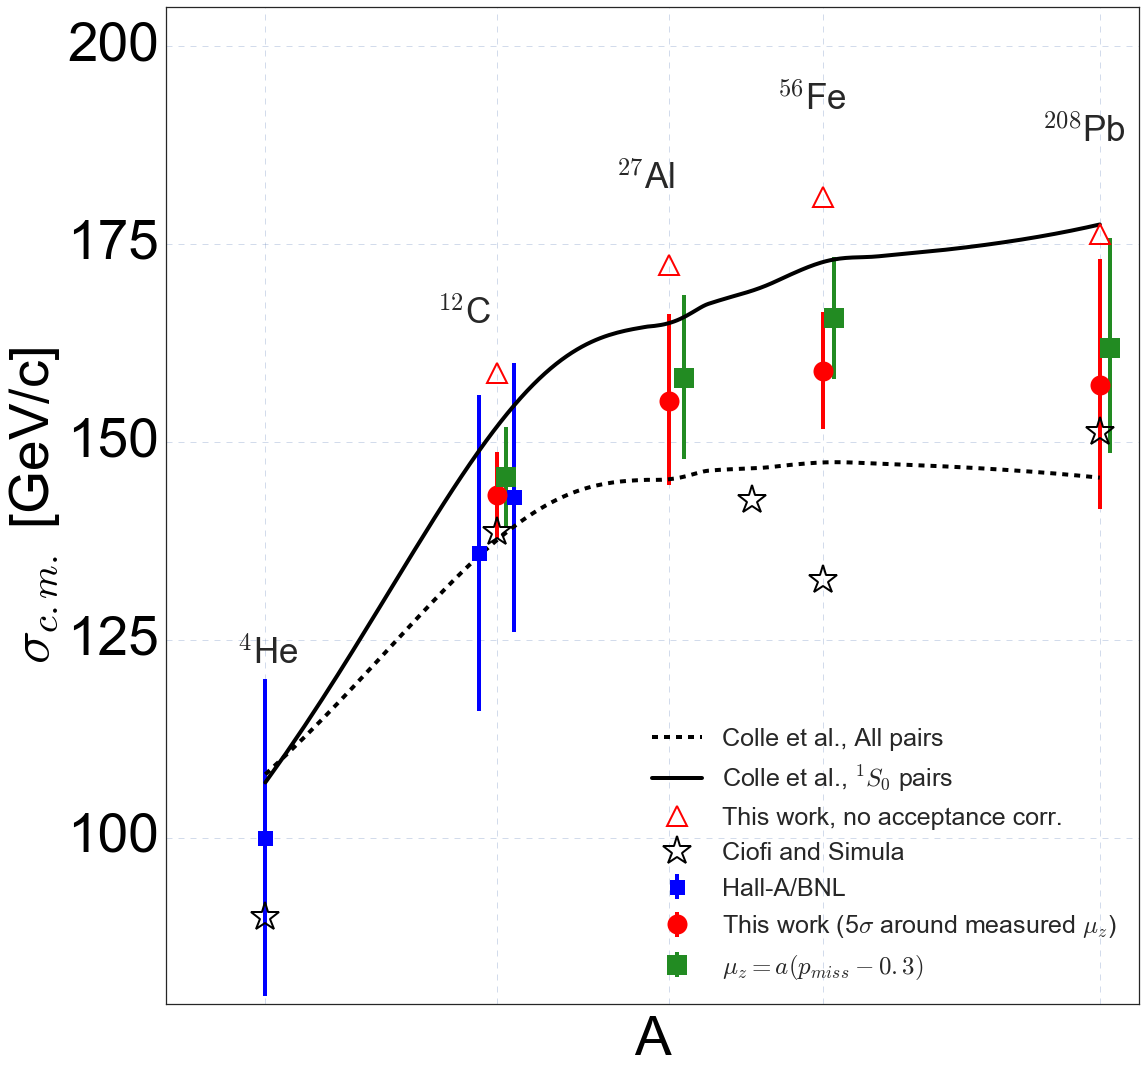

In [71]:
extraname='MeanZLinearInPmiss'
label=r"$\mu_{z}=a(p_{miss}-0.3)$"
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(158,188), }),do_Ciofi=True)
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],direction='t',ax=ax, label=r"This work (5$\sigma$ around measured $\mu_z$)" , marker='o', markersize=20 )
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],Ashift=[0.5,2,3,10], direction='t'+extraname,ax=ax, label=label , marker='s', markersize=20 , color='forestgreen')
plt.legend(fontsize=20,loc='upper left')
# measured
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
ax.legend(fontsize=25,loc='lower right')
plt.tight_layout()
plt.savefig(figures_path +'results_compare_'+extraname+'.pdf')

# compare the method that looks for the minimal window with 68% confidence integral in each bin to the method of mean and rms
The quasi-data point would be the mean value of $\sigma_{gen}$ in this bin,
and the uncertaintly would be the distance from the right and left sides of the 68% interval

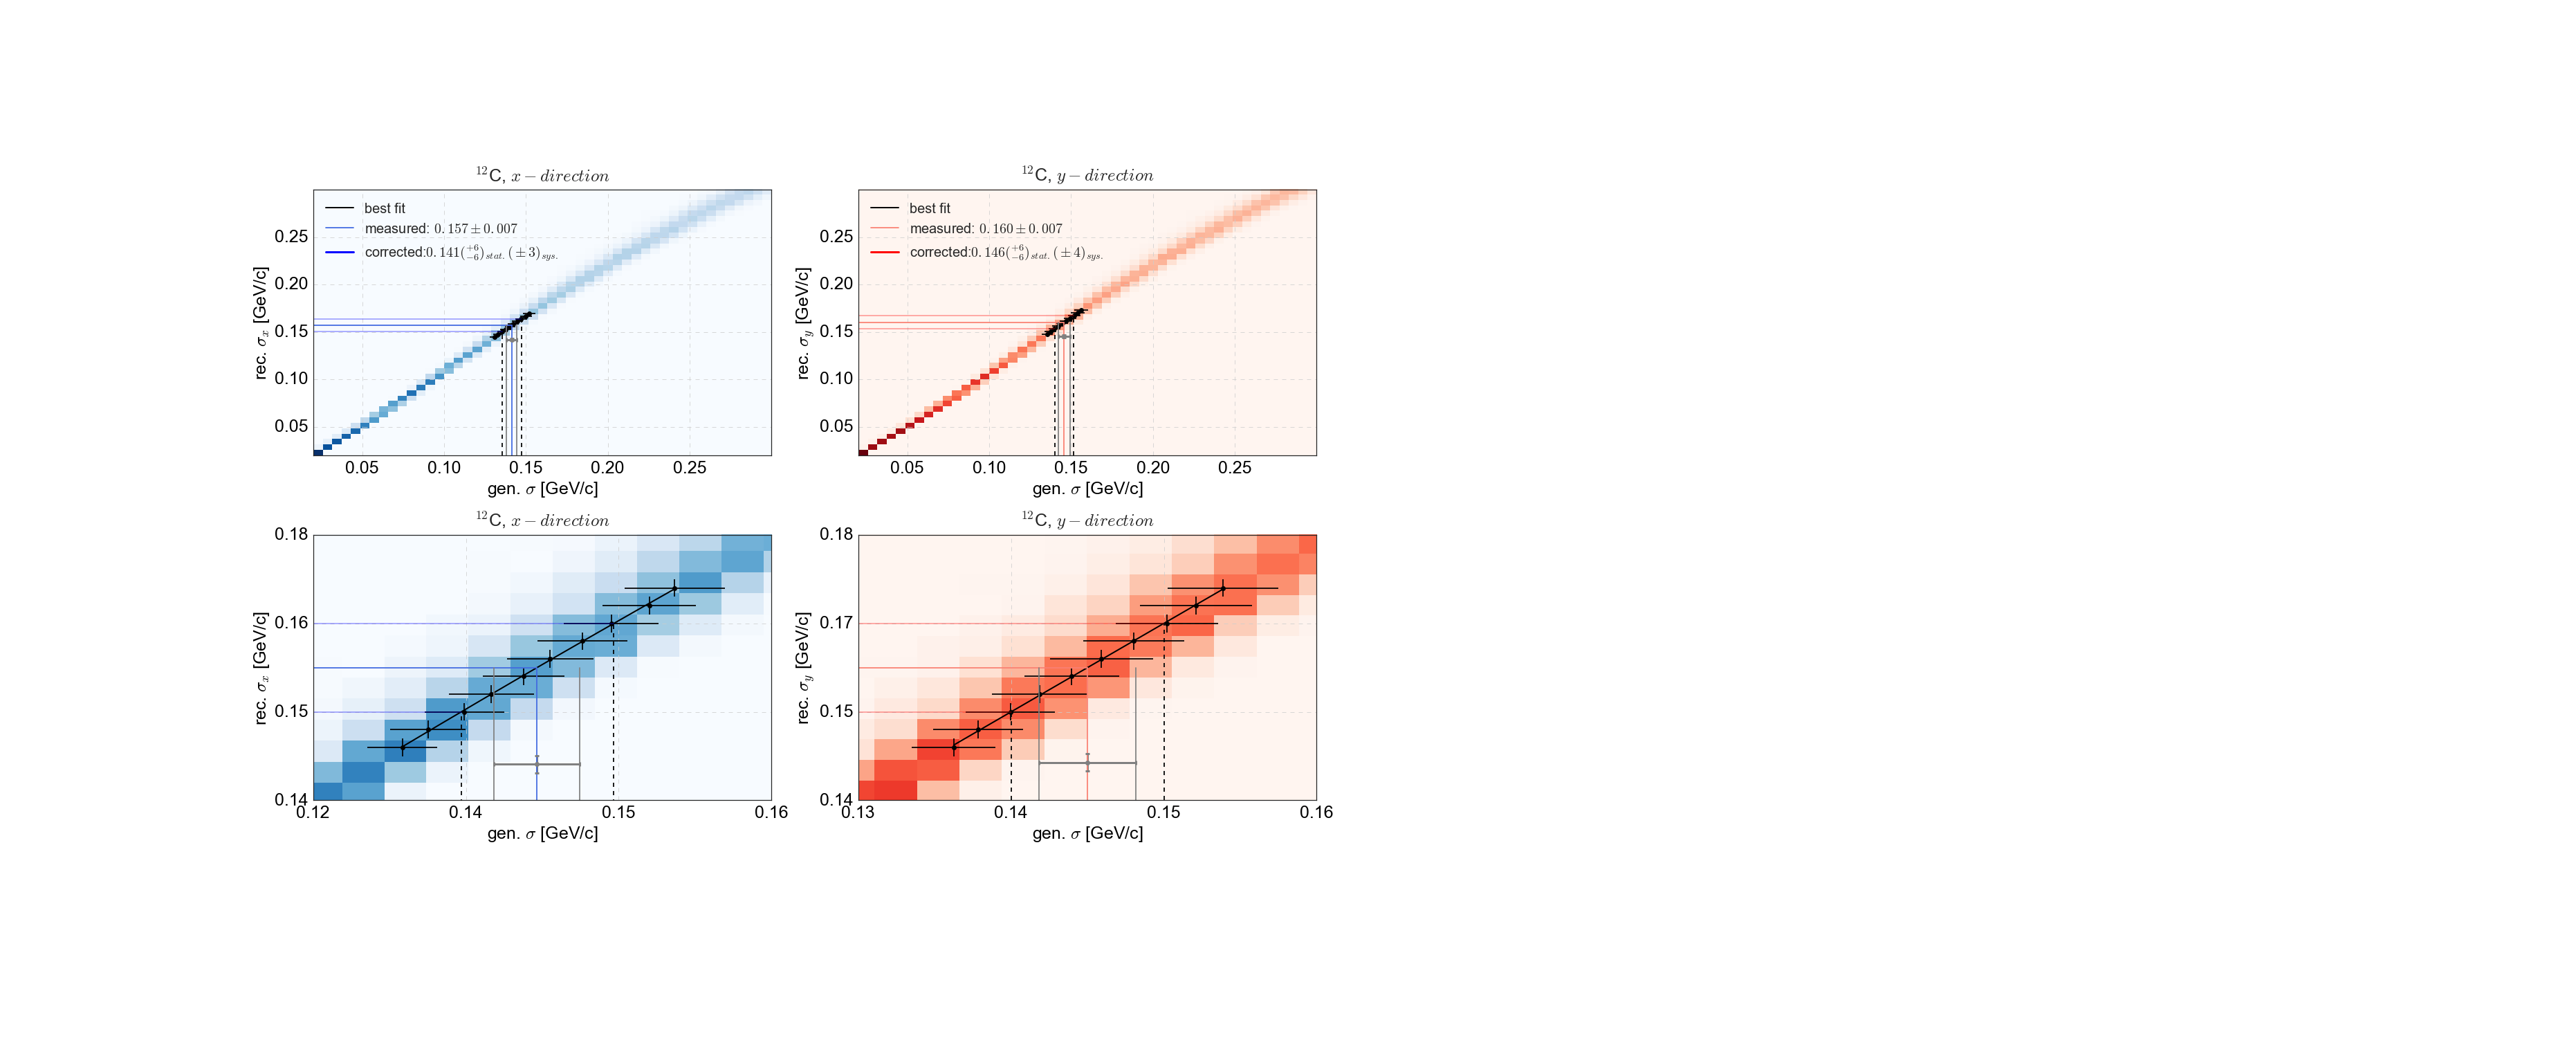

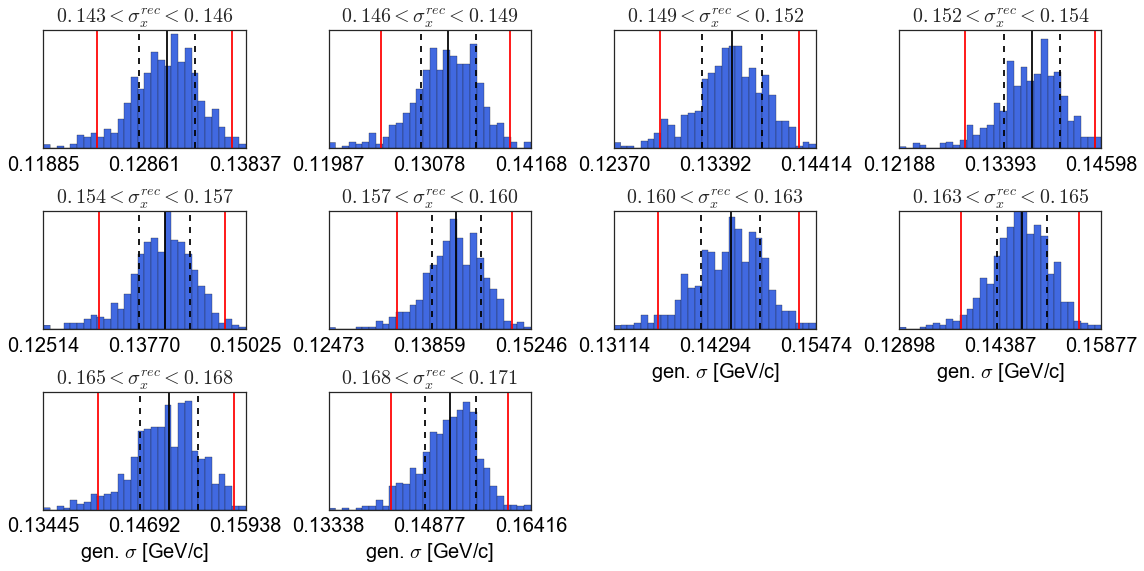

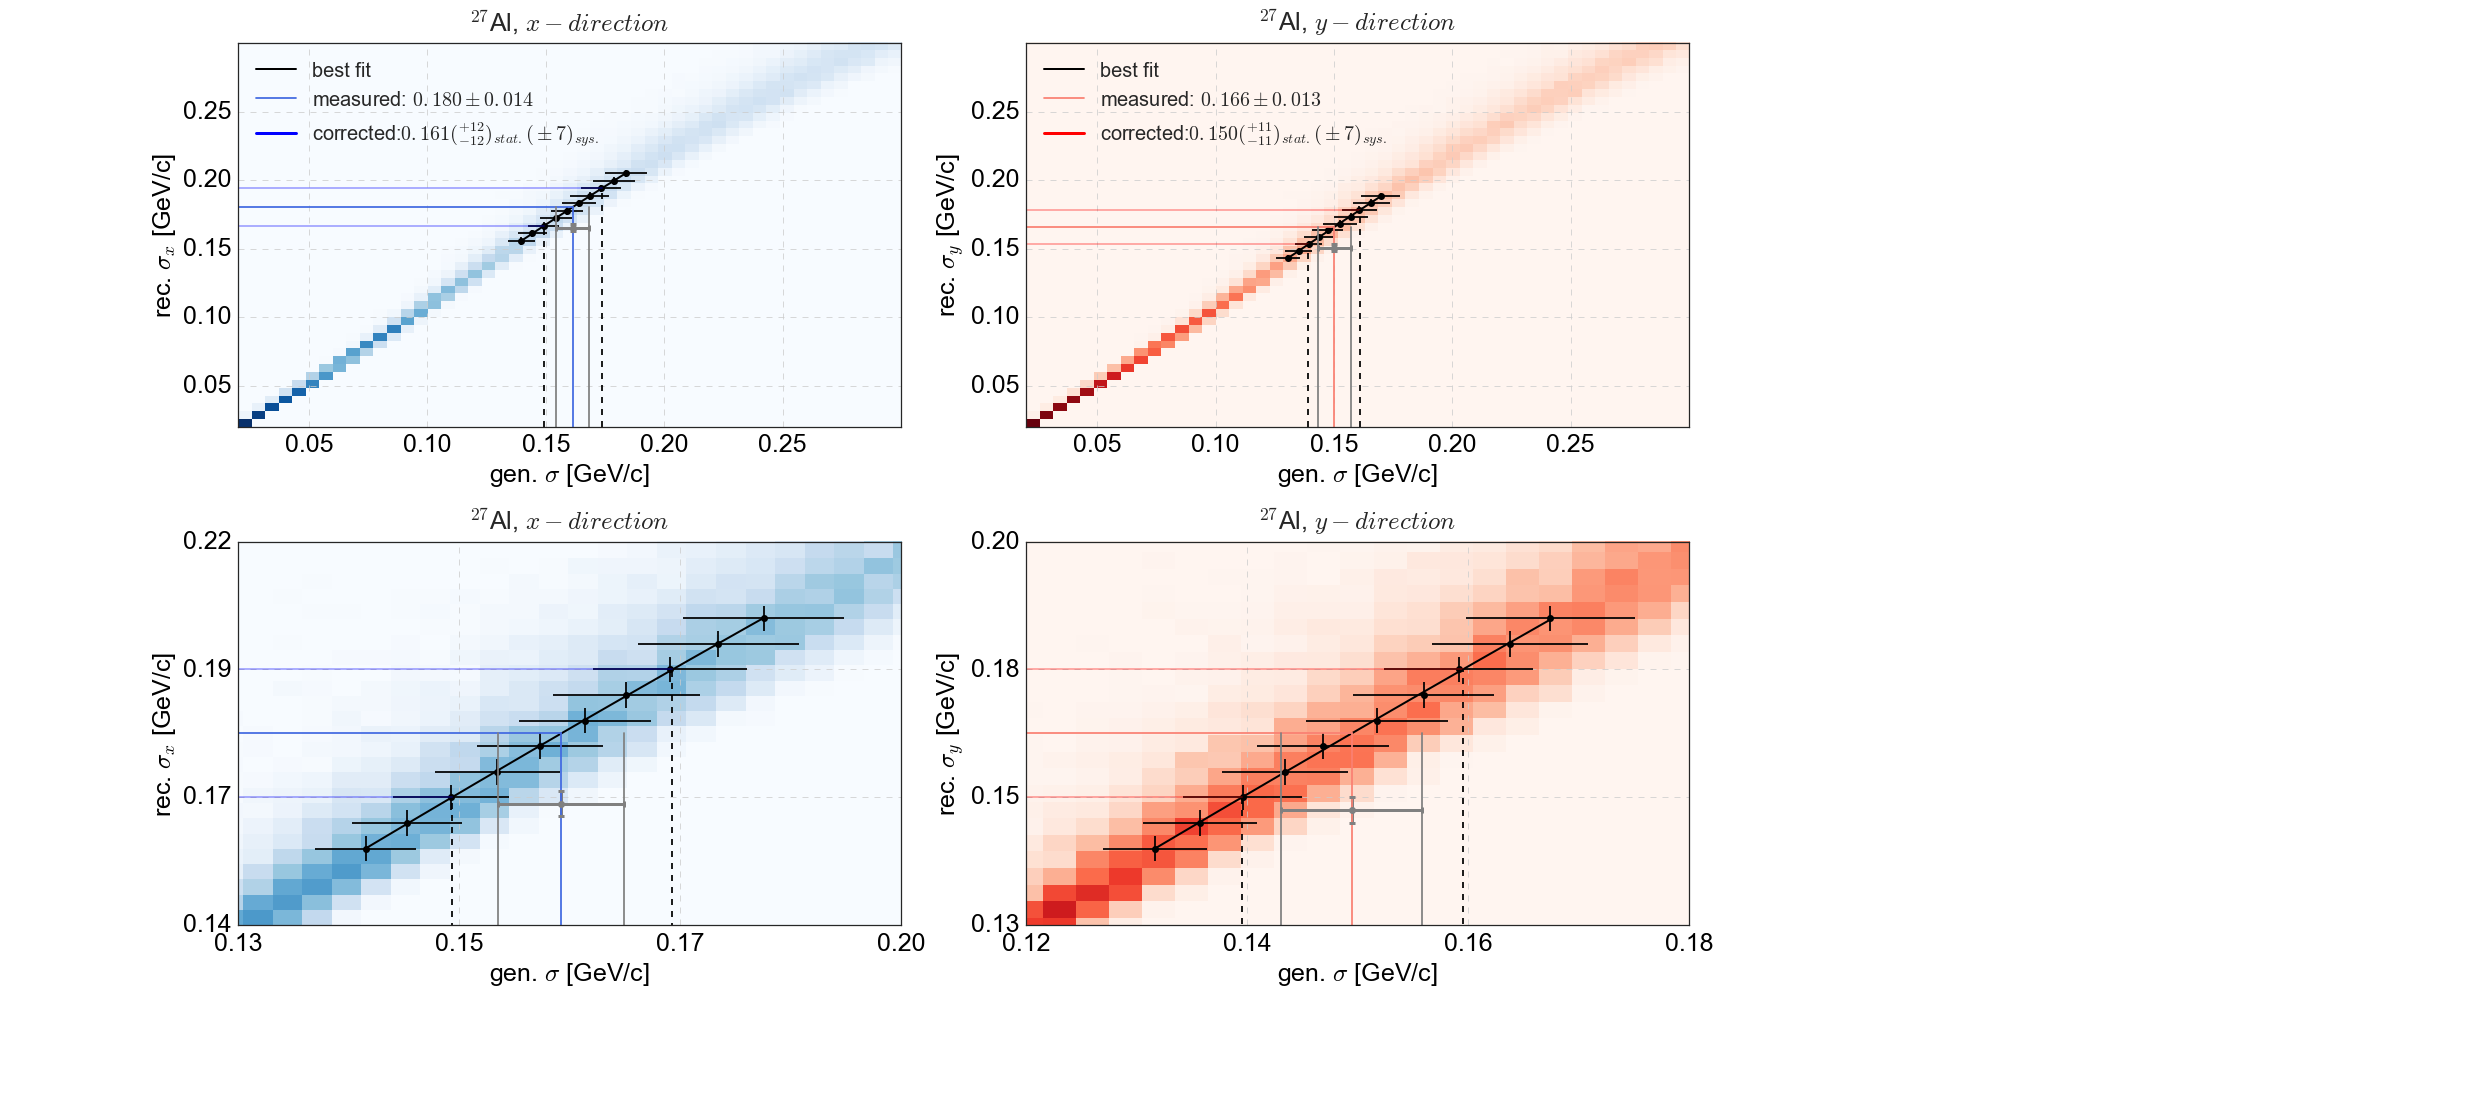

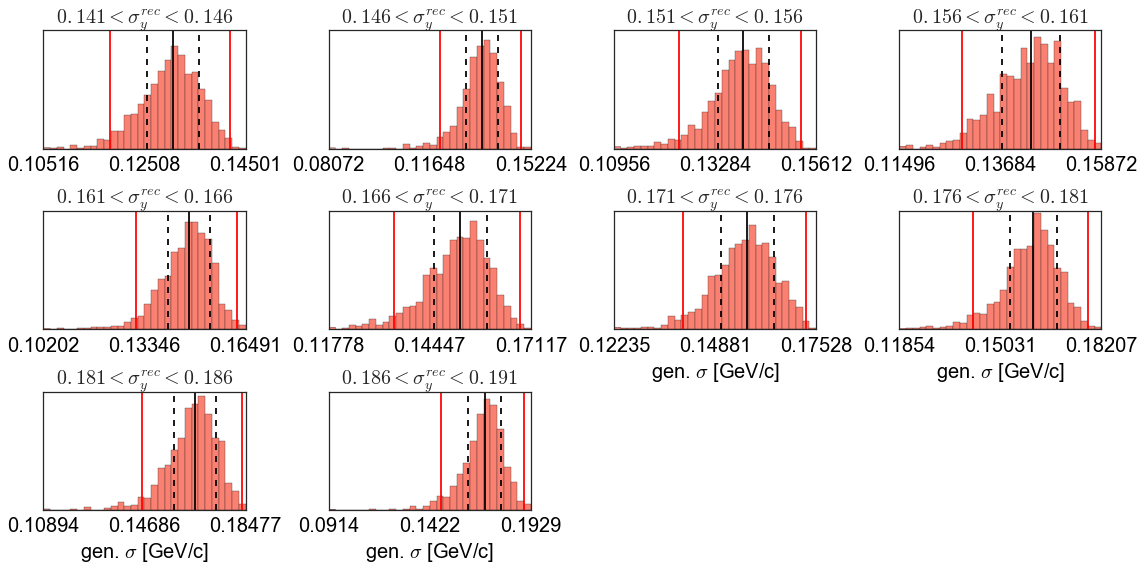

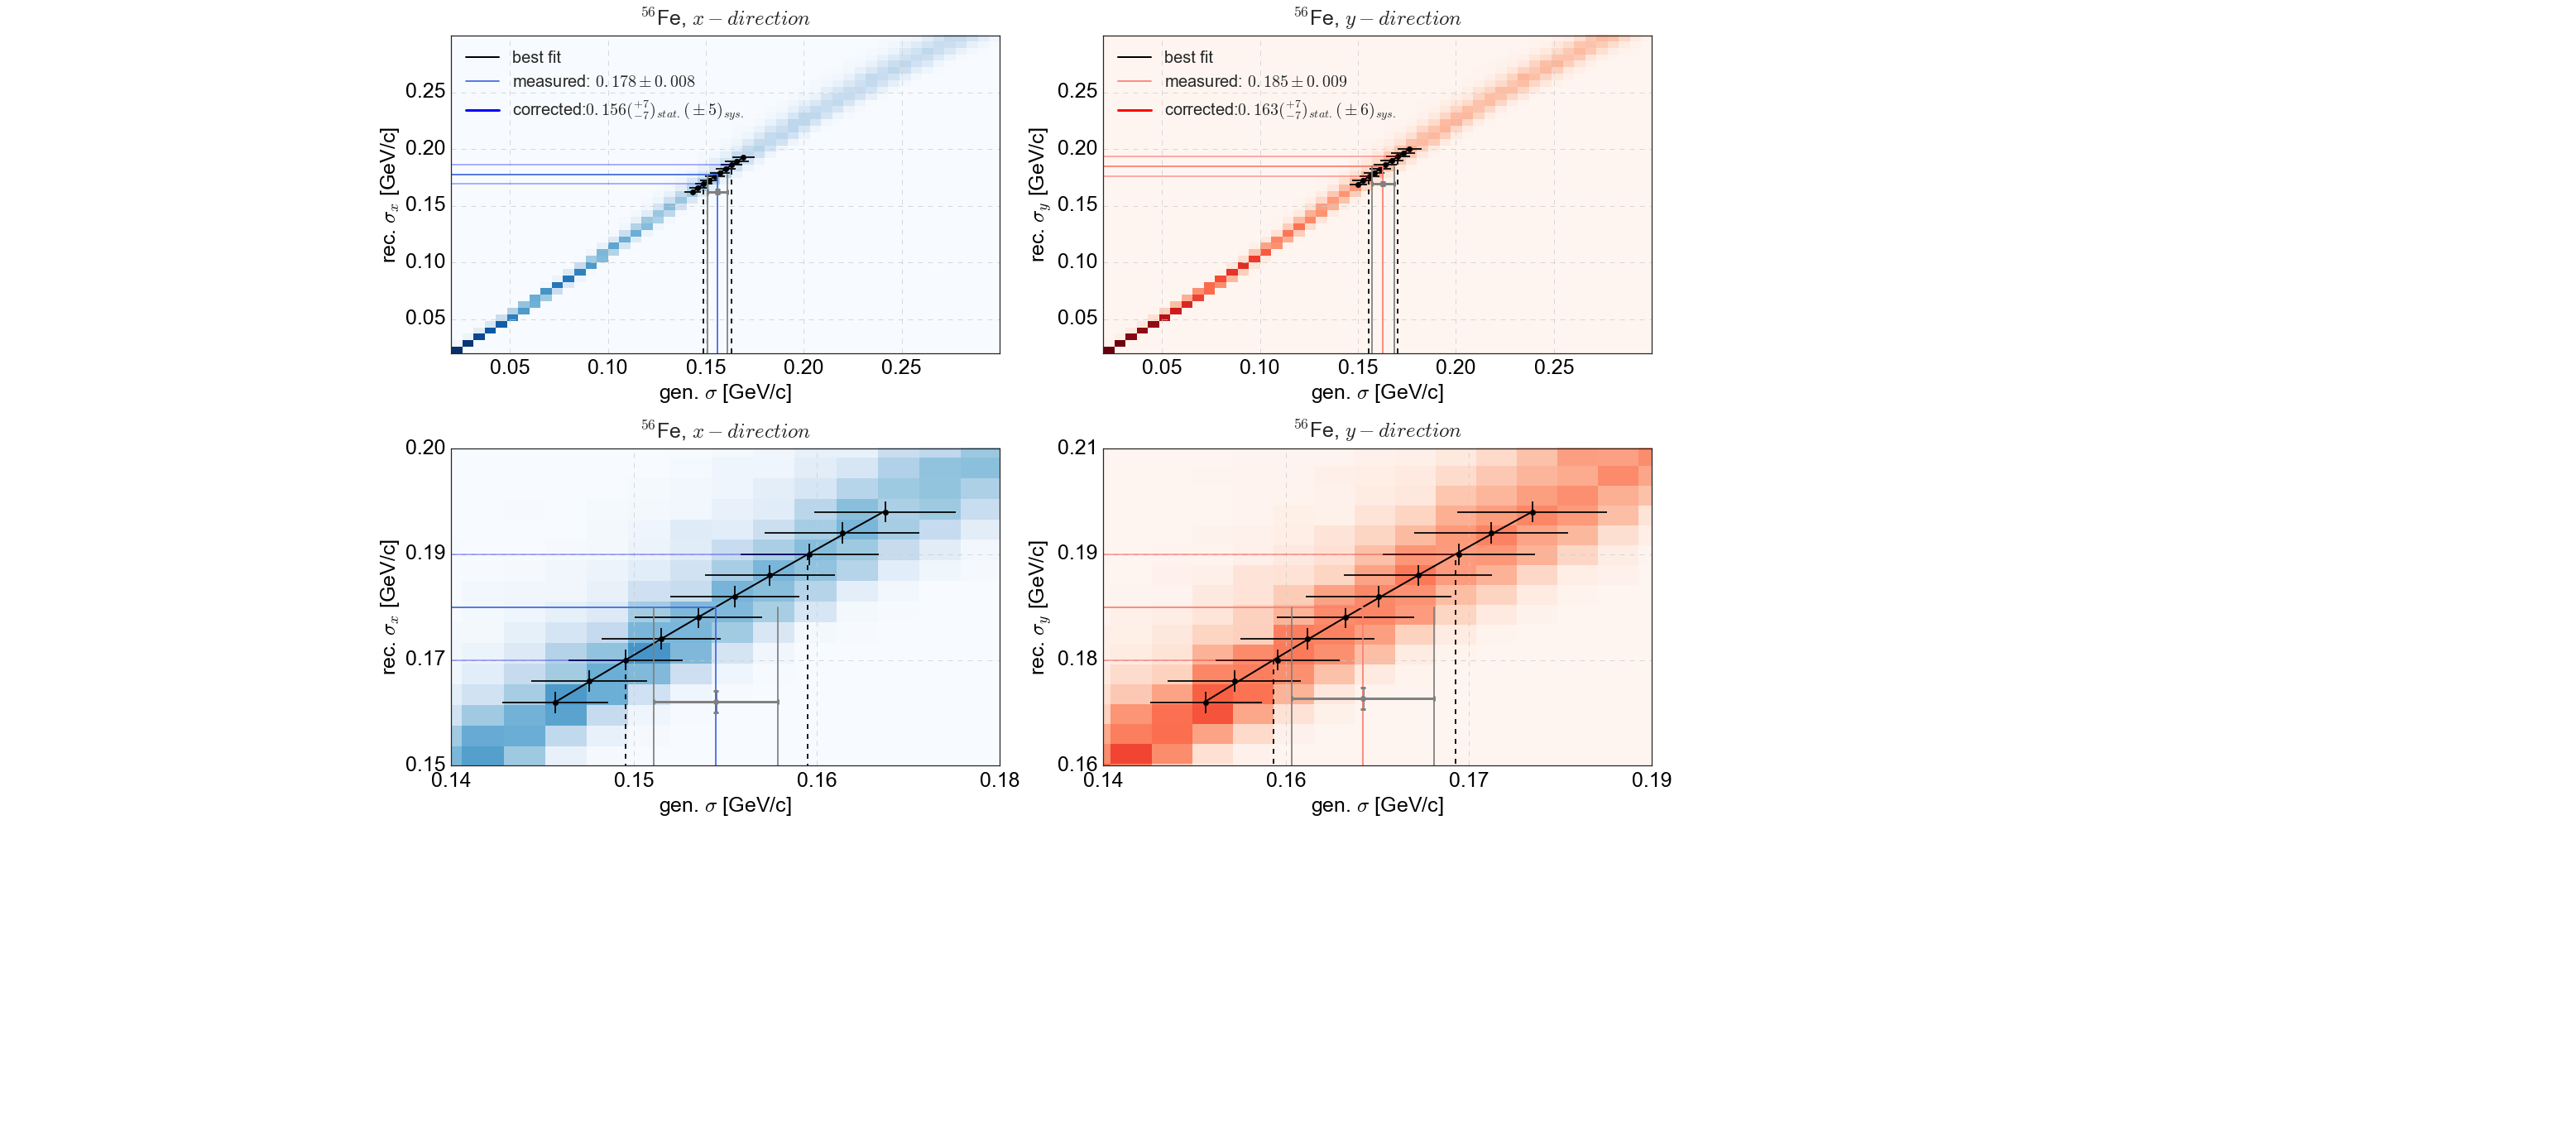

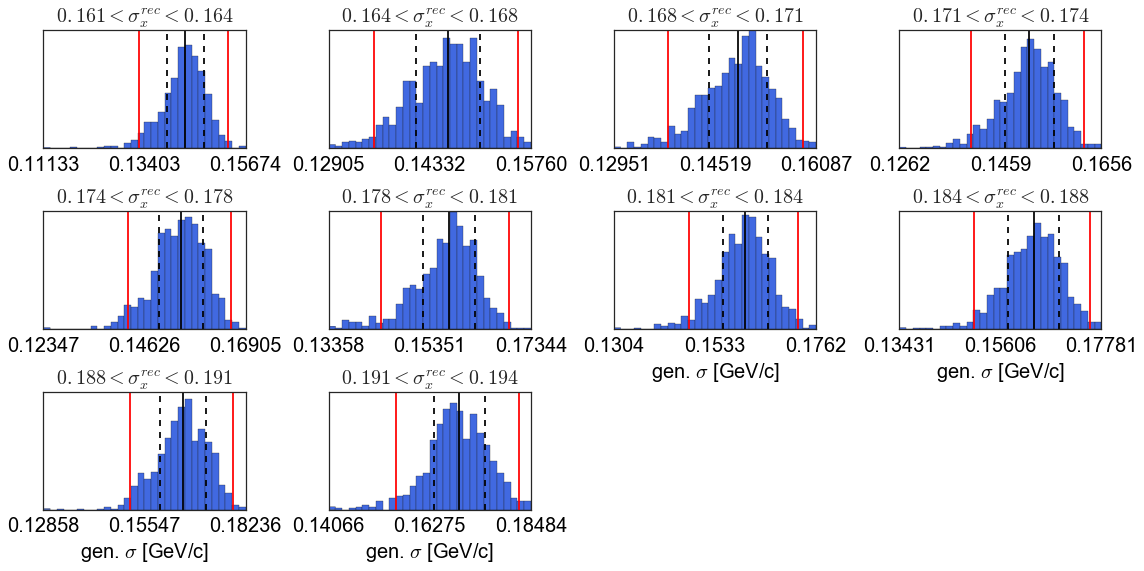

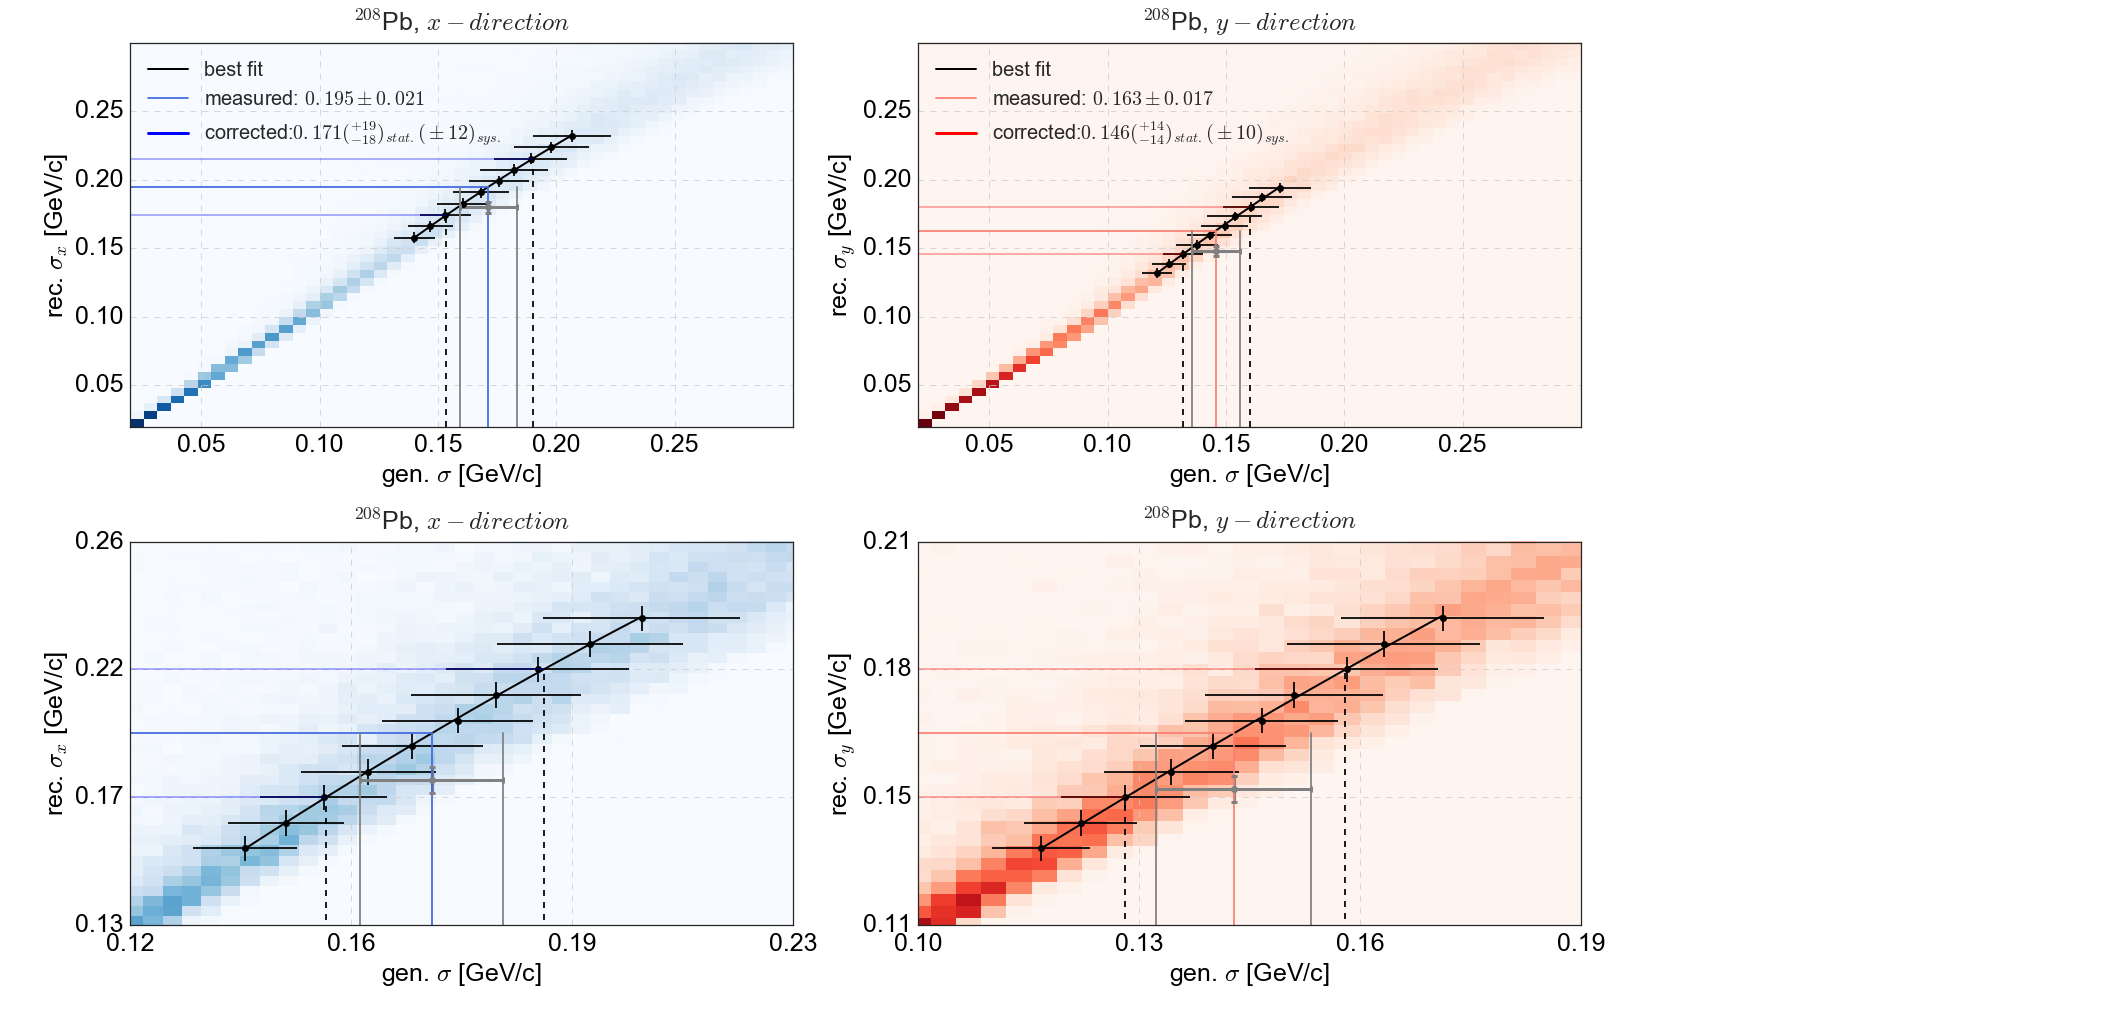

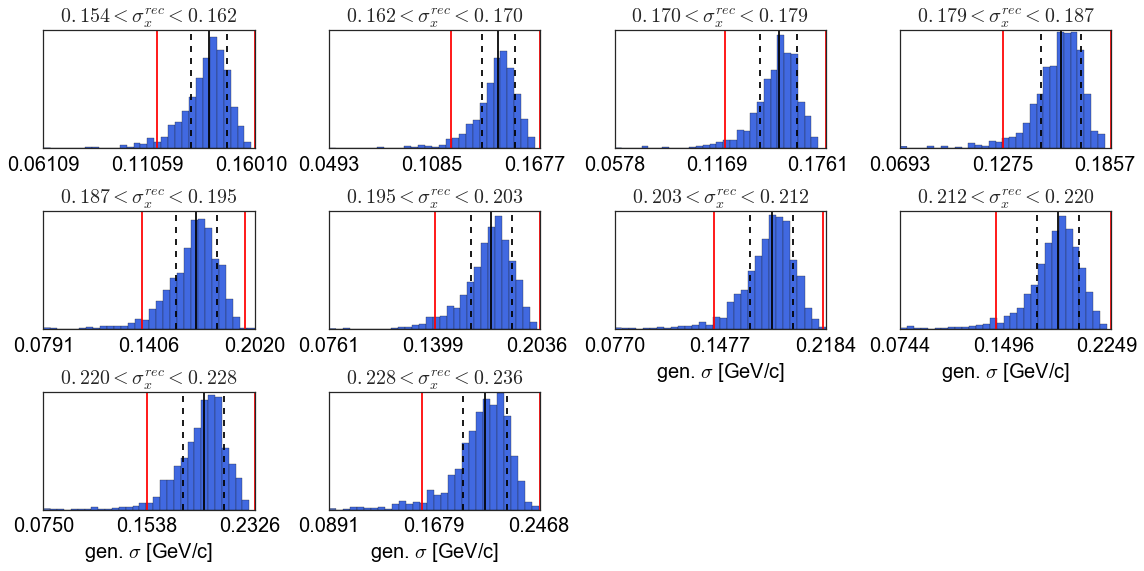

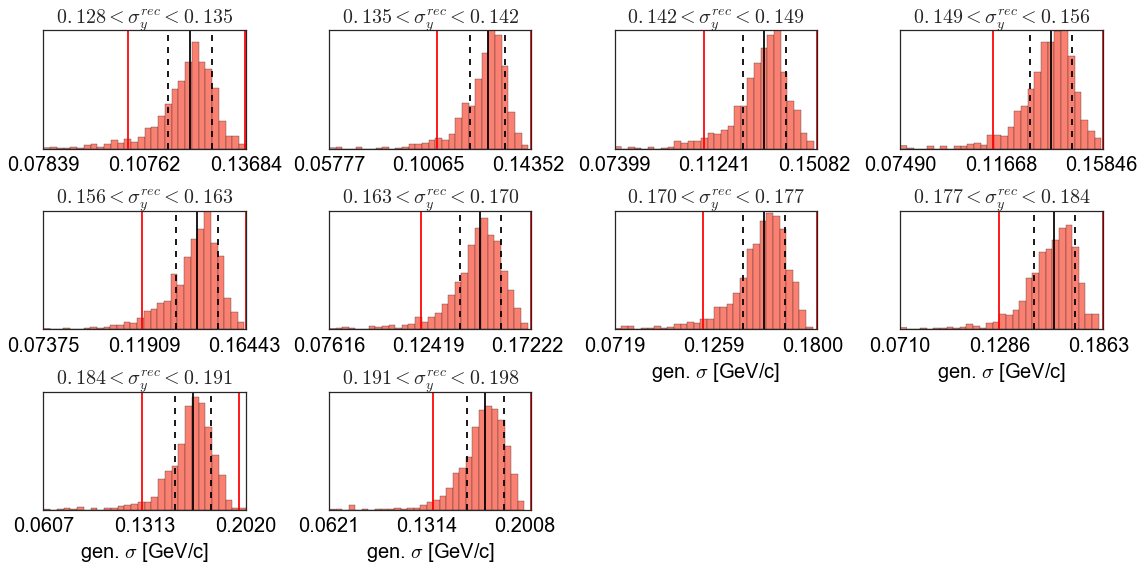

In [72]:
poly_degree = 2 # fit polynomial degree
extraname='mean_rms'
for i,(A,target) in enumerate(zip(As[0:],targets[0:])):
    test_name = "simulations_"+Fiducials+"_"+target
    sims=simulation_results[test_name]        
    good_results = sims[
            (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
            &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)]
    fig=plt.figure(figsize=(22,14))
    ax=fig.add_subplot(2,2,1)    
    plot_cm_direction_binned(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,3)    
    plot_cm_direction_binned(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree
                                    ,A=A,direction='x'
                                    ,colors=['blue','royalblue','Blues'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    ax=fig.add_subplot(2,2,2)
    plot_cm_direction_binned(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0,do_add_1Ddist_in_slices=True)
    ax=fig.add_subplot(2,2,4)
    plot_cm_direction_binned(sims=good_results, ax=ax,s=3,extraname=extraname
                                    ,poly_degree=poly_degree if A!=12 else 1
                                    ,A=A,direction='y'
                                    ,colors=['red','salmon','Reds'],debug=0
                             ,do_zoom_in=True ,do_add_1Ddist_in_slices=False,do_add_legend=False)

    fig.subplots_adjust(bottom=-0.5,left=-0.2)
    fig.tight_layout() 
    filename = figures_path+'St_gen_rec_'+target+'.png' if extraname=='' else figures_path+'St_gen_rec_'+target+'_'+extraname+'.png'    
    fig.savefig( filename )

In [73]:
sample = cm_parameters_with_correction['PrecFiducials']
extraname='mean_rms'

for direction in ['x','y']:
    sample['sigma_'+direction+extraname+'_final'] = sample['sigma_'+direction+'_corrected'+extraname]
    for updw in ['up','dw']:
        sample['sigma_'+direction+extraname+'_final_'+updw+'_err'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot'+extraname]

corr_x = sample['sigma_x_corrected'+extraname]
Dcorr_x = sample['sigma_x_corrected_err_tot'+extraname]

corr_y = sample['sigma_y_corrected'+extraname]
Dcorr_y = sample['sigma_y_corrected_err_tot'+extraname]

# weighted average
corr_t = (corr_x/np.square(Dcorr_x)+corr_y/np.square(Dcorr_y))/( 1./np.square(Dcorr_x) + 1./np.square(Dcorr_y))
sample['sigma_t'+extraname+'_final'] = corr_t
    
Dsys_x = sample['sigma_x_corrected_err_sys'+extraname]
Dsys_y = sample['sigma_y_corrected_err_sys'+extraname]
Dsys_t = 0.5*( Dsys_x + Dsys_y )
# Dsys_t = np.sqrt(1./( 1./np.square(Dsys_x) + 1./np.square(Dsys_y) ))
sample['sigma_t'+extraname+'_final_err_sys'] = Dsys_t


for updw in ['up','dw']:            
    Dstat_x = sample['sigma_x_corrected_'+updw+'_err_stat'+extraname]
    Dstat_y = sample['sigma_y_corrected_'+updw+'_err_stat'+extraname]
    #     Dstat_t = 0.5*np.sqrt( np.square(Dstat_x) + np.square(Dstat_y) )
    Dstat_t = np.sqrt(1./( 1./np.square(Dstat_x) + 1./np.square(Dstat_y) ))
    sample['sigma_t'+extraname+'_final_'+updw+'_err_stat'] = Dstat_t

    Dtot_t = np.sqrt( np.square(Dstat_t) + np.square(Dsys_t) )
    sample['sigma_t'+extraname+'_final_'+updw+'_err_tot'] = Dtot_t
    sample['sigma_t'+extraname+'_final_'+updw+'_err'] = Dtot_t

sample['sigma_t'+extraname+'_final_err_sys'] = sample['sigma_t_final_err_sys']

In [74]:
cm_parameters_with_correction['PrecFiducials'][['sigma_t_final'
                                                ,'sigma_t_final_up_err','sigma_t_final_dw_err'
                                                ,'sigma_t'+extraname+'_final'
                                                ,'sigma_t'+extraname+'_final_up_err','sigma_t'+extraname+'_final_dw_err']].astype(float)

sigma_t_final  sigma_t_final_up_err  sigma_t_final_dw_err  \
0       0.143316              0.005485              0.005469   
1       0.155218              0.010951              0.010709   
2       0.159014              0.007414              0.007359   
3       0.157168              0.016024              0.015681   

   sigma_tmean_rms_final  sigma_tmean_rms_final_up_err  \
0               0.143455                      0.005478   
1               0.155257                      0.010765   
2               0.159052                      0.007448   
3               0.155679                      0.015949   

   sigma_tmean_rms_final_dw_err  
0                      0.005453  
1                      0.010678  
2                      0.007344  
3                      0.015610

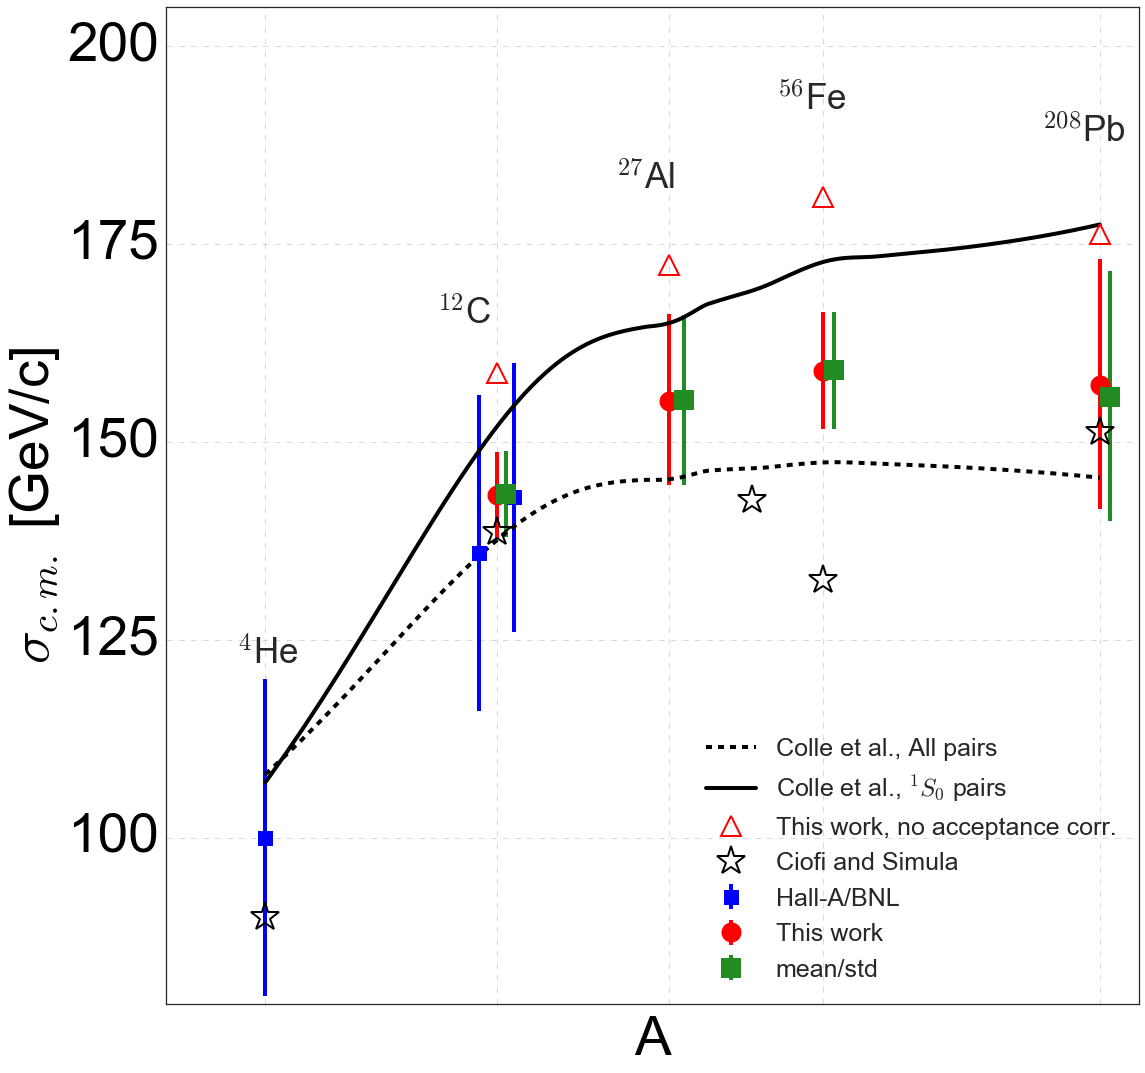

In [90]:
extraname='mean_rms'
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(158,188), }),do_Ciofi=True)

plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],direction='t',ax=ax, label="This work" , marker='o', markersize=20 )
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],Ashift=[0.5,2,3,10], direction='t'+extraname,ax=ax, label="mean/std" , marker='s', markersize=20 , color='forestgreen')
plt.legend(fontsize=20,loc='upper left')
# measured
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')

ax.legend(fontsize=25,loc='lower right')
plt.tight_layout()
plt.savefig(figures_path +'results_compare_mean_rms.pdf')

# compare alltogether

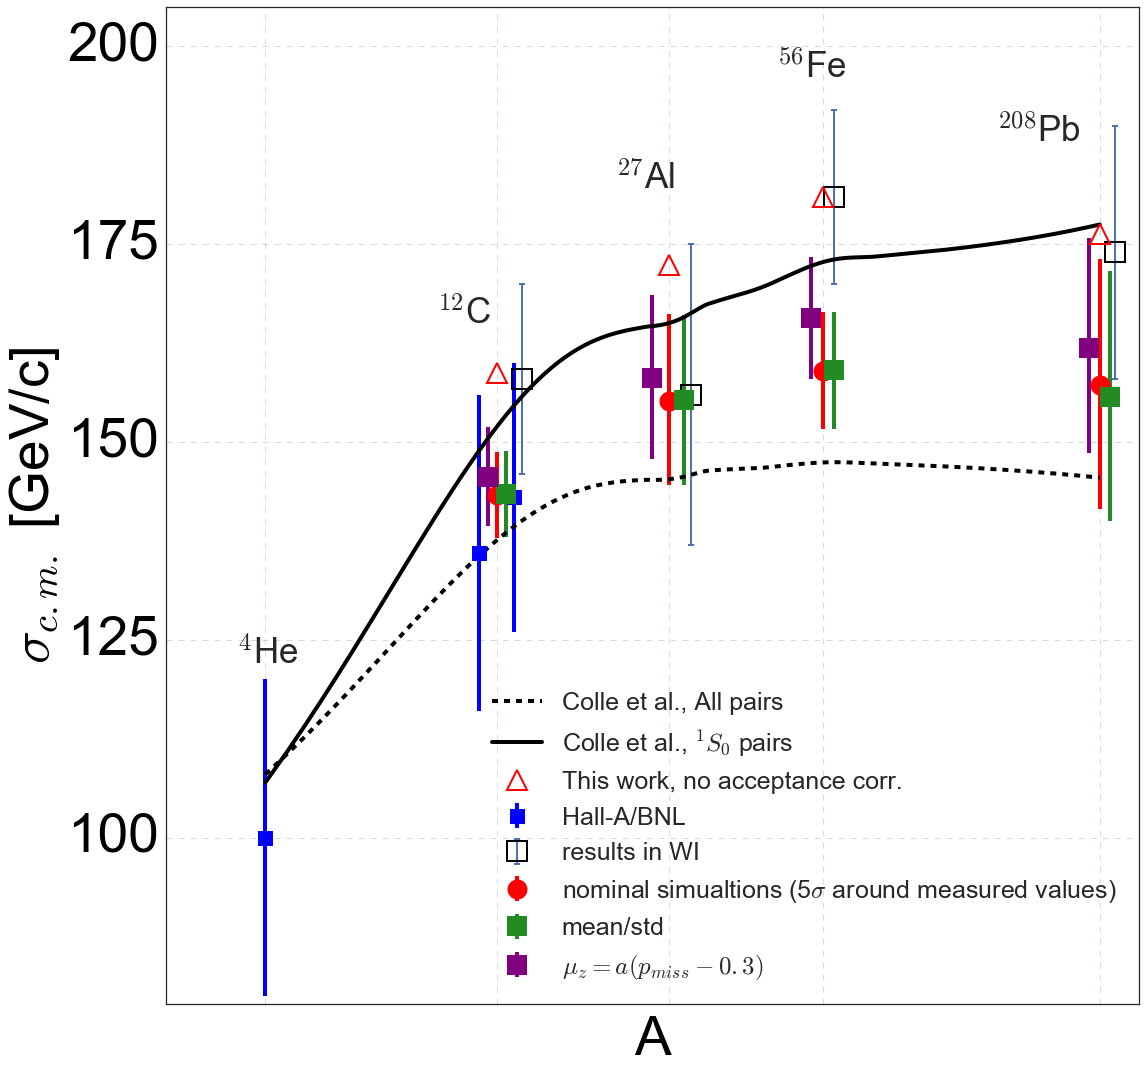

In [89]:
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,196), '$^{208}$Pb':(128,188), }),do_Ciofi=False)

ax.errorbar(WI_Data['A']+[1.5,3,3,15], 1000*WI_Data['sigma_t_final'], 1000*WI_Data['sigma_t_final_Err'] ,mec='black', linestyle='none', marker='s',mfc='none',lw = 3, mew = 2, ms = 20, linewidth=2, label='results in WI')
# plot_data( data=WI_Data, ax=ax,label='results in WI',Ashift=[1.5,3,3,15],  markersize=20 , marker='s', color='black')

plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],ax=ax, label='nominal simualtions (5$\\sigma$ around measured values)', marker='o', markersize=20 )
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')

for extraname,label,Ashift,color in zip(['mean_rms','MeanZLinearInPmiss','ConstBandAroundMeasuredValues']
                                        ,['mean/std',r'$\mu_{z}=a(p_{miss}-0.3)$',r'Constant band around $\sigma_z,\mu_z$']
                                        ,[[0.5,2,3,10],[-0.5,-2,-3,-10]]
                                        ,['forestgreen','purple']):
    plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],Ashift=Ashift, direction='t'+extraname,ax=ax, label=label , marker='s', markersize=20 , color=color)


ax.legend(fontsize=25, loc='lower right')
plt.tight_layout()
plt.savefig( figures_path + 'results_compare_alltogether.pdf')

# spill all the results to a csv file, to allow a fast analysis later

In [96]:
for col in cm_parameters_with_correction['PrecFiducials'].columns:
    print col

Nevts
chi2red_x_unweighted
chi2red_y_unweighted
chi2red_z_unweighted
mean_xErr_unweighted
mean_x_unweighted
mean_yErr_unweighted
mean_y_unweighted
mean_zErr_unweighted
mean_z_unweighted
ndof_x_unweighted
ndof_y_unweighted
ndof_z_unweighted
sigma_xErr_unweighted
sigma_x_unweighted
sigma_yErr_unweighted
sigma_y_unweighted
sigma_zErr_unweighted
sigma_z_unweighted
target
A
sigma_x_before_acc_corr
sigma_x_before_acc_corr_err
sigma_y_before_acc_corr
sigma_y_before_acc_corr_err
sigma_t_before_acc_corr
sigma_t_before_acc_corr_err
sigma_x_correctedconfidence68
sigma_x_corrected_up_err_statconfidence68
sigma_x_corrected_dw_err_statconfidence68
sigma_x_corrected_err_sysconfidence68
sigma_x_corrected_up_err_totconfidence68
sigma_x_corrected_dw_err_totconfidence68
sigma_x_corrected_err_totconfidence68
sigma_y_correctedconfidence68
sigma_y_corrected_up_err_statconfidence68
sigma_y_corrected_dw_err_statconfidence68
sigma_y_corrected_err_sysconfidence68
sigma_y_corrected_up_err_totconfidence68
sigma_y

In [99]:
nominal_results = cm_parameters_with_correction['PrecFiducials'][[
        'target'
        ,'sigma_x_before_acc_corr','sigma_x_before_acc_corr_err'
        ,'sigma_x_final'
        ,'sigma_x_final_up_err','sigma_x_final_dw_err'
        
        ,'sigma_y_before_acc_corr','sigma_y_before_acc_corr_err'
        ,'sigma_y_final'
        ,'sigma_y_final_up_err','sigma_y_final_dw_err'
        
        ,'sigma_t_before_acc_corr','sigma_t_before_acc_corr_err'
        ,'sigma_t_final'
        ,'sigma_t_final_err_sys'
        ,'sigma_t_final_up_err_stat','sigma_t_final_dw_err_stat'
        ,'sigma_t_final_up_err_tot','sigma_t_final_dw_err_tot']]

nominal_results.to_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/final_results/nominal_results.csv')

In [108]:
for extraname in ['MeanZLinearInPmiss','mean_rms','ConstBandAroundMeasuredValues']:
    modified_results = cm_parameters_with_correction['PrecFiducials'][[
        'target'
        ,'sigma_x_before_acc_corr','sigma_x_before_acc_corr_err'
        ,'sigma_x'+extraname+'_final'
        ,'sigma_x'+extraname+'_final_up_err','sigma_x'+extraname+'_final_dw_err'
        
        ,'sigma_y_before_acc_corr','sigma_y_before_acc_corr_err'
        ,'sigma_y'+extraname+'_final'
        ,'sigma_y'+extraname+'_final_up_err','sigma_y'+extraname+'_final_dw_err'
        
        ,'sigma_t_before_acc_corr','sigma_t_before_acc_corr_err'
        ,'sigma_t'+extraname+'_final'
        ,'sigma_t'+extraname+'_final_err_sys'
        ,'sigma_t'+extraname+'_final_up_err_stat','sigma_t'+extraname+'_final_dw_err_stat'
        ,'sigma_t'+extraname+'_final_up_err_tot','sigma_t'+extraname+'_final_dw_err_tot']]

    modified_results.to_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/final_results/'+extraname+'.csv')

In [107]:
extraname = "NoPrecFiducials"
modified_results = cm_parameters_with_correction['NoPrecFiducials'][[
        'target'
        ,'sigma_x_before_acc_corr','sigma_x_before_acc_corr_err'
        ,'sigma_x'+extraname+'_final'
        ,'sigma_x'+extraname+'_final_up_err','sigma_x'+extraname+'_final_dw_err'
        
        ,'sigma_y_before_acc_corr','sigma_y_before_acc_corr_err'
        ,'sigma_y'+extraname+'_final'
        ,'sigma_y'+extraname+'_final_up_err','sigma_y'+extraname+'_final_dw_err'
        
        ,'sigma_t_before_acc_corr','sigma_t_before_acc_corr_err'
        ,'sigma_t'+extraname+'_final'
        ,'sigma_t'+extraname+'_final_err_sys'
        ,'sigma_t'+extraname+'_final_up_err_stat','sigma_t'+extraname+'_final_dw_err_stat'
        ,'sigma_t'+extraname+'_final_up_err_tot','sigma_t'+extraname+'_final_dw_err_tot']]

modified_results.to_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/final_results/'+extraname+'.csv')